In [1]:
import pandas as pd
import numpy as np
from benchmarks import *
import glob
import os, sys
import seaborn as sns
import matplotlib.pyplot as plt
import re
import time
from tqdm.notebook import tqdm

ROOT_DIR /usr/WS2/bolet1/ruby-benchmarks/exploreGlobalOptimizations


In [2]:
print(MACHINE, ROOT_DIR)
prognames = list(progs.keys())
probsizes = ['smlprob', 'medprob', 'lrgprob']

logsDir = ROOT_DIR+'/logs'

goMethods=['cma', 'pso', 'bo']
seeds = [1337, 3827, 9999, 4873]

hypers = {
	'cma':['popsize', 'sigma'],
	'pso':['popsize', 'w', 'c1', 'c2'],
	'bo':['utilFnct', ['kappa', 'kappa_decay', 'kappa_decay_delay'], ['xi']]
}

ruby /usr/WS2/bolet1/ruby-benchmarks/exploreGlobalOptimizations


In [3]:
def plotOneVariableSweep(df, colToPlot, goMethodText=None, epsilon=0.0):
	# x-axis = samples
	# y-axis = percent xtime
	# legend = colToPlot
	df = df.copy(deep=True).reset_index(drop=True)

	# progname, probsize, and method are all the same
	assert len(list(df['progname'].unique())) == 1
	assert len(list(df['probsize'].unique())) == 3
	assert len(list(df['method'].unique())) == 1

	progname = df.iloc[0]['progname']
	#probsize = df.iloc[0]['probsize']
	method = df.iloc[0]['method']

	# shrink what we're working with
	df = df.drop(['progname', 'method', 'optimXtime'], axis=1)

	if method == 'bo':
		numUtilFncts = len(list(df['utilFnct'].unique()))
		if numUtilFncts == 1:
			util = df.iloc[0]['utilFnct']
			df = df.drop(['utilFnct'], axis=1)
			if ('poi' in util) or ('ei' in util):
				df = df.drop(['kappa', 'kappa_decay', 'kappa_decay_delay'], axis=1)
			elif 'ucb' in util:
				df = df.drop(['xi'], axis=1)
		# need to ignore the first sample since it's random
		df.loc[df['globalSample'] == 0.0, 'xtime'] = 0

	if goMethodText:
		method += f' ({goMethodText})'

	# if the globalSample < popsize, 
	# set the xtime to 0 so we don't count the point
	if ('pso' in method) or ('cma' in method):
		#df = df.apply(lambda row: (row['xtime']=0.0) if row['globalIdx'] < row['popsize'] else pass)
		df.loc[df['globalSample'] < df['popsize'], 'xtime'] = 0

	df['reachedOptimal'] = (df['xtime'] >= 1-epsilon).astype(int)

	#check = df[(df['sigma'] == 1.0) & (df['seed'] == 1337) & (df['popsize'] == 3.0) & (df['probsize'] == 'smlprob')]['reachedOptimal'].sum()
	#print('sanity check', check)

	targetCols = list(df.columns)
	#print(targetCols)
	targetCols.remove('xtime')
	targetCols.remove('reachedOptimal')
	targetCols.remove('globalSample')
	#print('colToPlot', colToPlot, 'cumsumming over:', targetCols)
	# do a cumsum and then turn it to binary
	indics = df.groupby(list(targetCols))

	# take a cumsum to make the values along the way nonzero, then binarize them
	df['runIndic'] = indics['reachedOptimal'].cumsum().reset_index()['reachedOptimal'].apply(lambda x: 1 if x != 0 else 0)
	#print('test', test, df.head(), df.tail(), df.iloc[595:605], df['runIndic'].sum(), sep='\n')

	# groupby the problem size and colToPlot
	grouped = df.groupby(['probsize', colToPlot, 'globalSample'])['runIndic'].mean().reset_index()

	# scale up the runIndic from 0 to 100
	grouped['runIndic'] = grouped['runIndic']*100.0
	#print('grouped up')
	#print(grouped, grouped.head())

	g = sns.FacetGrid(grouped, col='probsize', col_order=probsizes, hue=colToPlot, palette='flare', legend_out=True, height=5, aspect=1.5)
	g.map_dataframe(sns.lineplot, x='globalSample', y='runIndic')
	g.add_legend()
	g.set(ylim=(-0.05, 100.05))
	g.fig.subplots_adjust(top=0.85)
	g.fig.suptitle(f'{progname} -- {method.upper()} -- sweep "{colToPlot}" hyperparam')

	axes = g.axes.flatten()
	axes[0].set_ylabel('Percent of Executions that find the Database Optimal \n(higher is better)')
	for ax in axes:
		ax.set_xlabel('Sample Index')
		ax.axhline(y=100.0, zorder=0, ls='--')
		axTitle = ax.get_title()
		if 'lrgprob' in axTitle:
			ax.set_title('Large Input')
		elif 'medprob' in axTitle:
			ax.set_title('Medium Input')
		else:
			ax.set_title('Small Input')

	plt.show()

	return

In [4]:

def plotIndividualVariablesForAllCodes():
	# this plots each of the individual variables of each method
	# applied to each progname+probsize combination.
	# it averages xtimes across seeds.
	for progname in prognames:
		for method in goMethods:
			# read the pre-processed dataframe
			filename = ROOT_DIR+'/databases/'+f'{progname}-{method}-GO_Data.csv'
			fullDF = pd.read_csv(filename)
				
			hyps = hypers[method]
			for hyp in hyps:
				if method == 'bo':
					if 'kappa' in hyp:
						boDF = fullDF[fullDF['utilFnct'] == 'ucb']
						for h in hyp:
							plotOneVariableSweep(boDF, h, 'ucb')
					elif 'xi' in hyp:
						boDF = fullDF[fullDF['utilFnct'] == 'poi']
						for h in hyp:
							plotOneVariableSweep(boDF, h, 'poi')
						boDF = fullDF[fullDF['utilFnct'] == 'ei']
						for h in hyp:
							plotOneVariableSweep(boDF, h, 'ei')
					else:
						plotOneVariableSweep(fullDF, hyp, 'overall')
				else:
					plotOneVariableSweep(fullDF, hyp)
	return
				



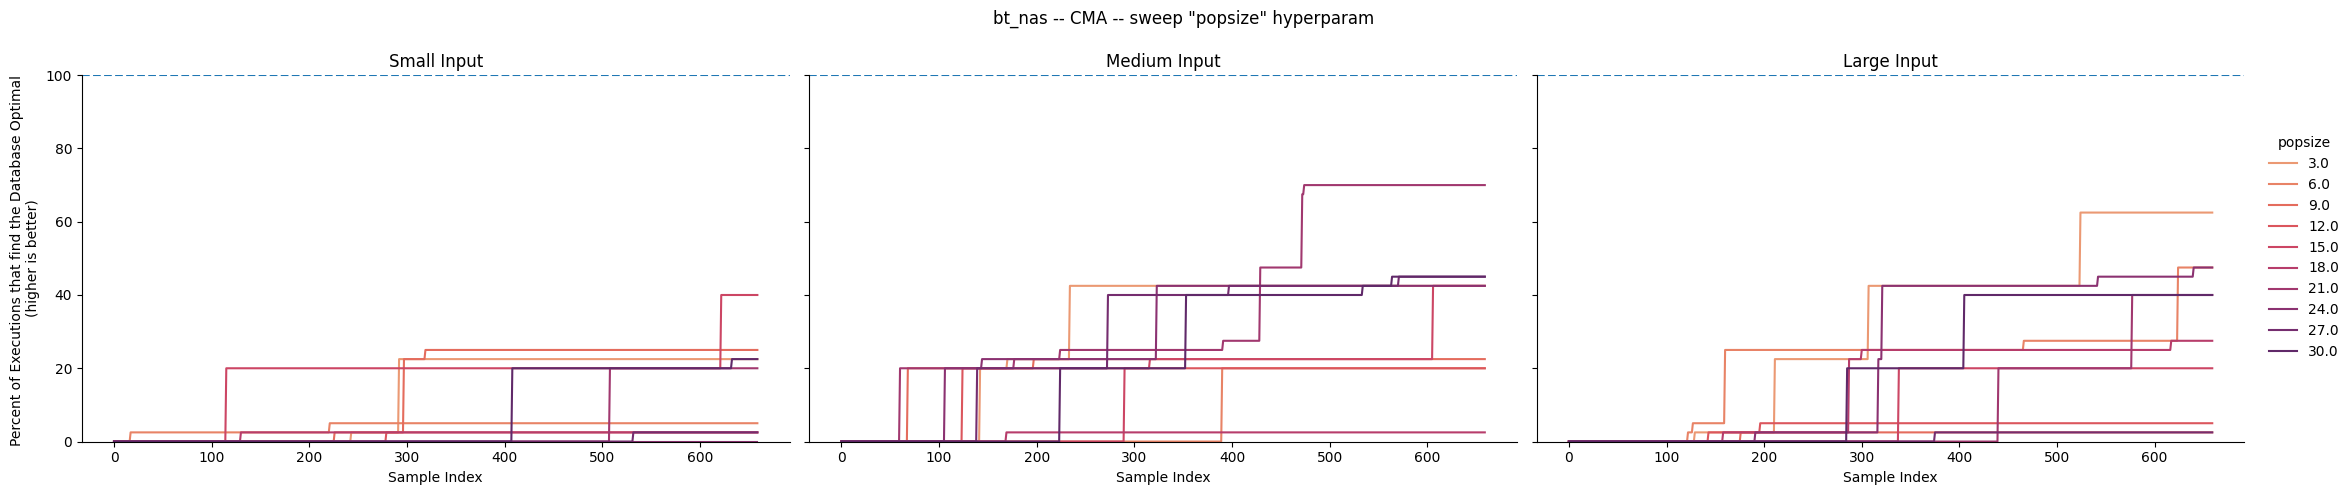

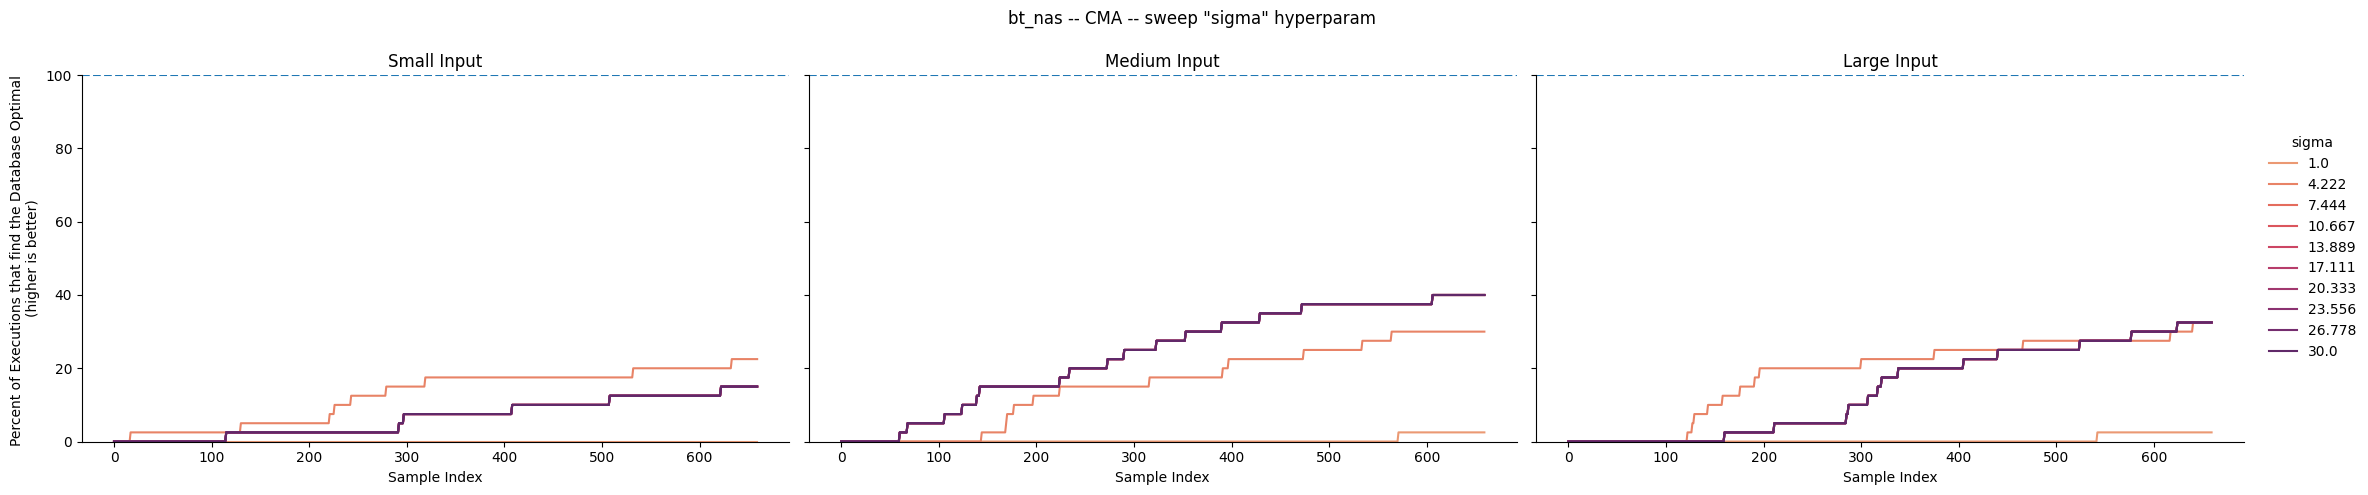

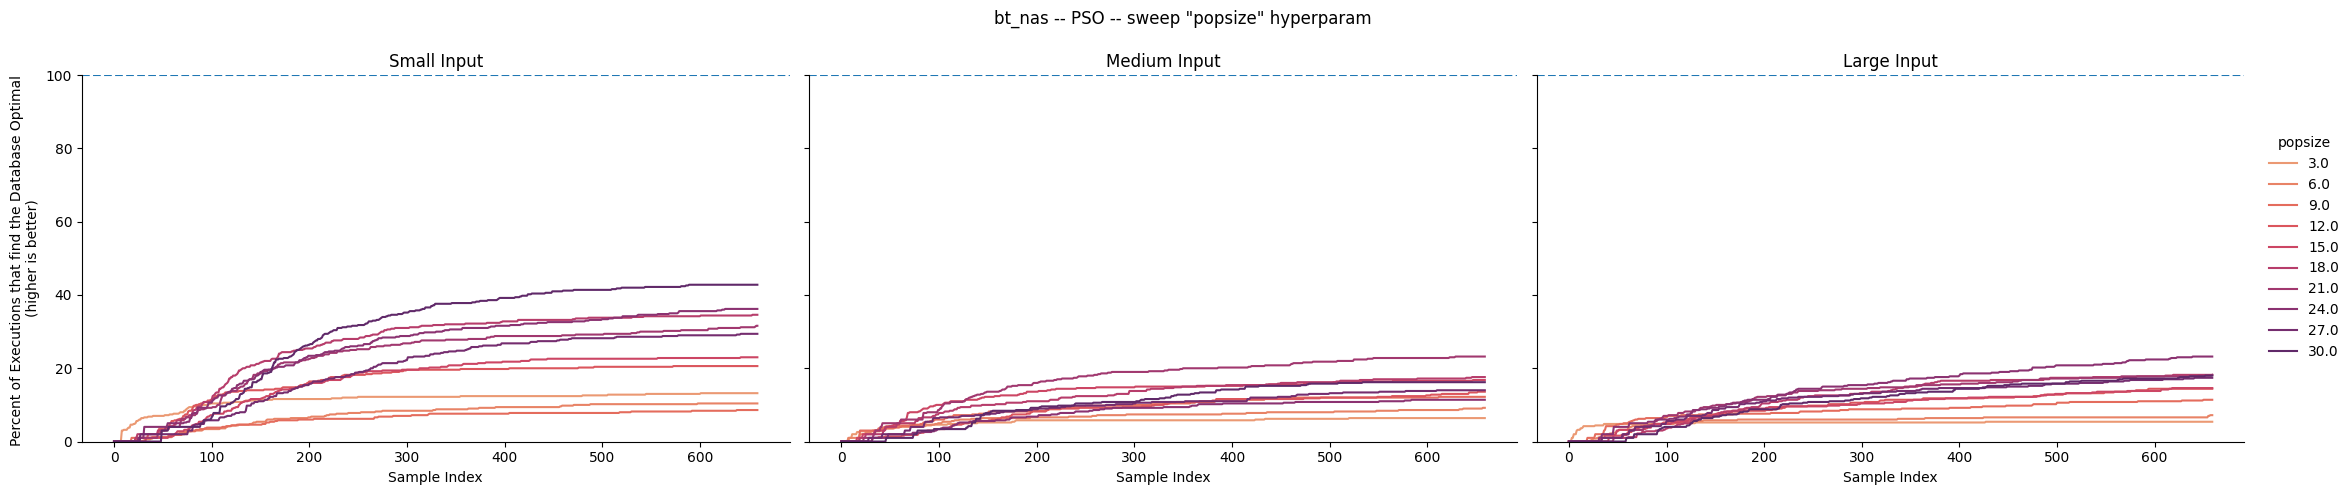

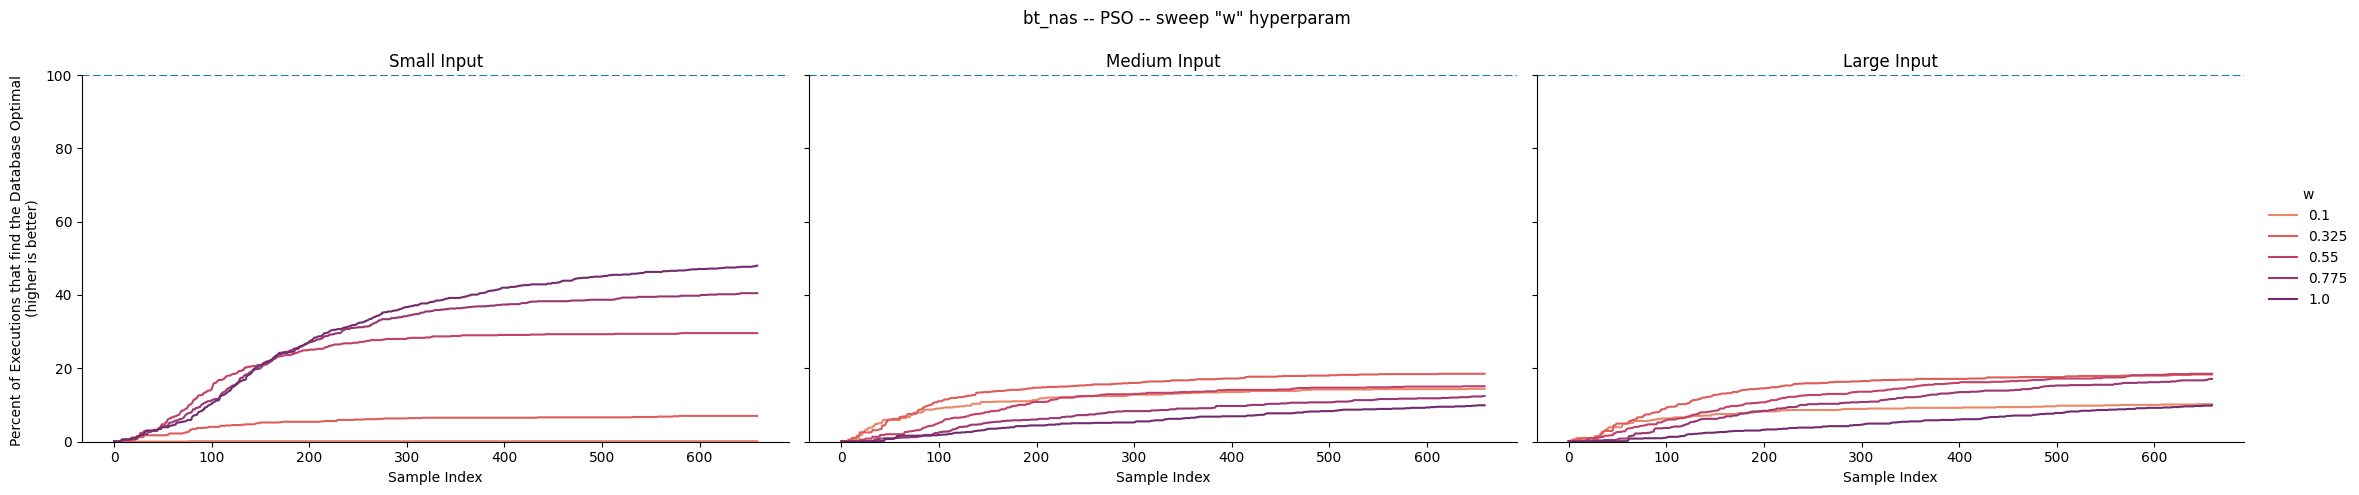

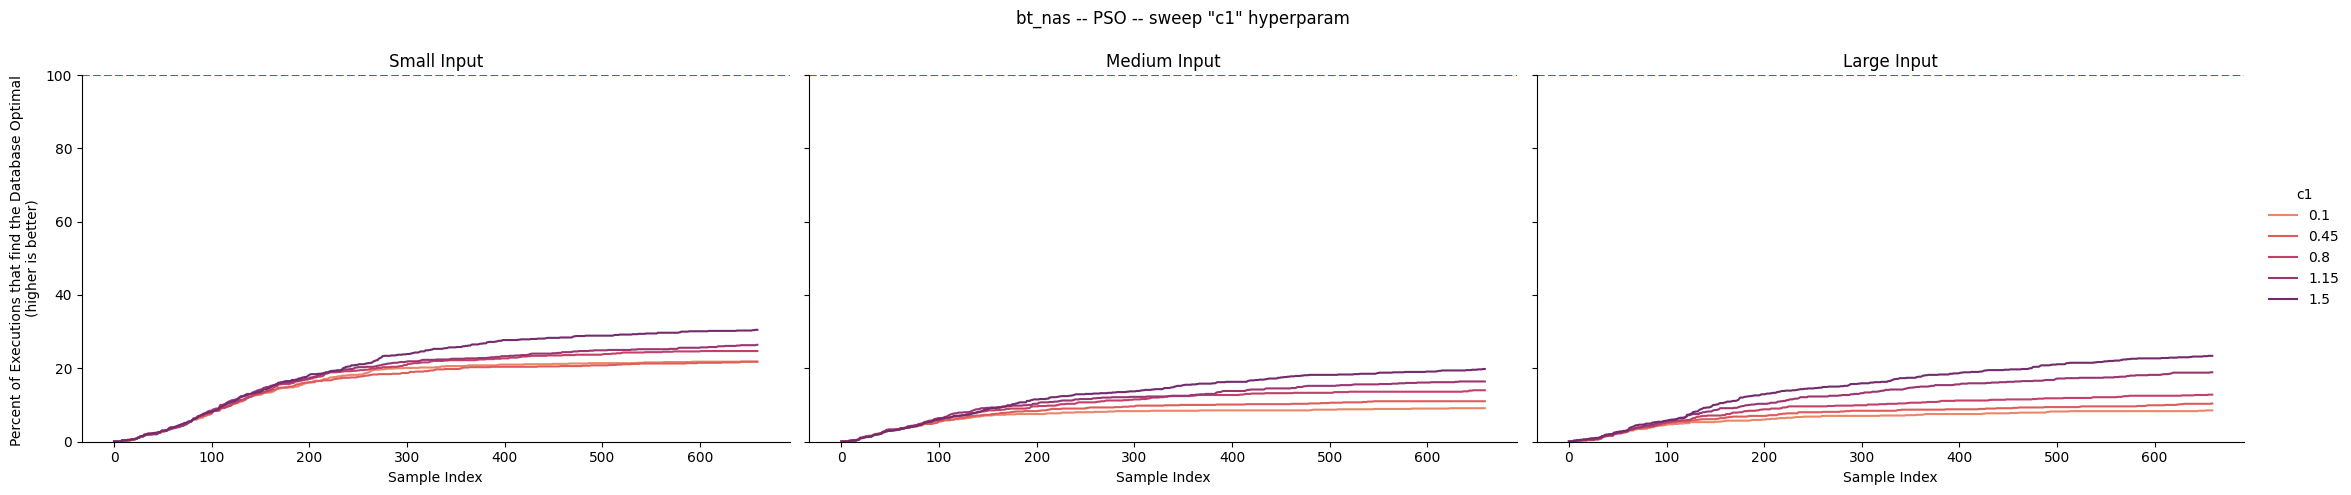

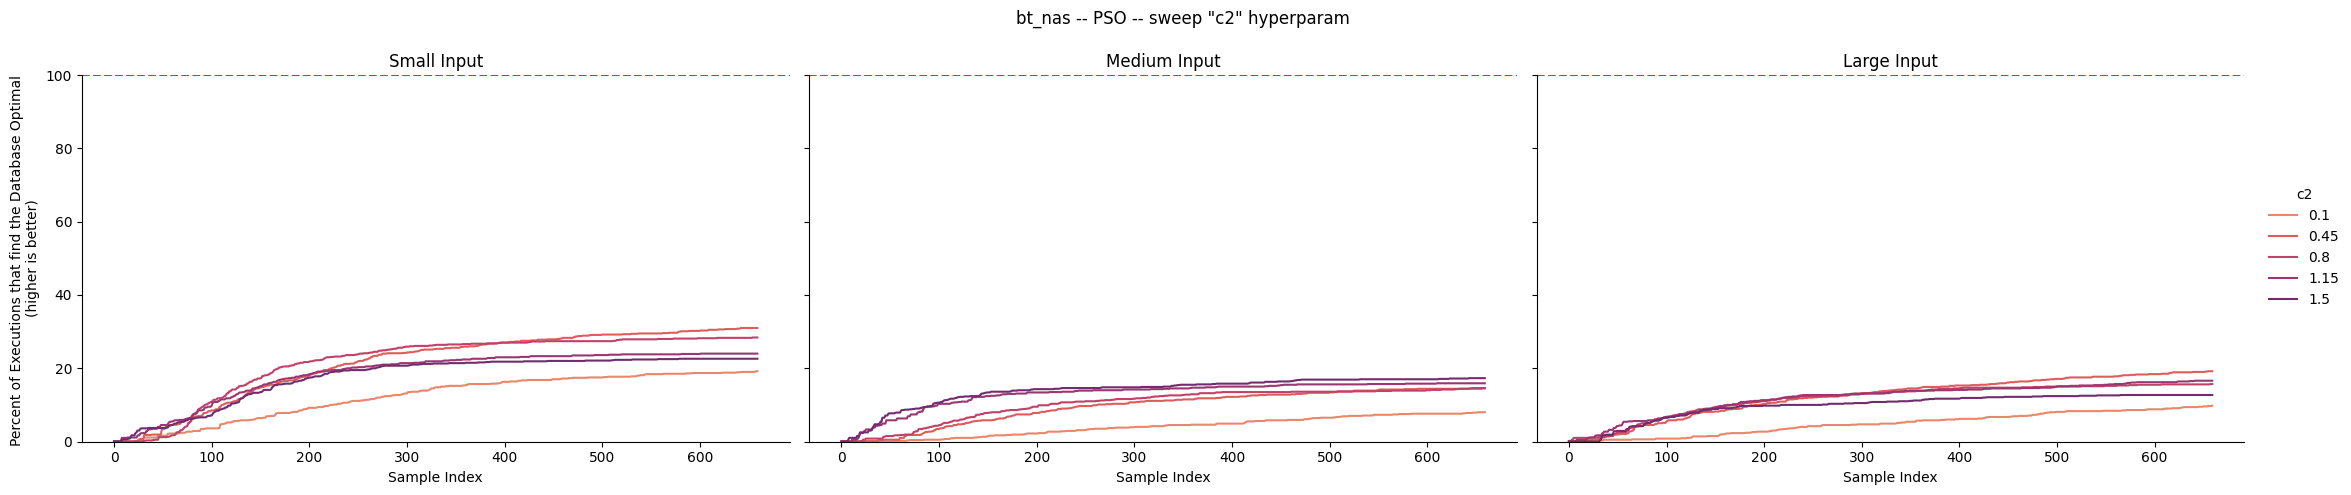

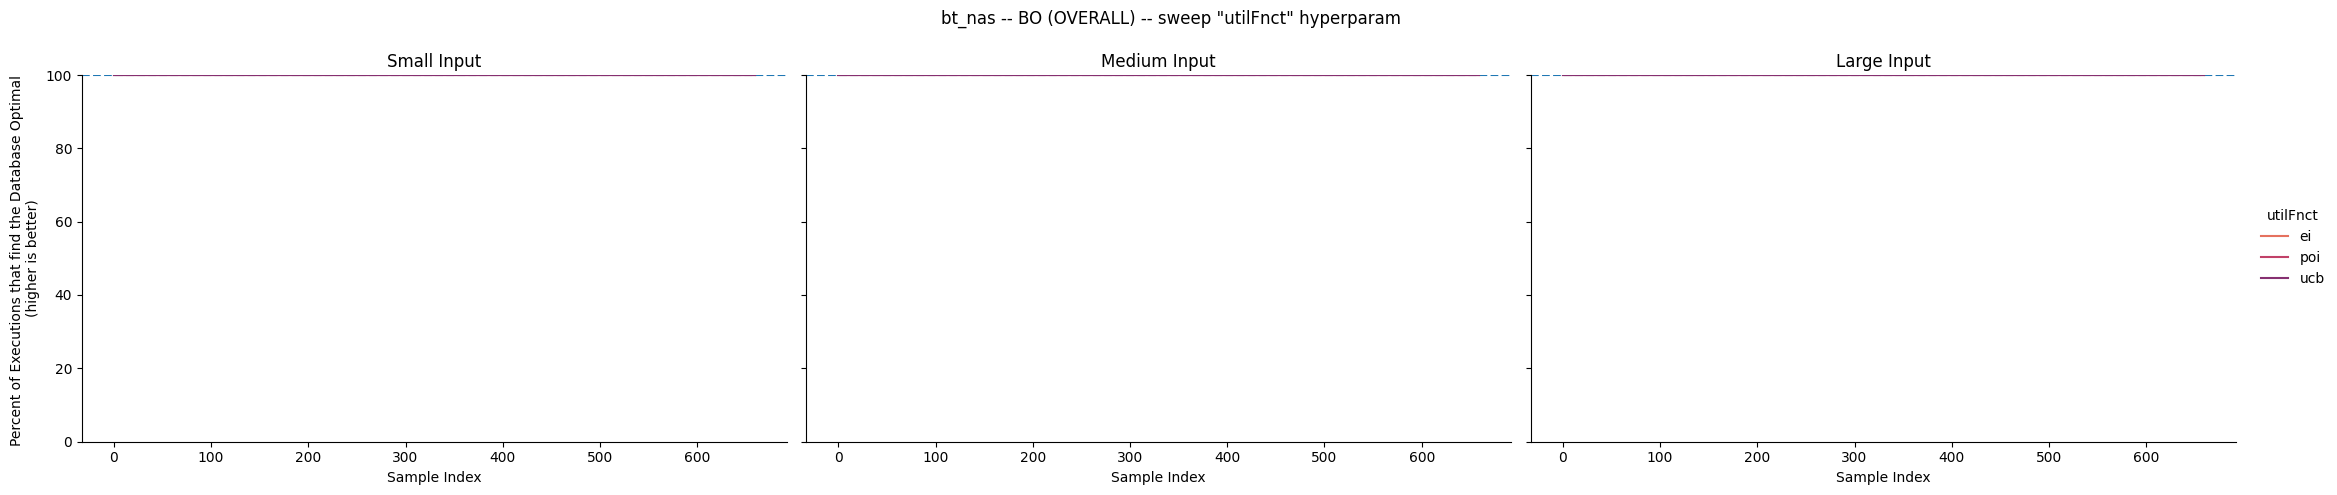

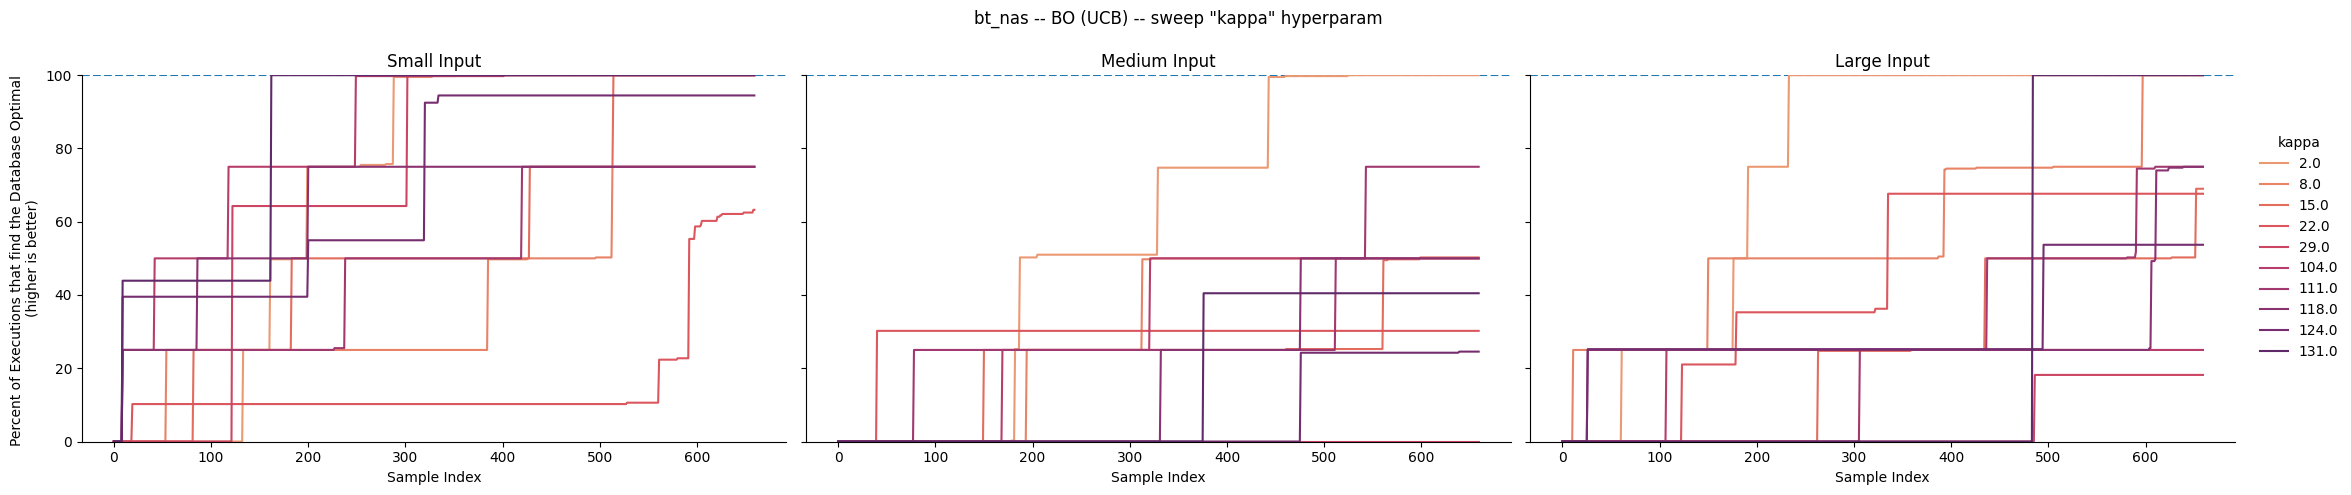

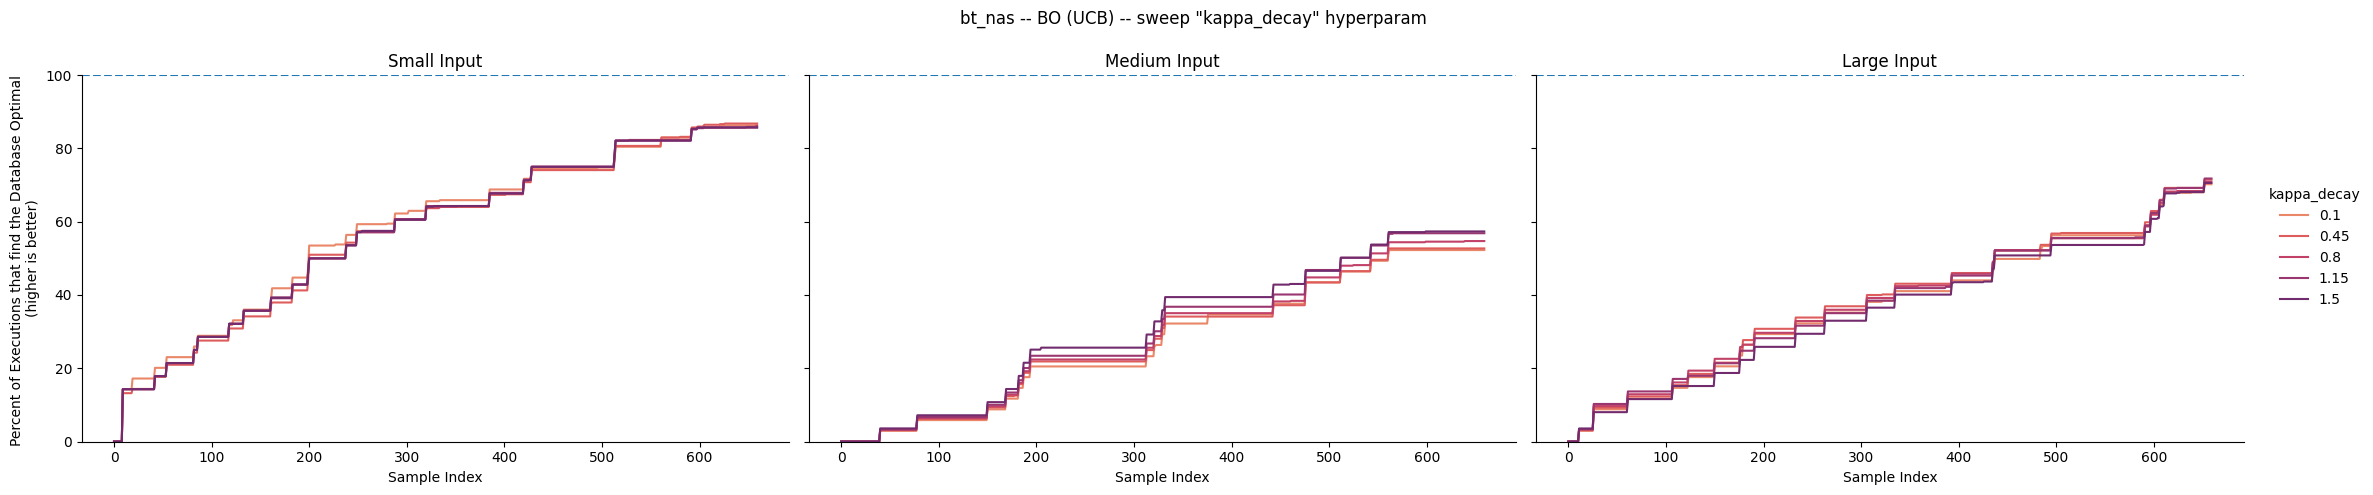

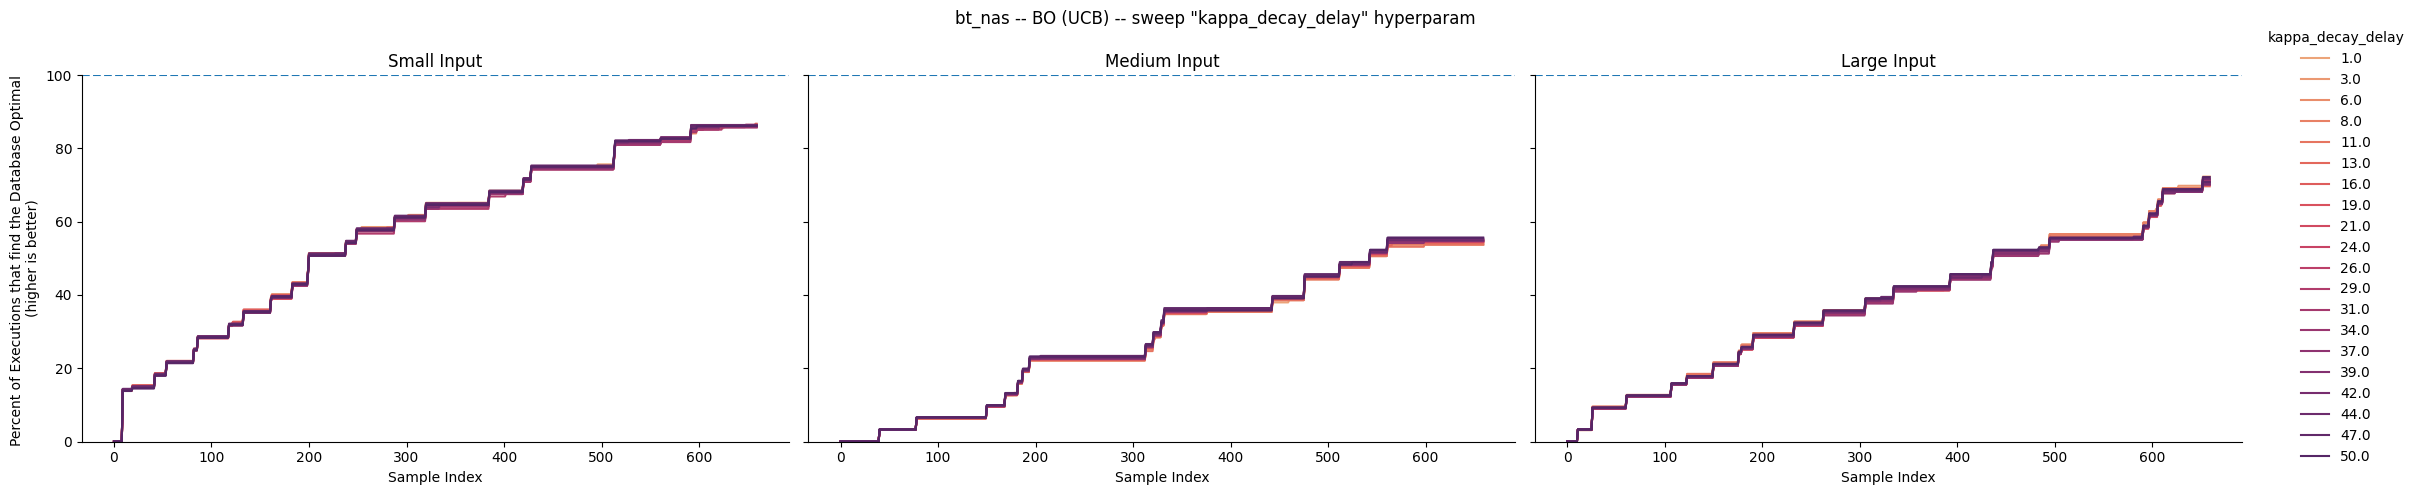

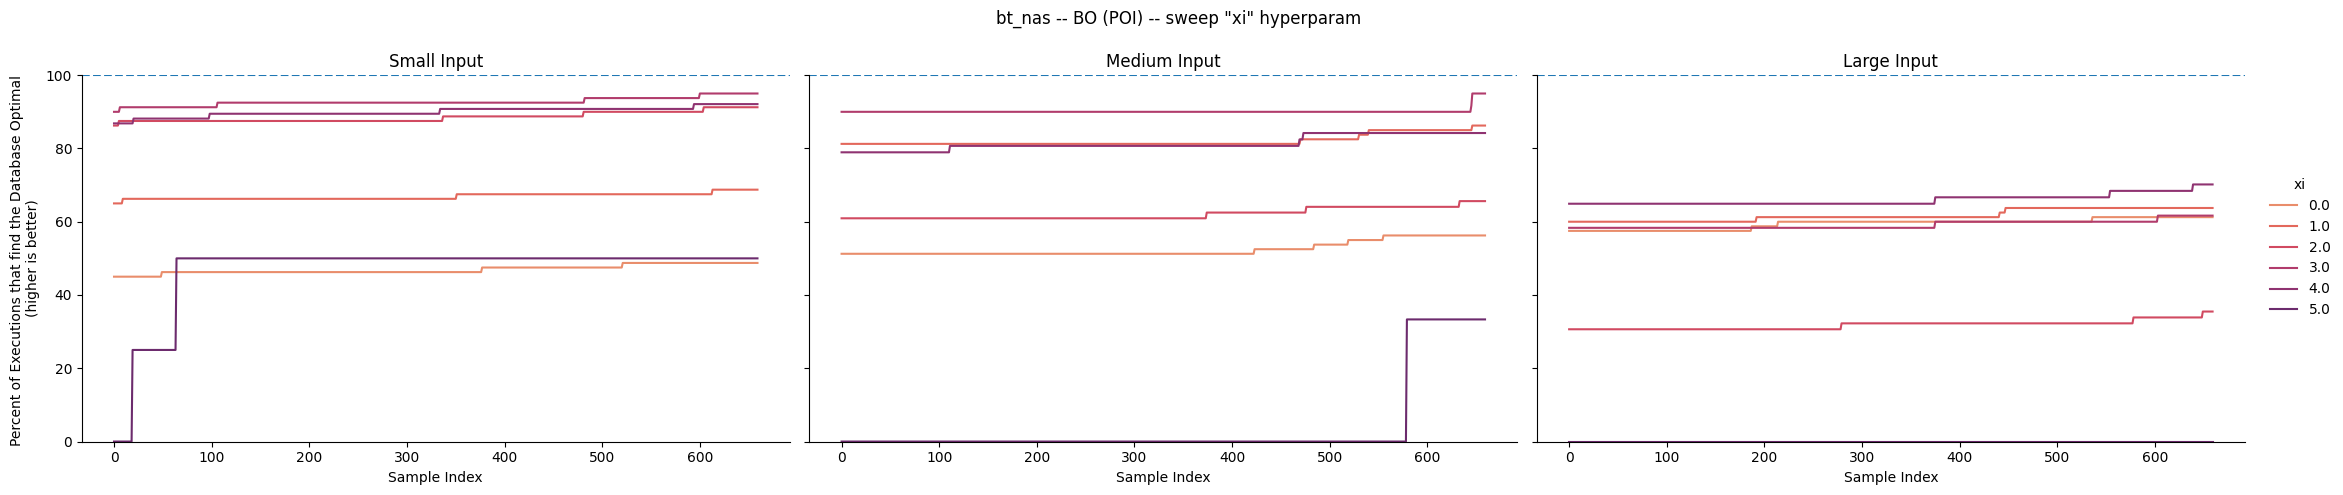

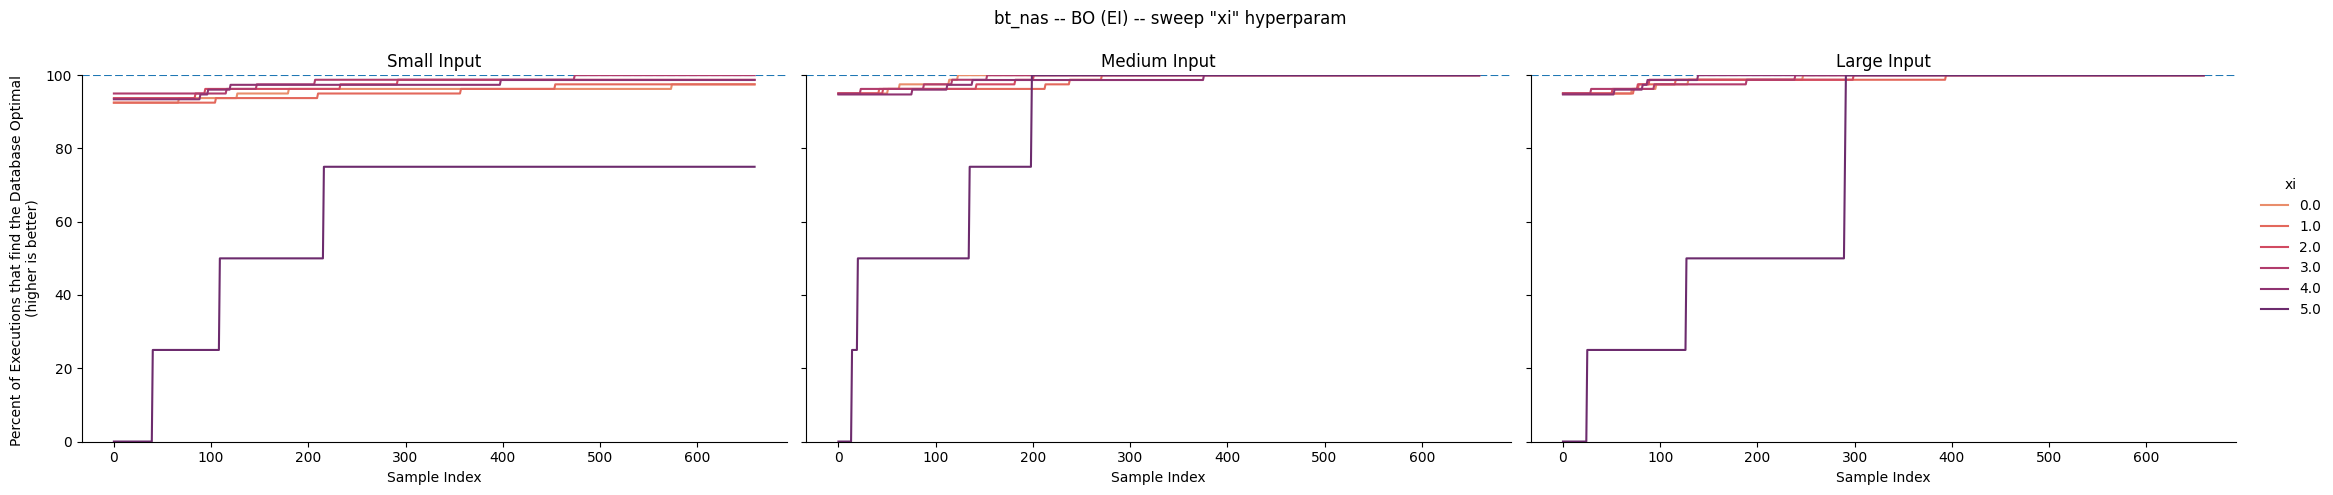

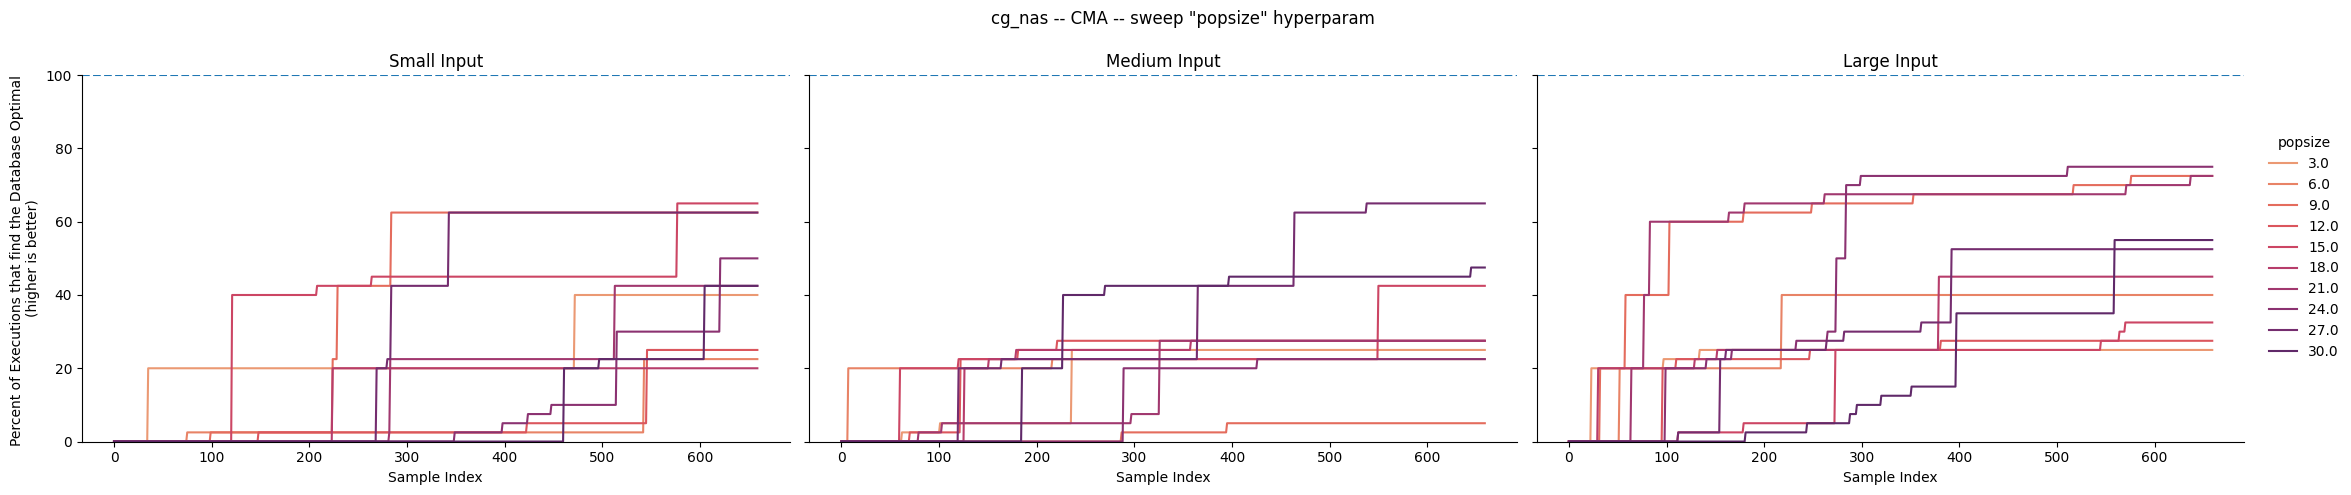

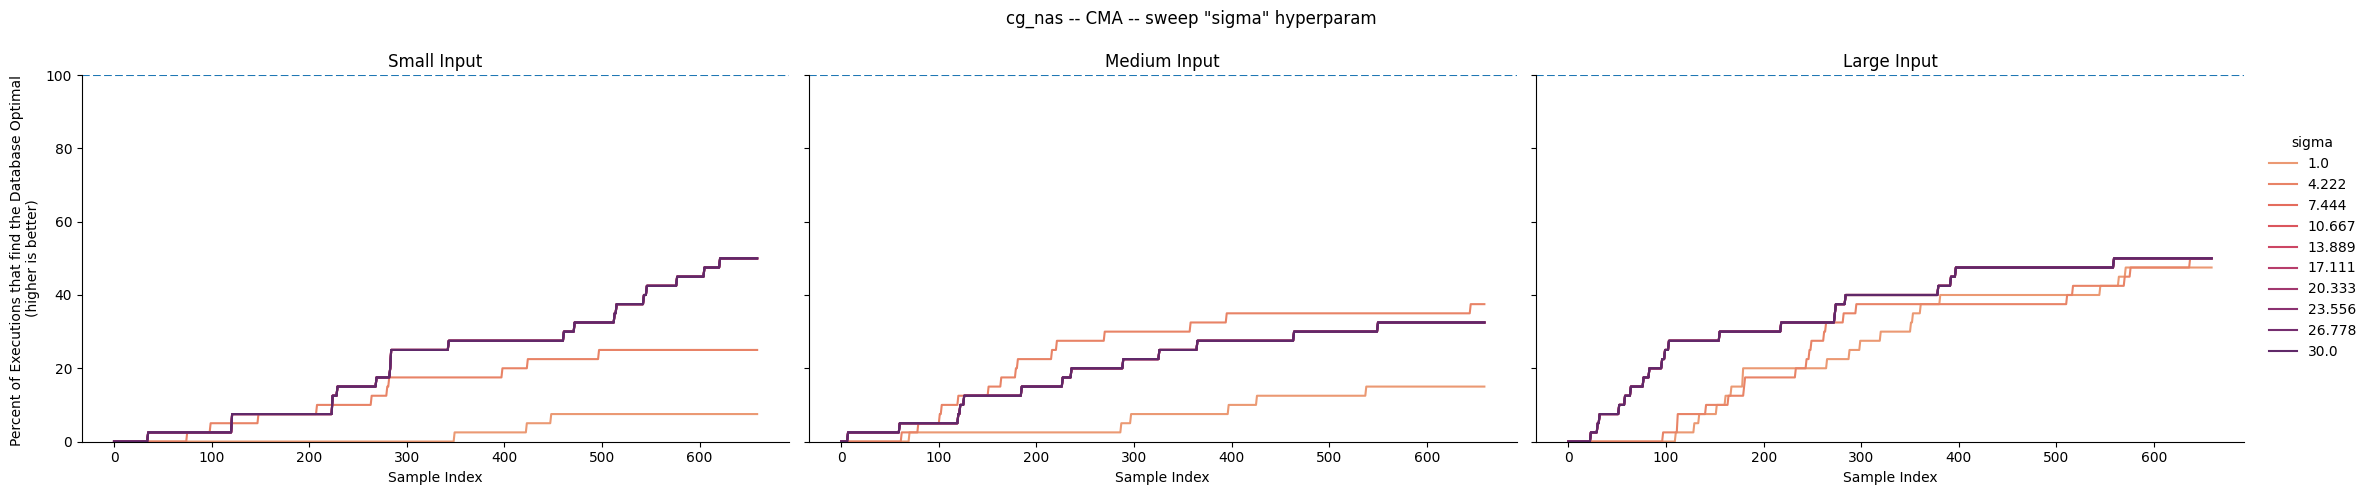

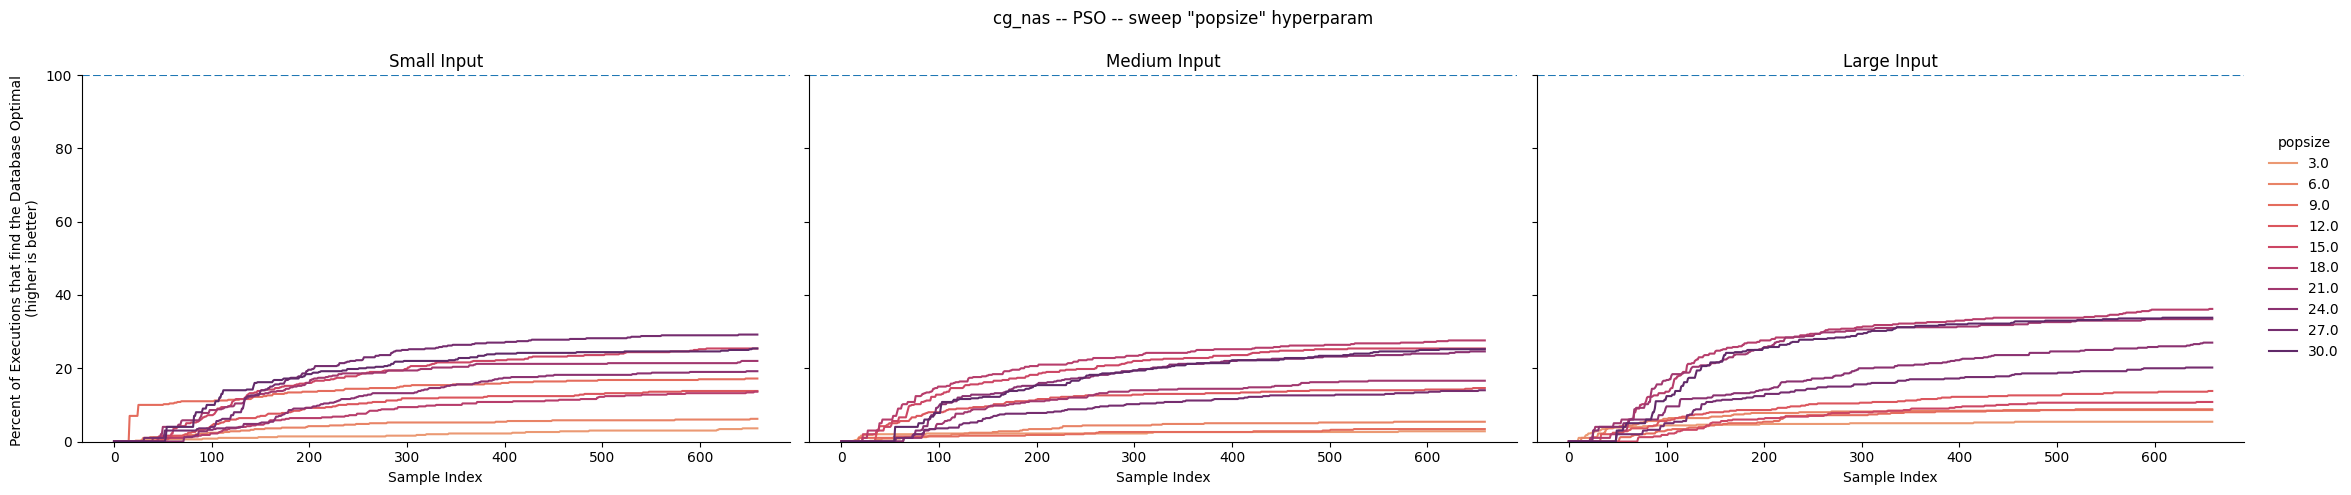

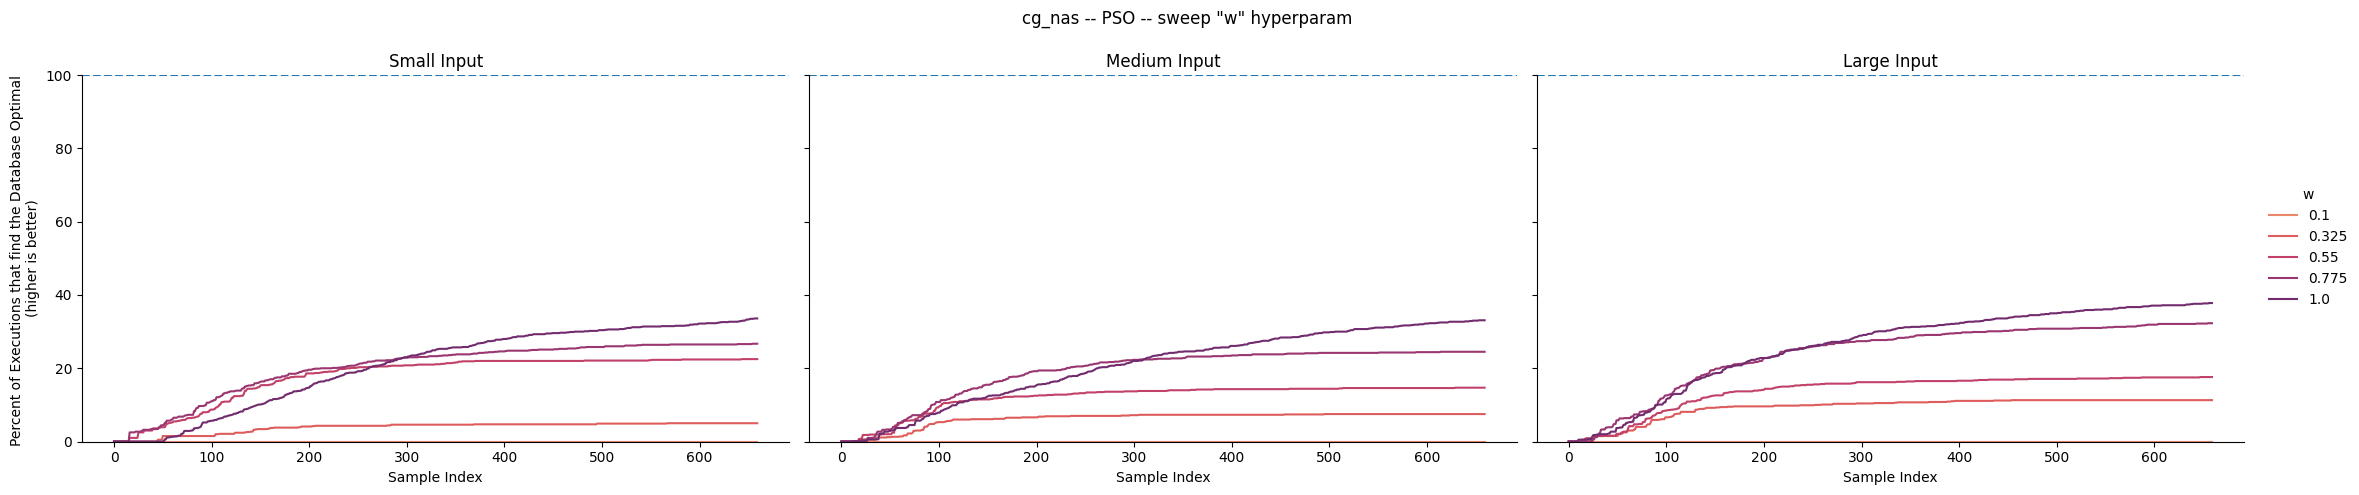

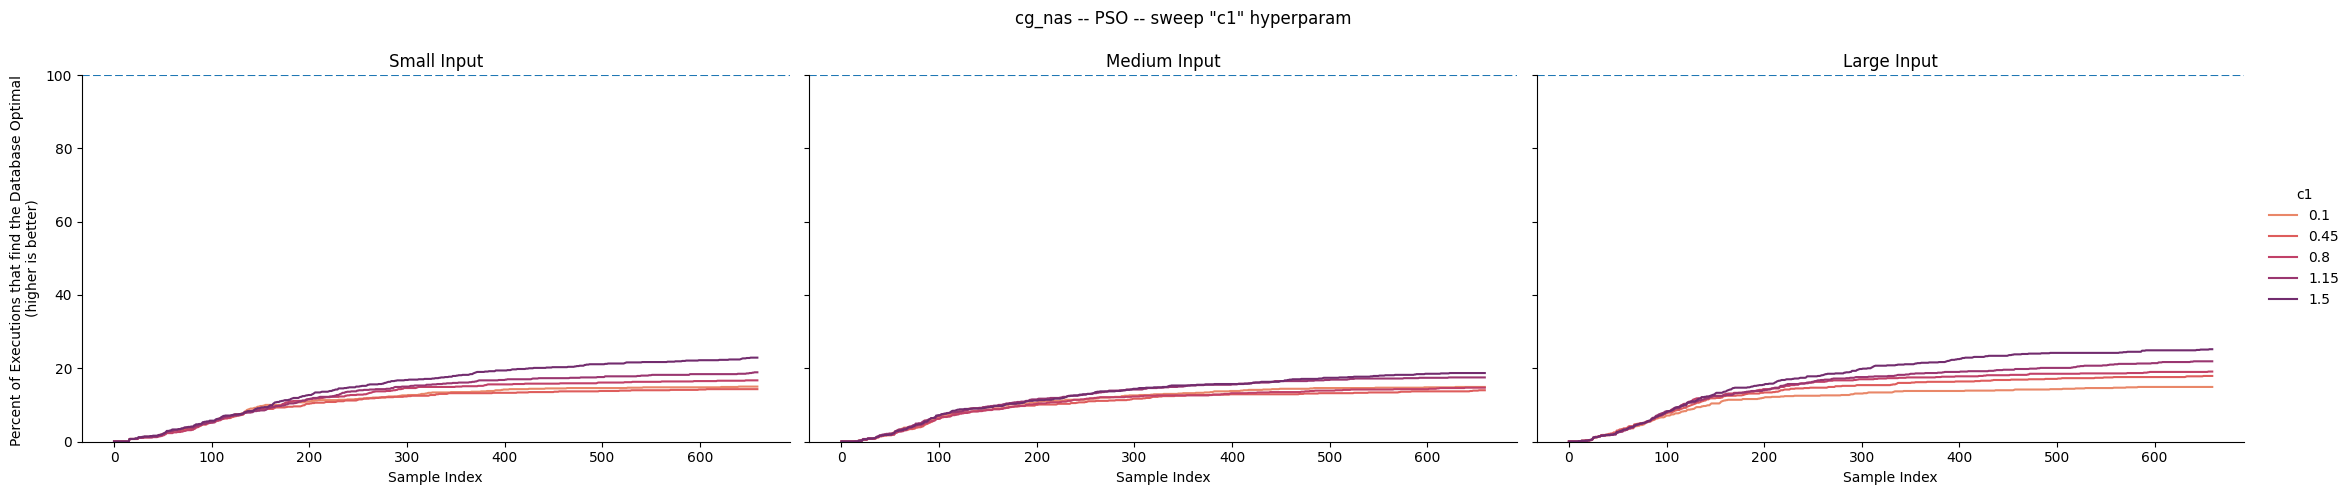

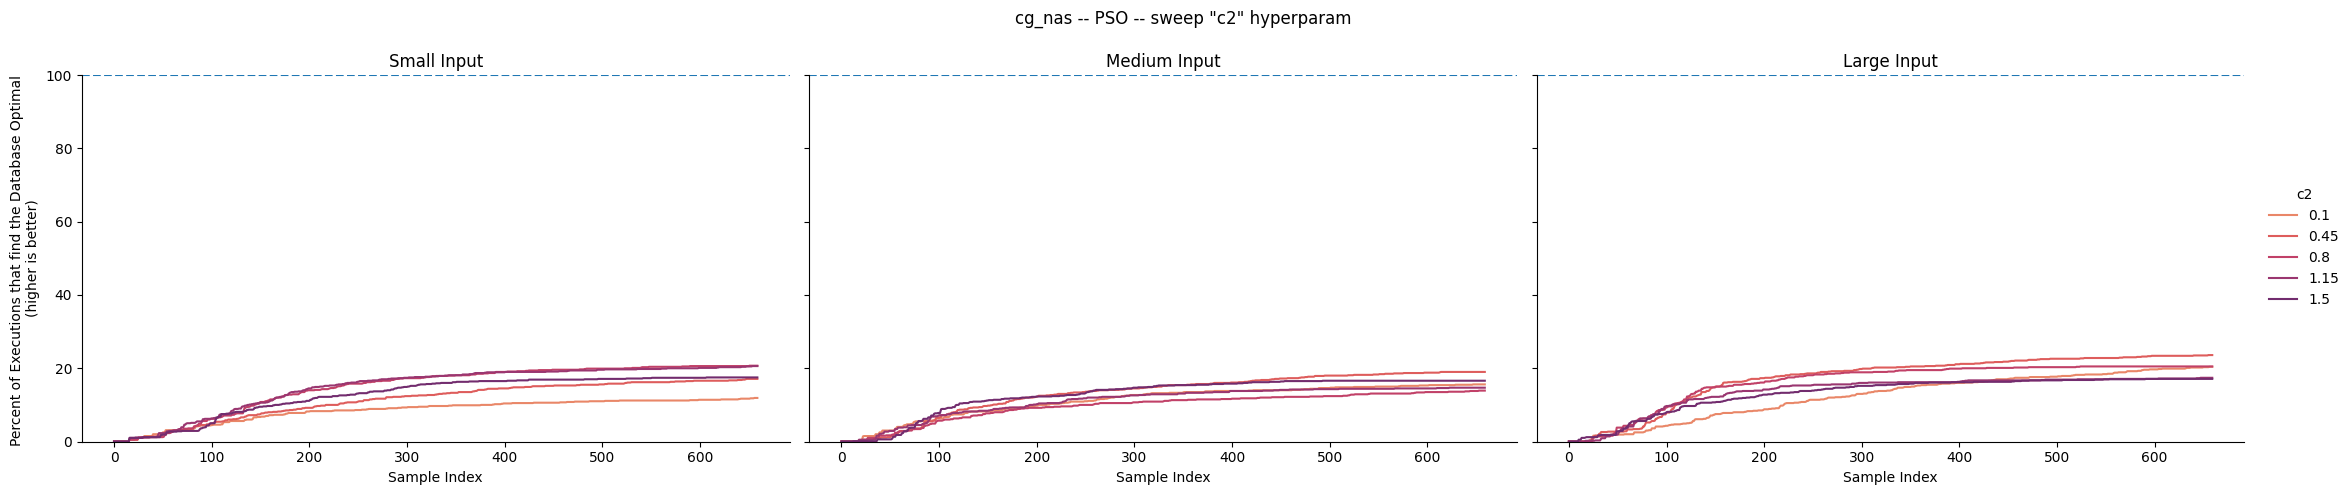

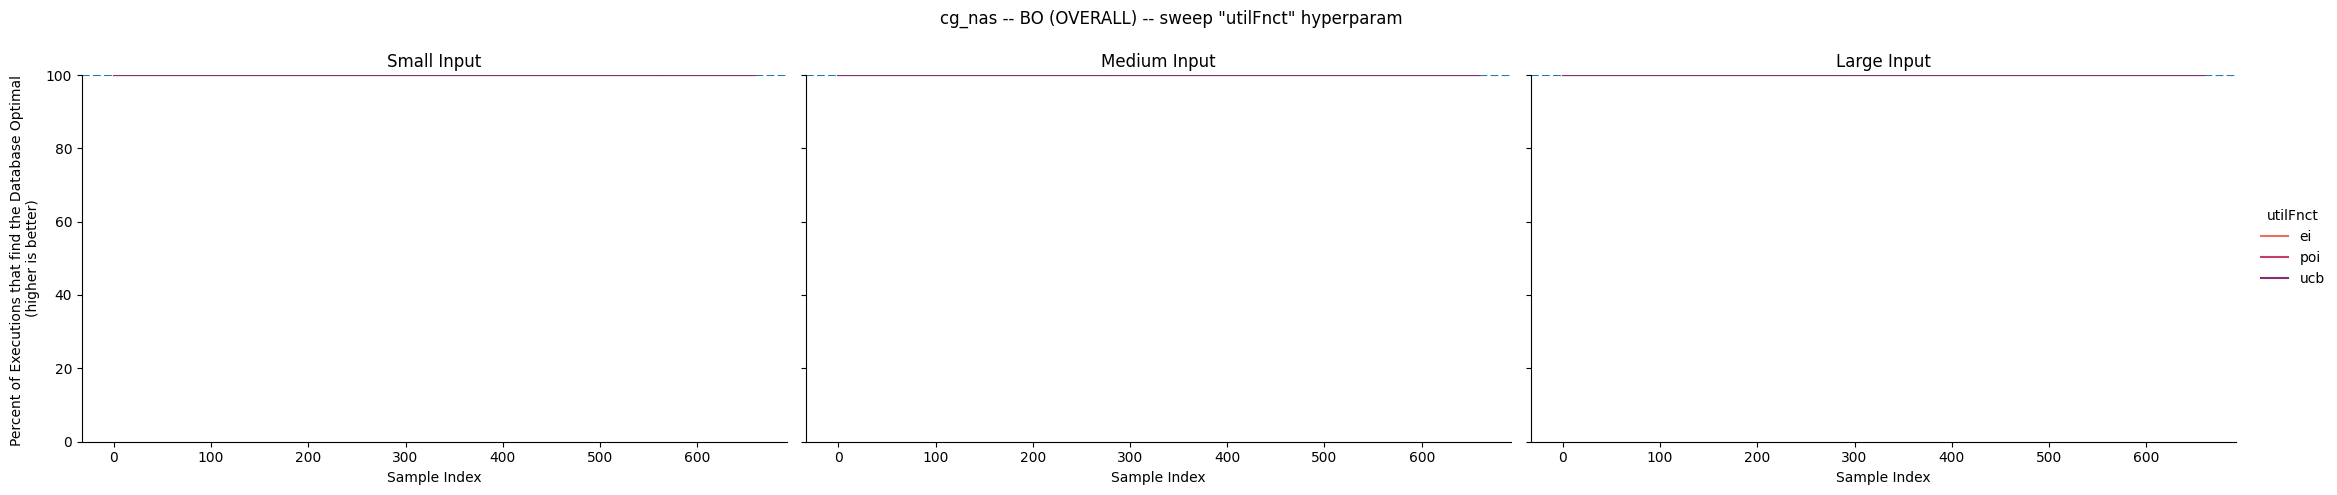

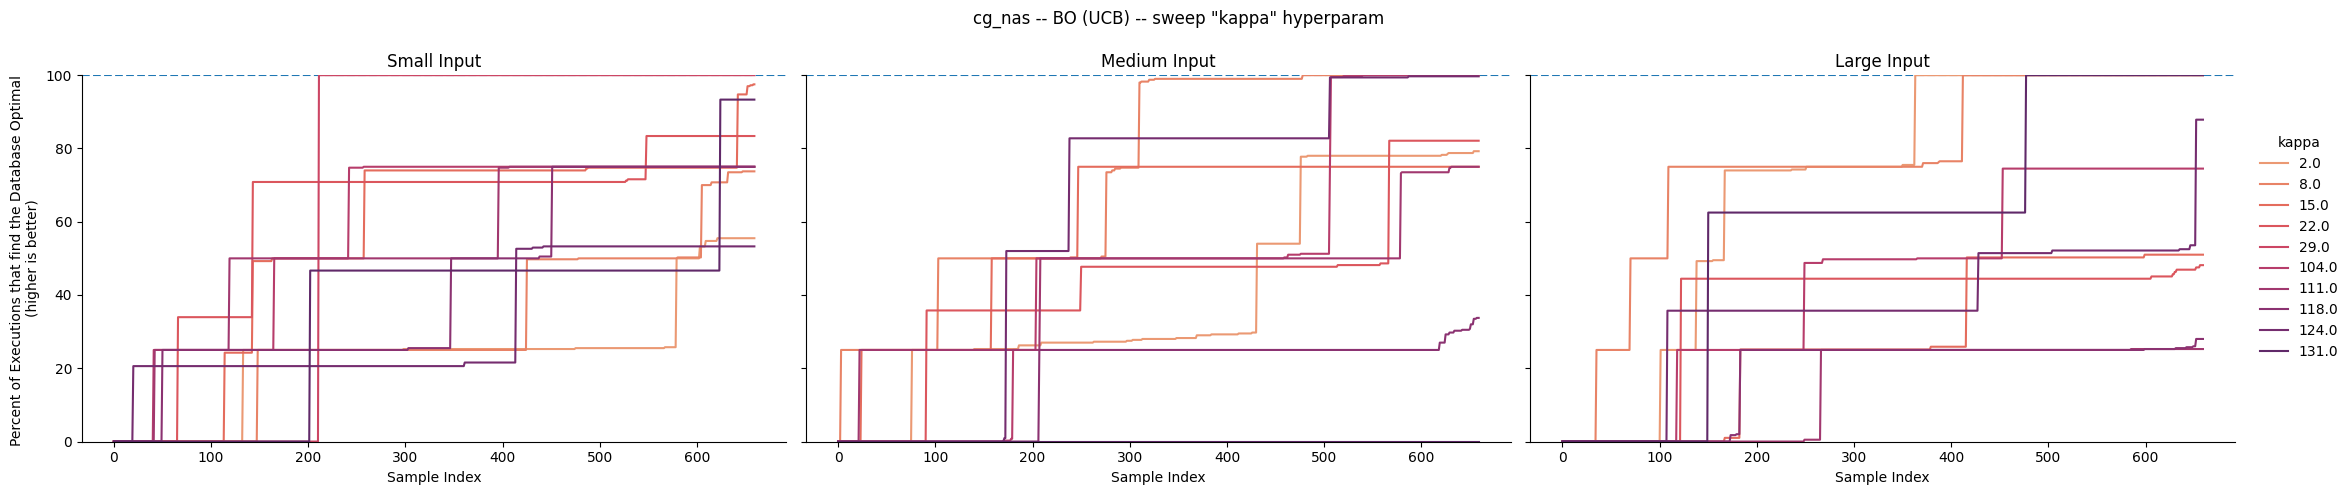

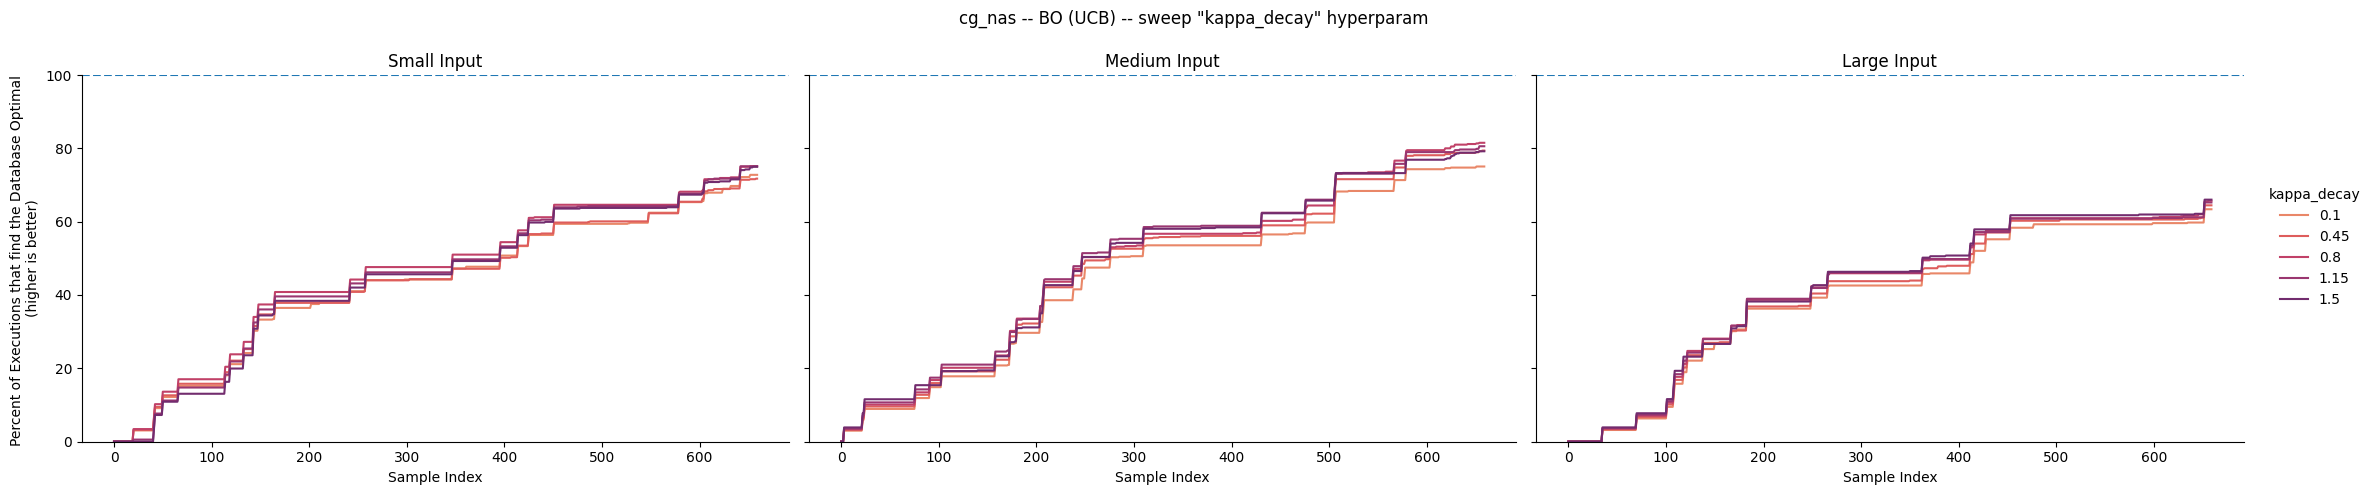

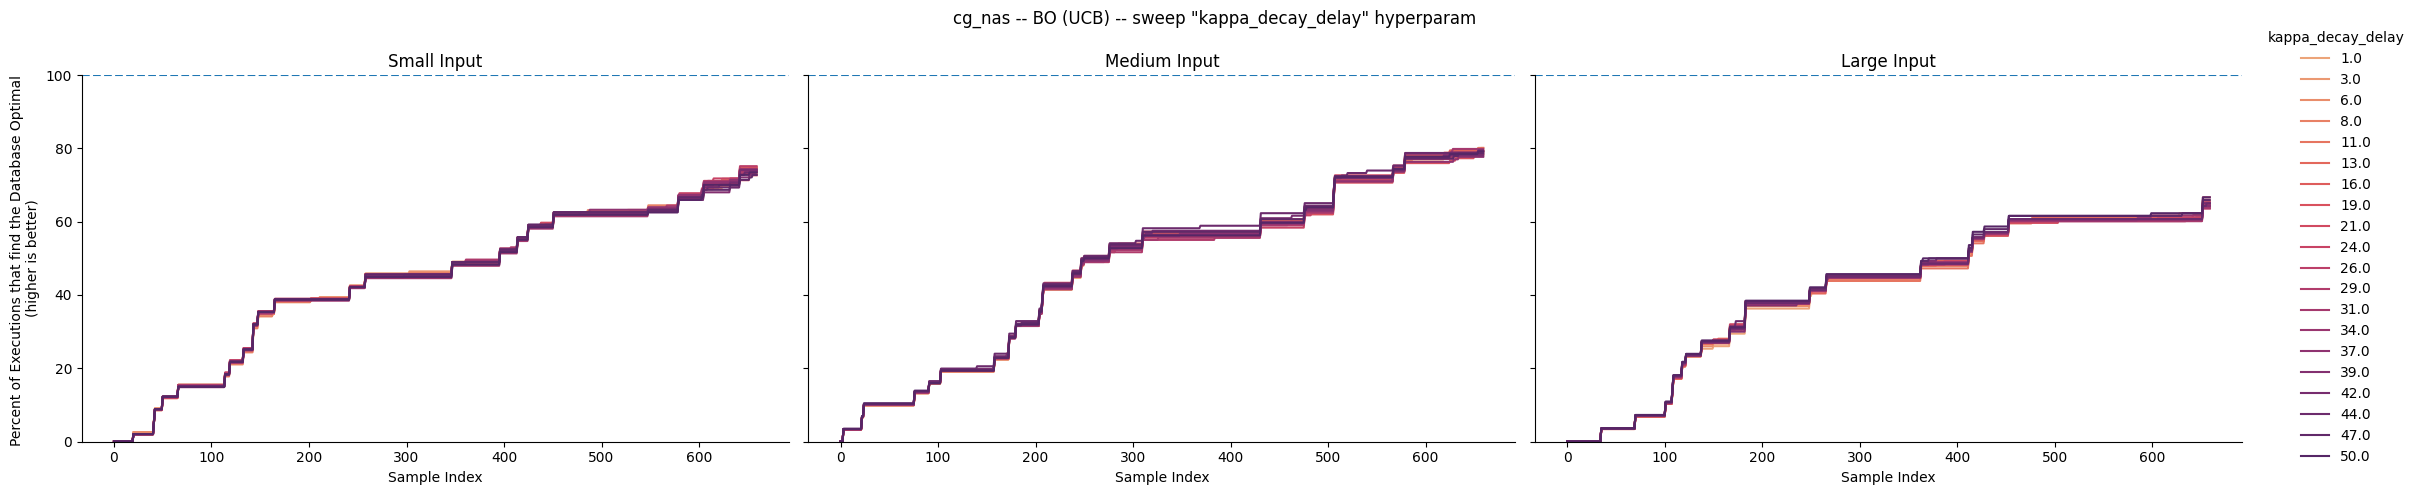

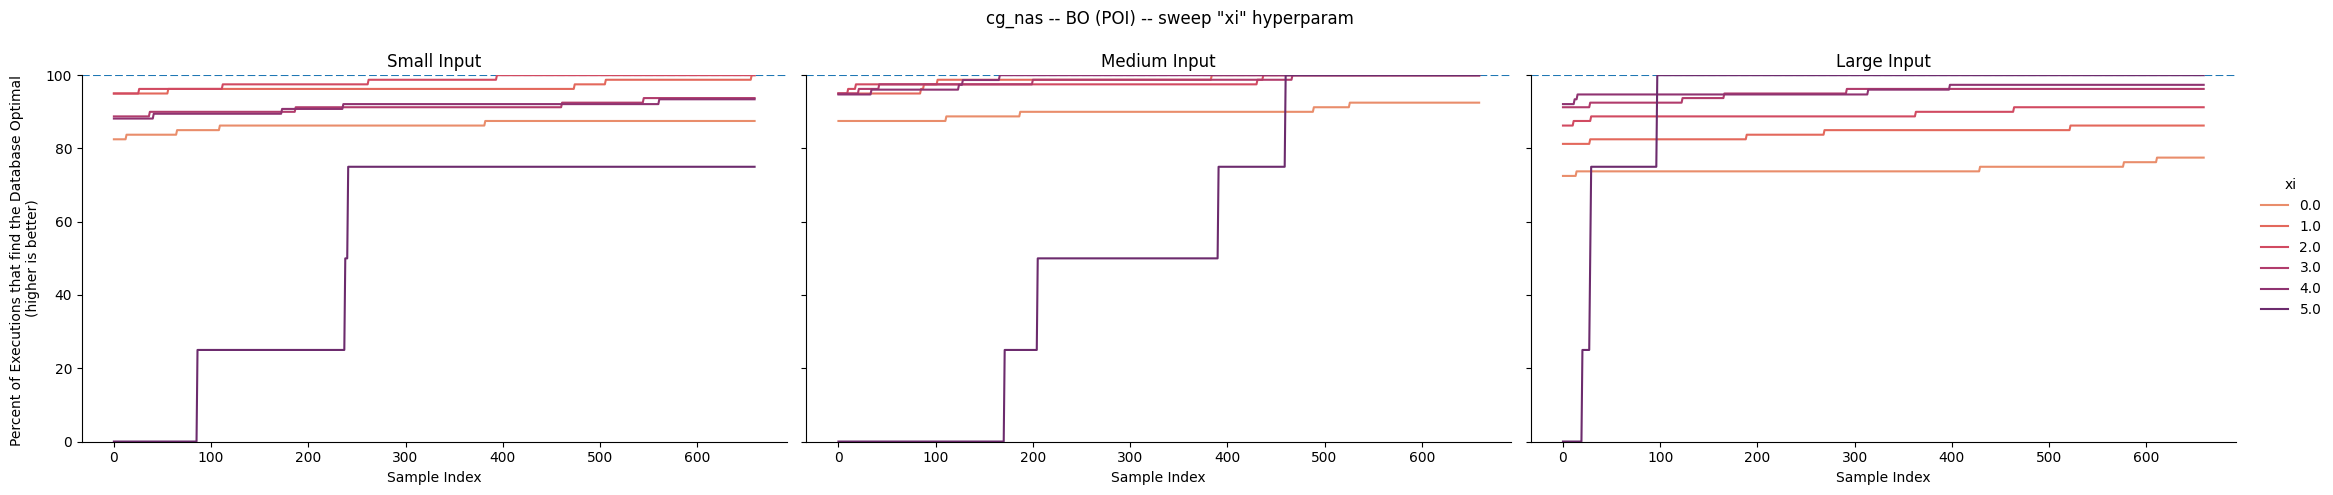

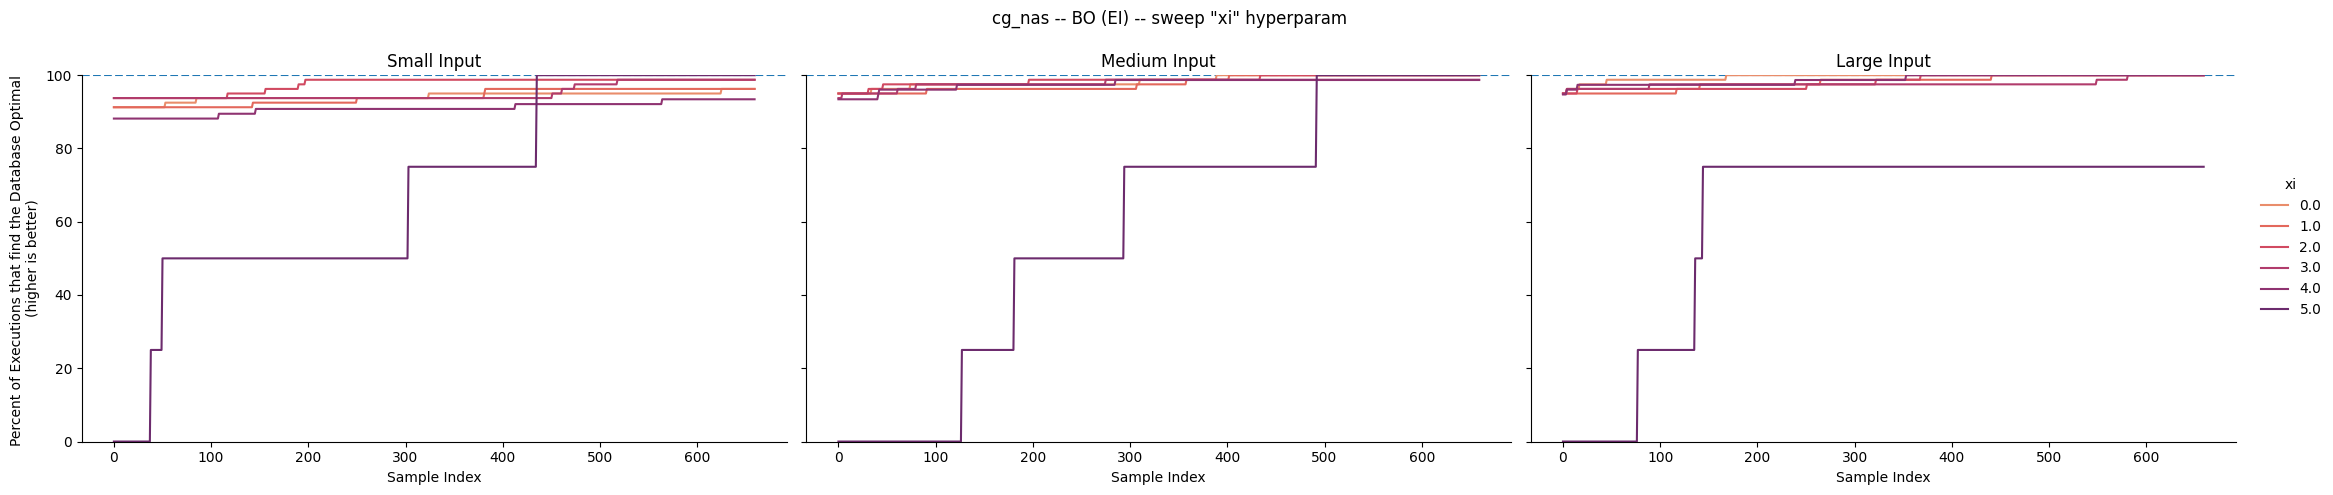

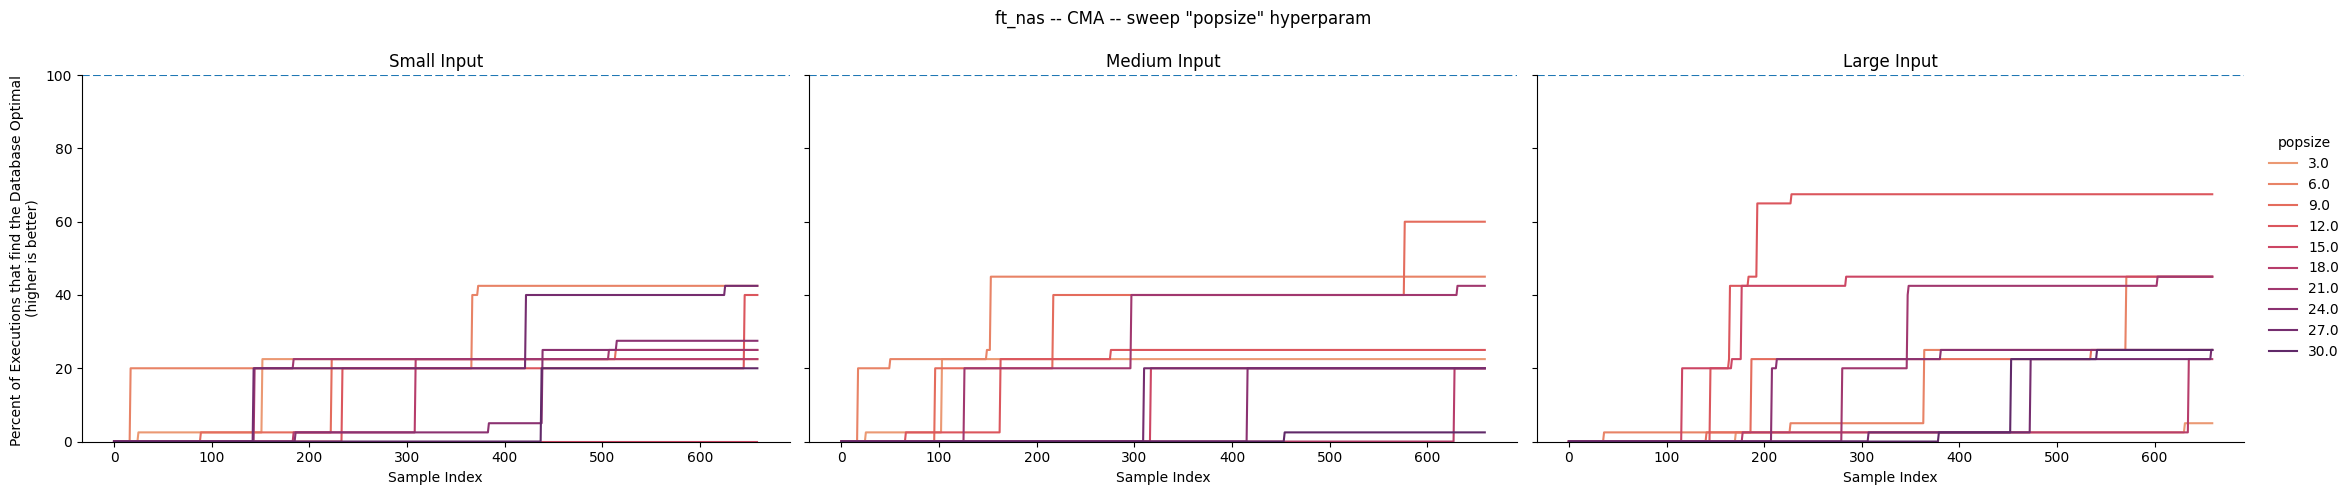

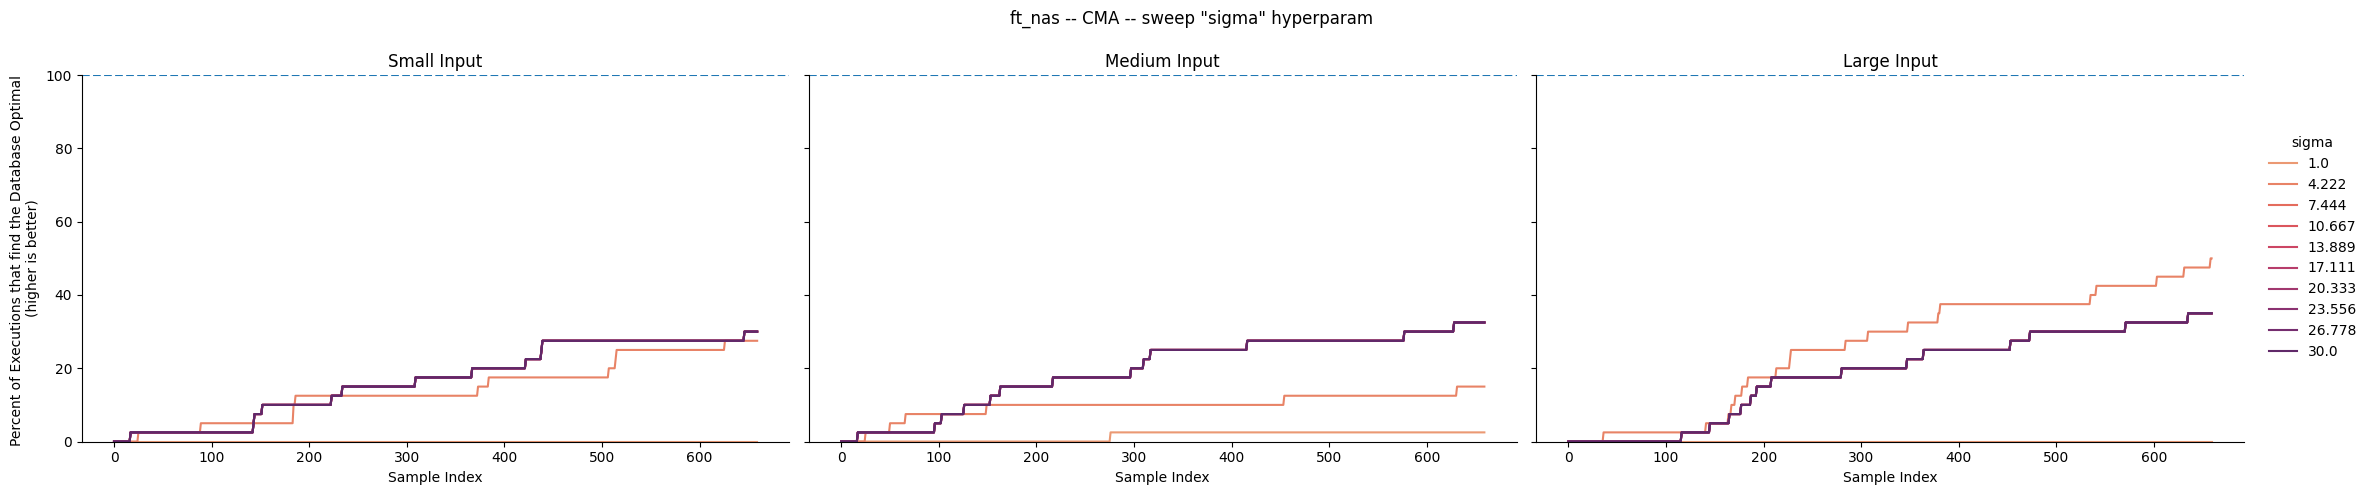

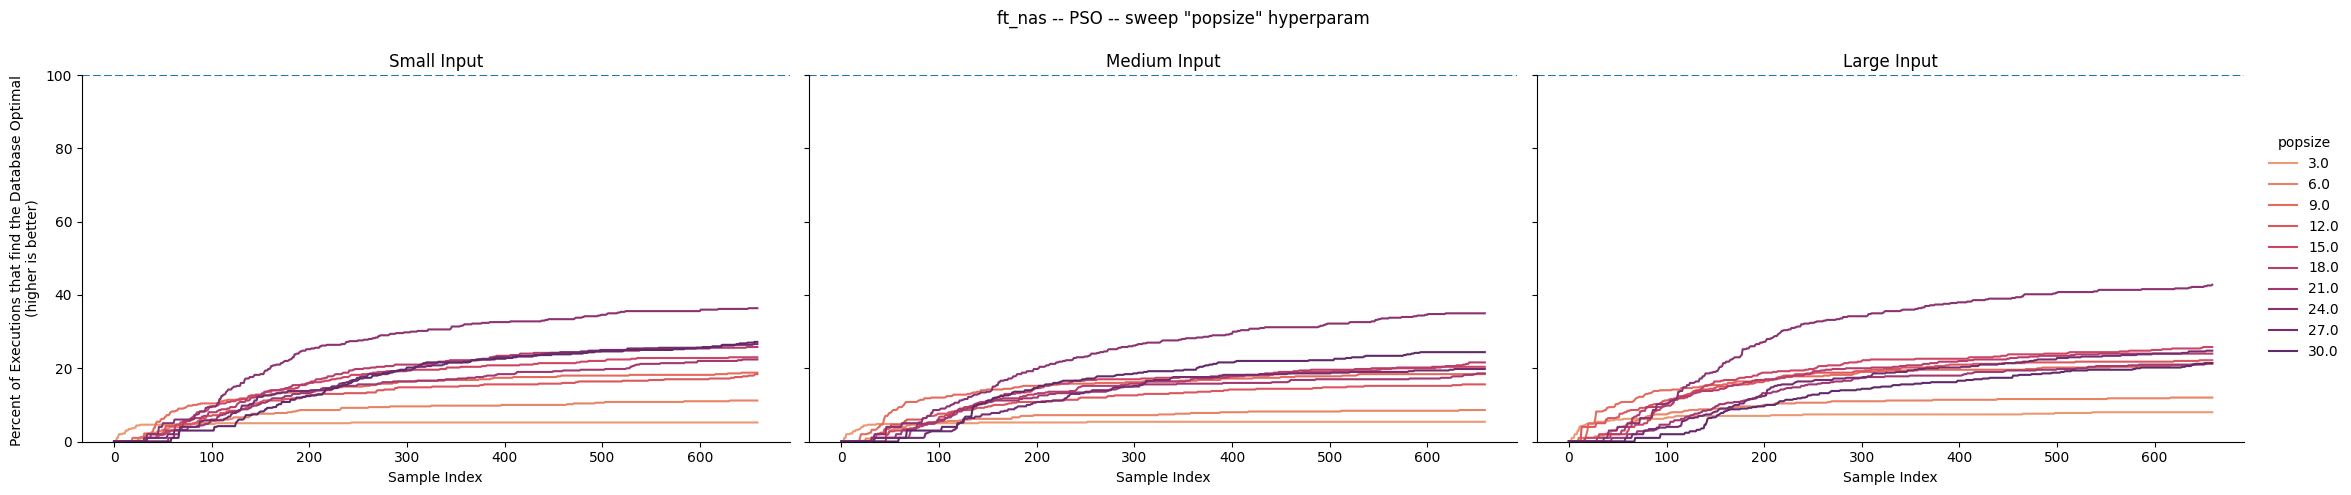

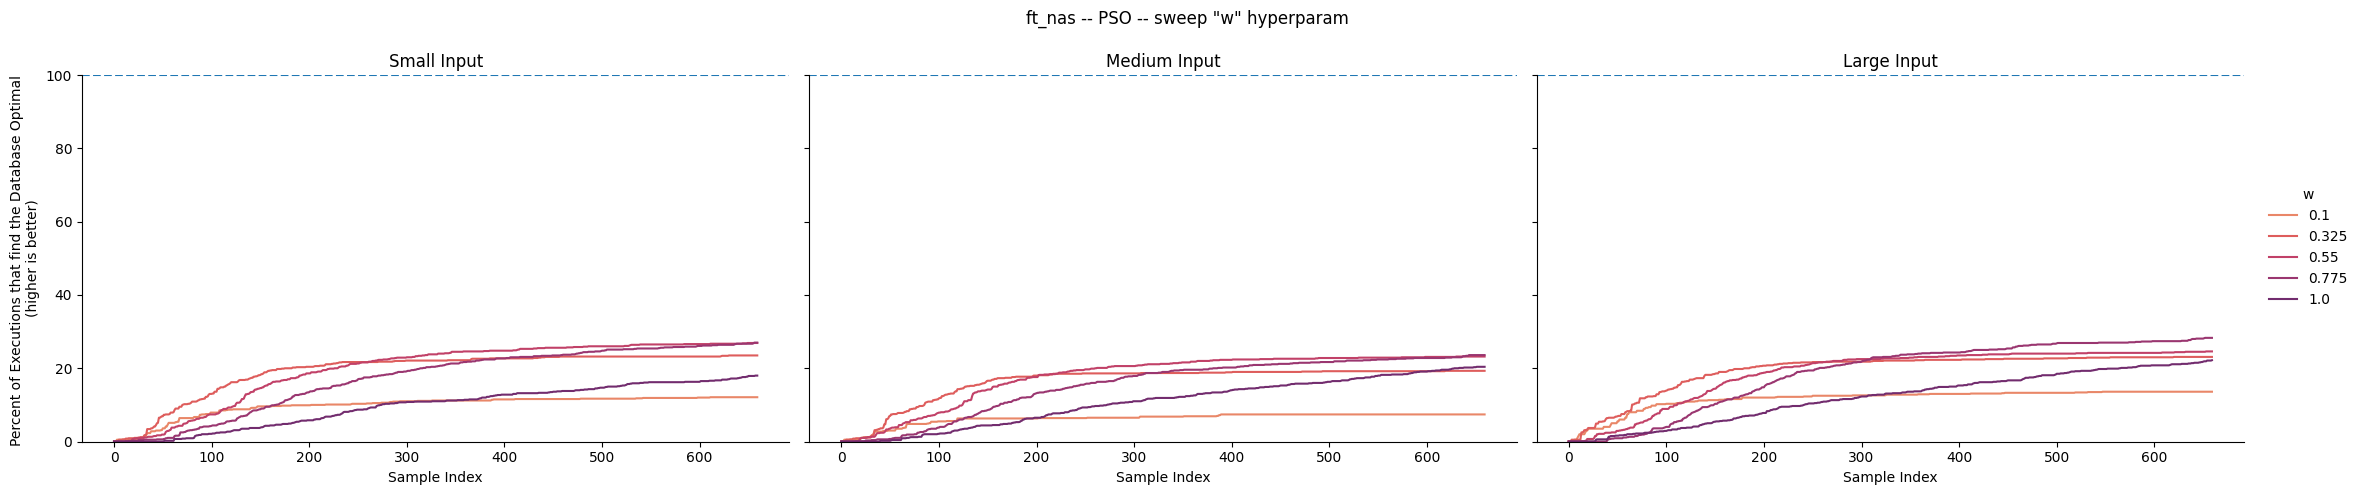

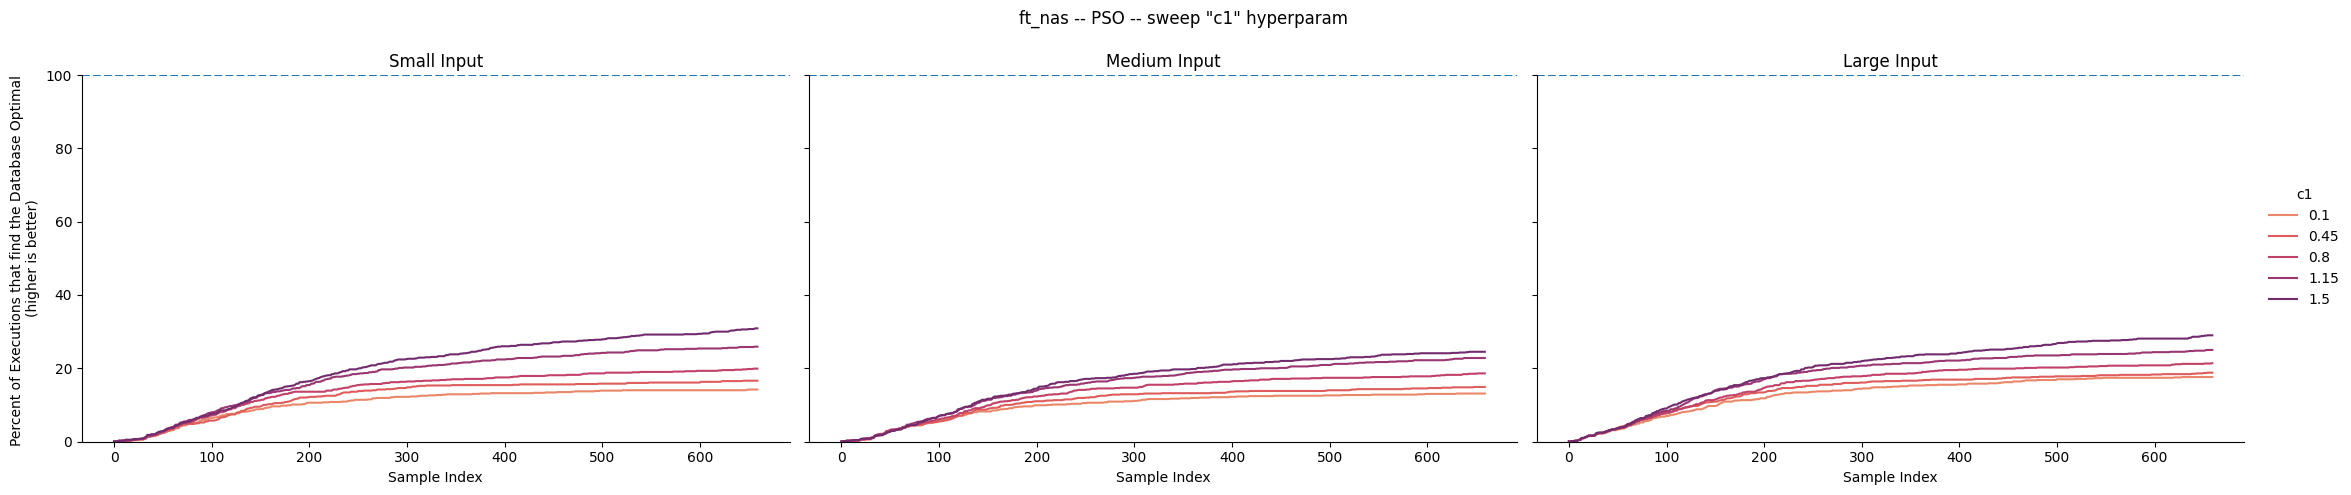

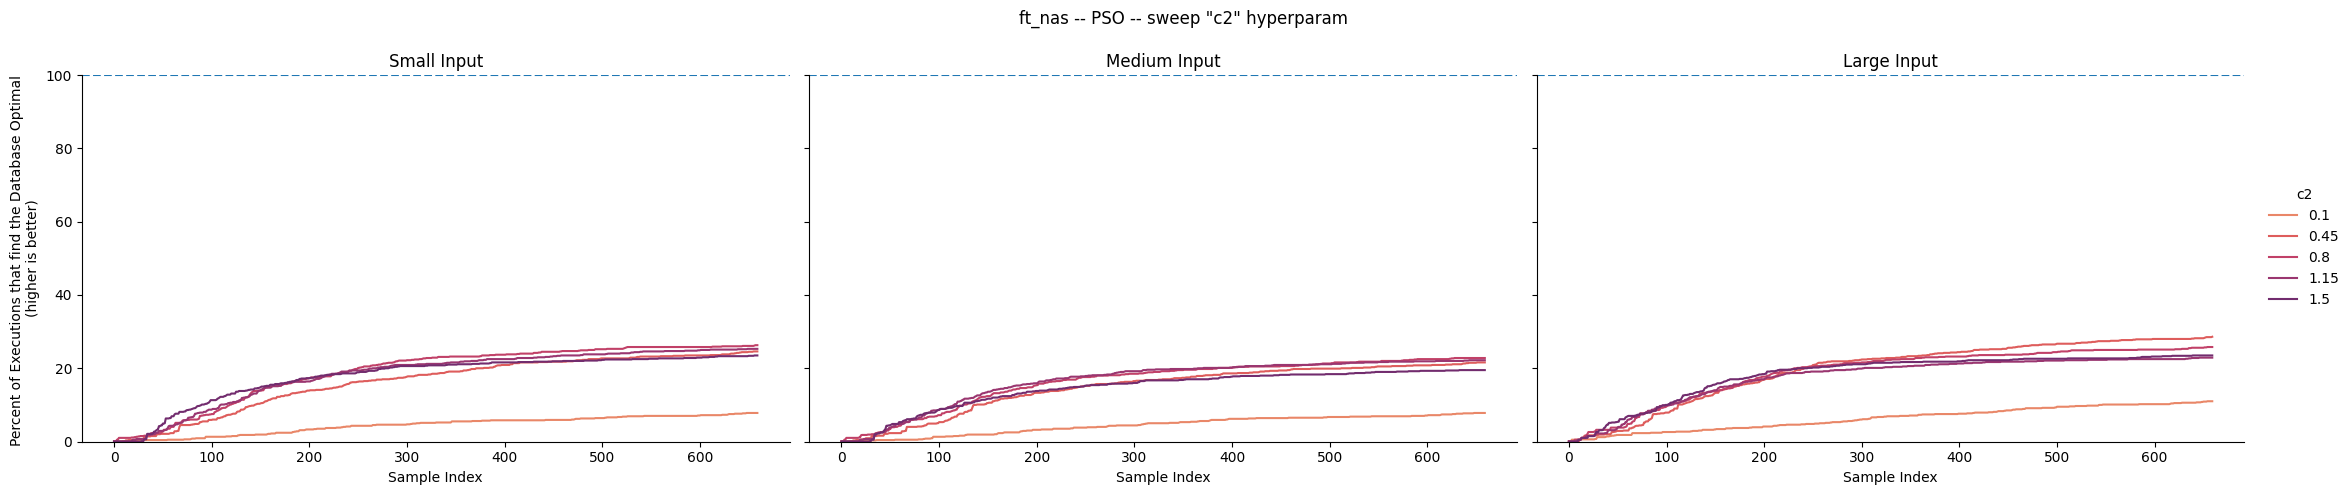

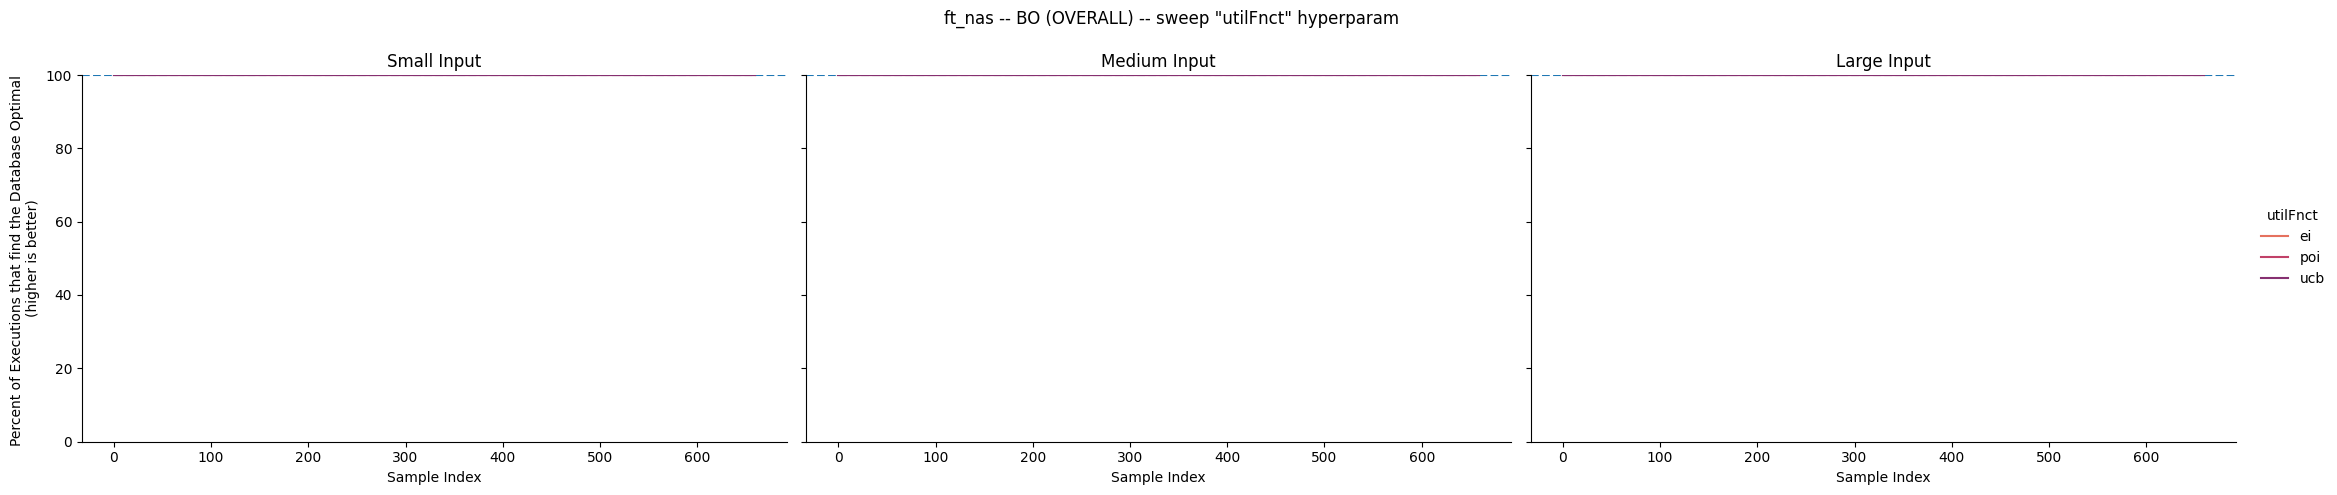

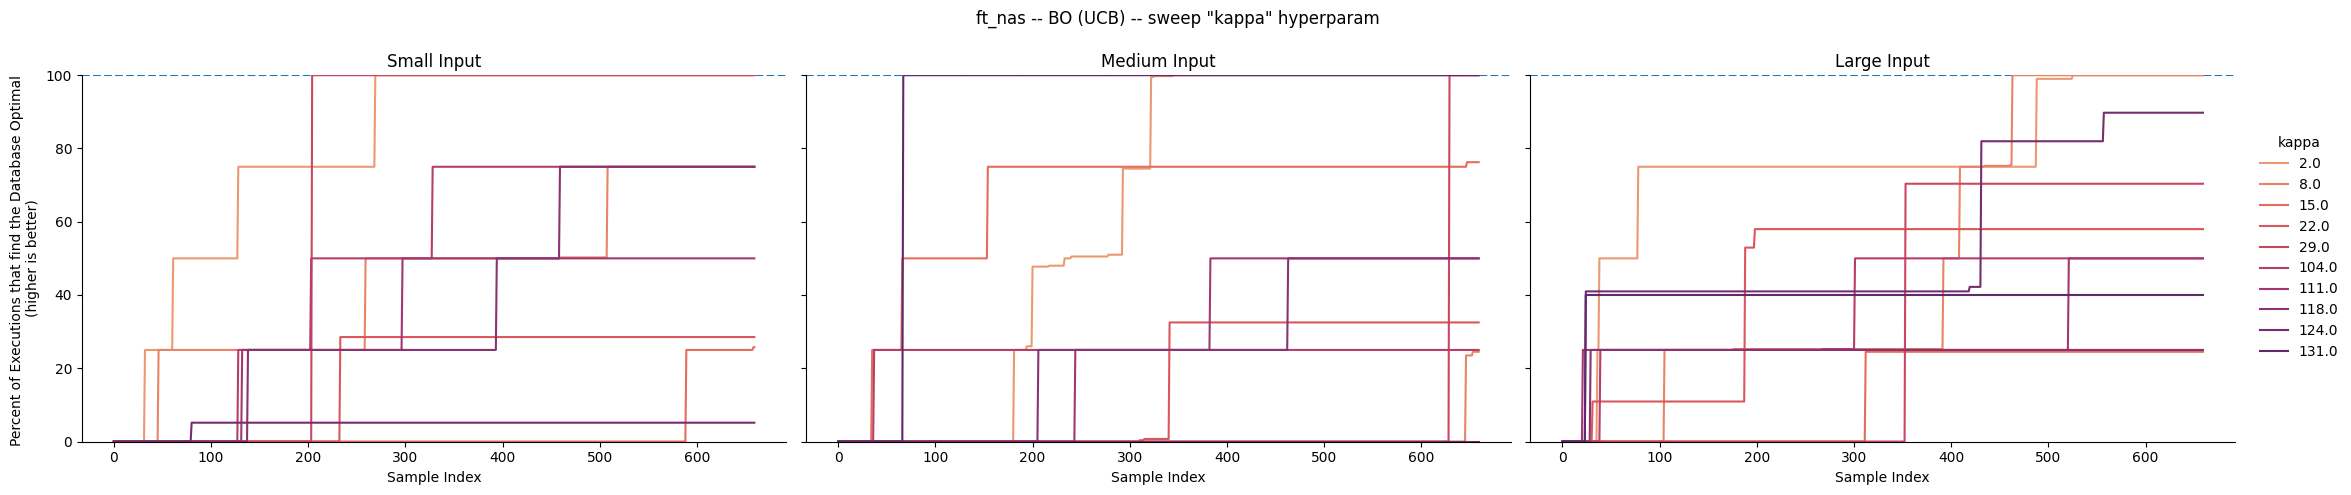

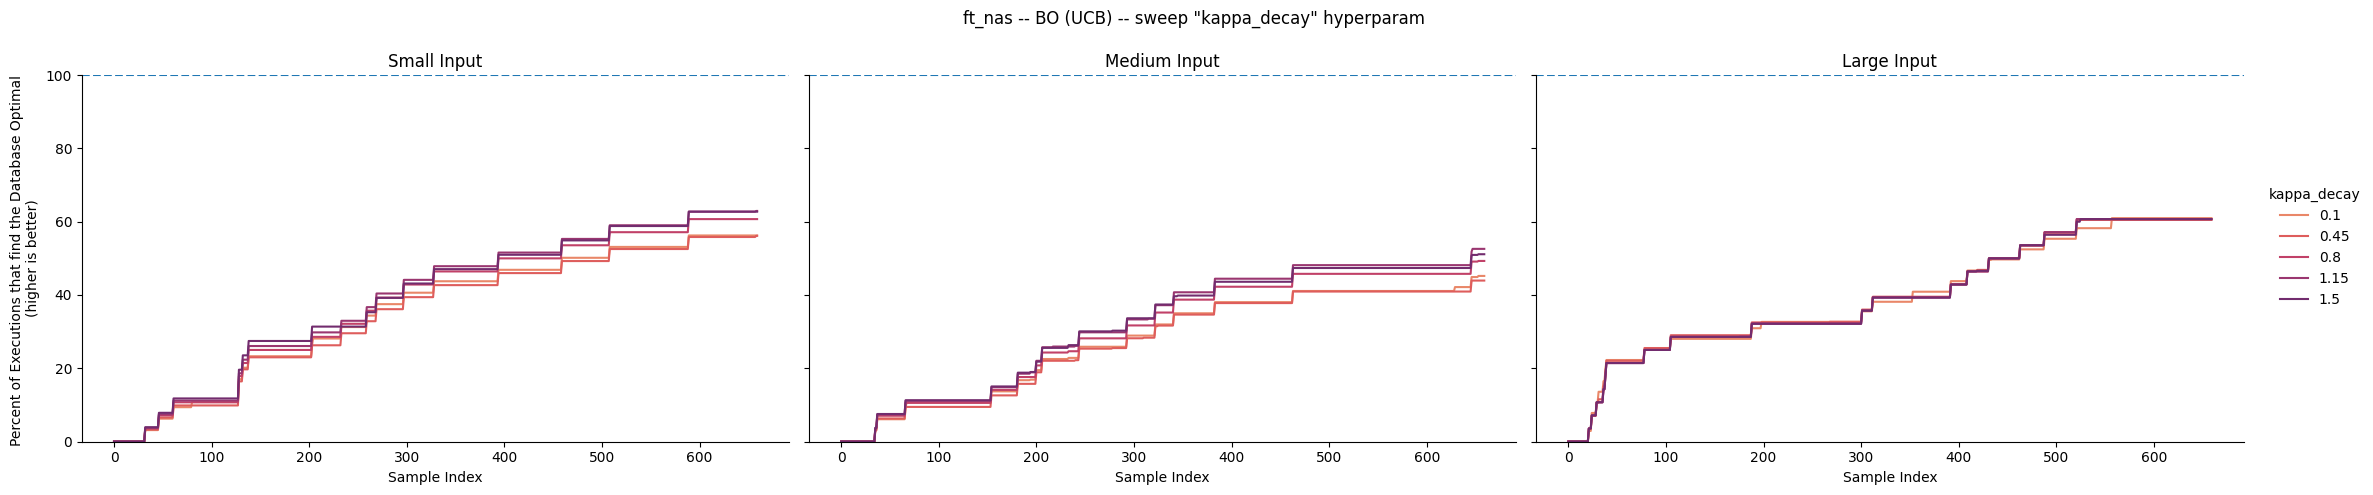

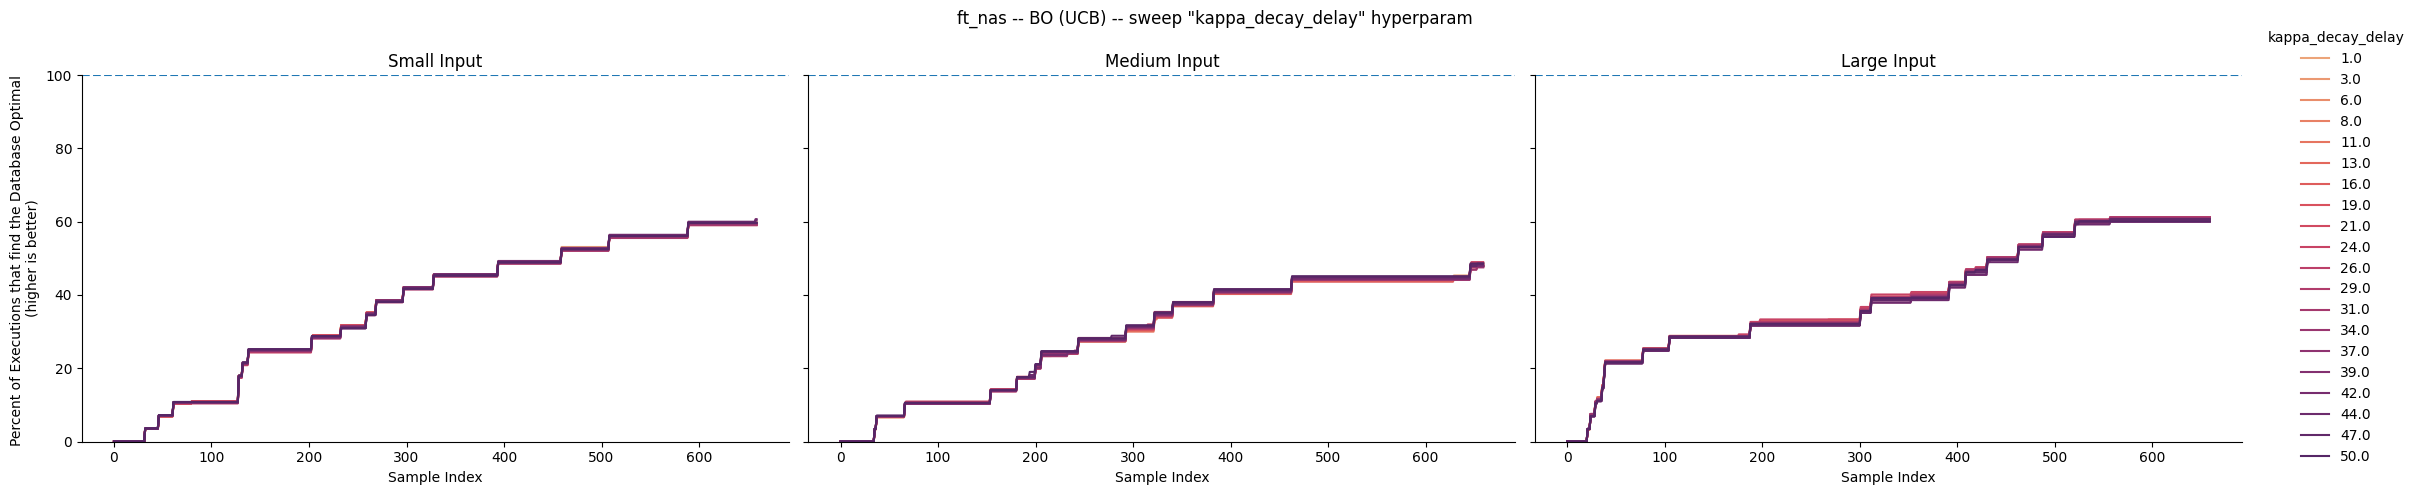

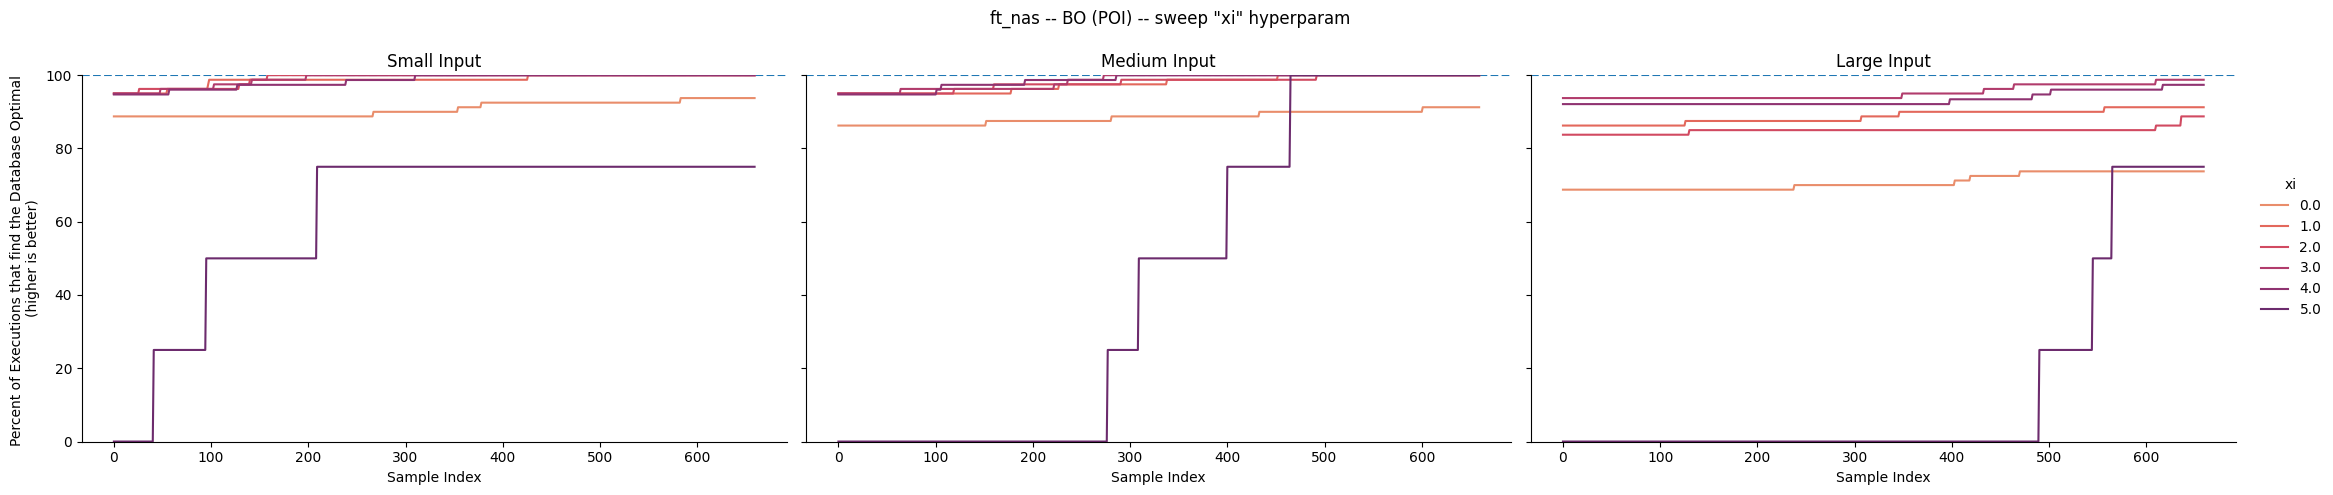

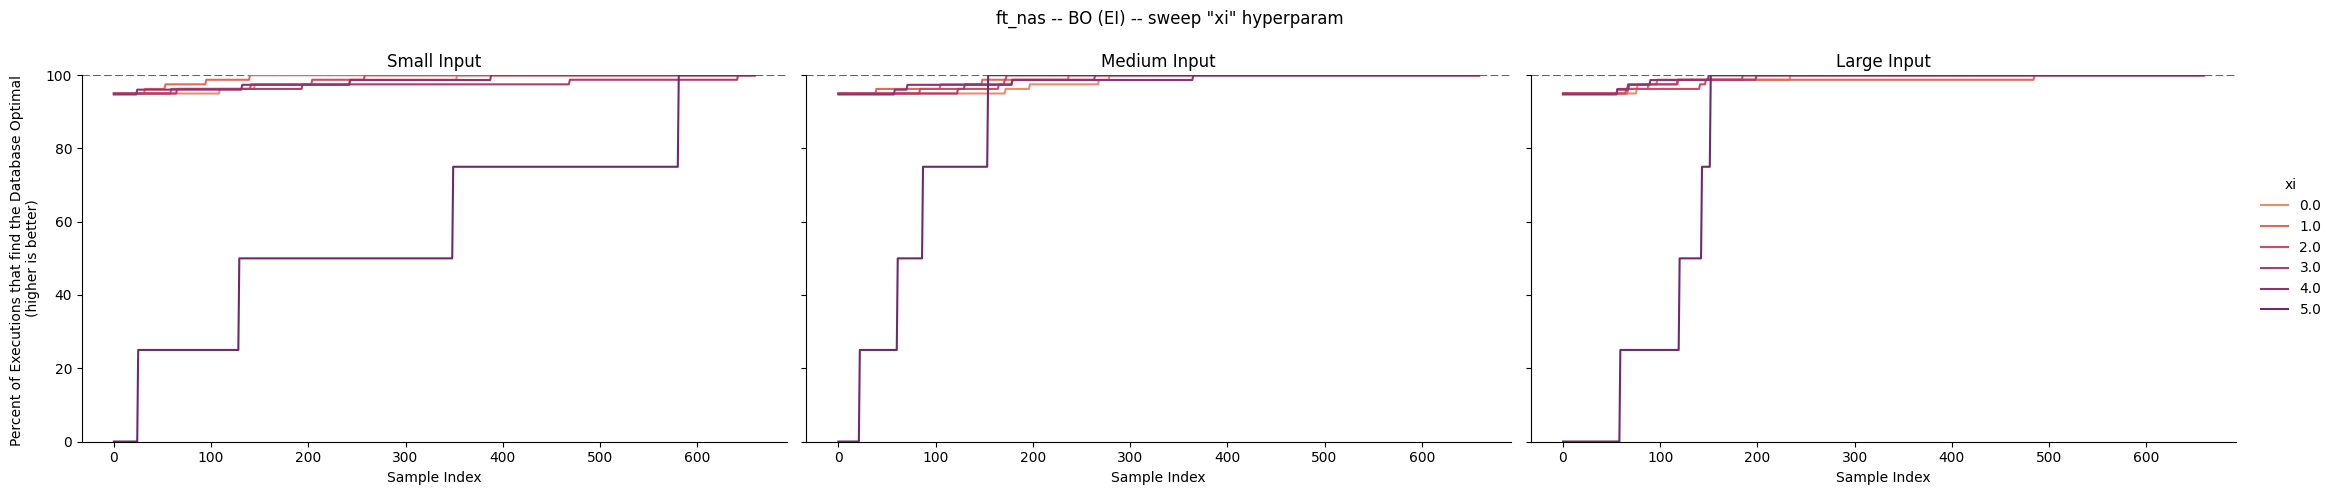

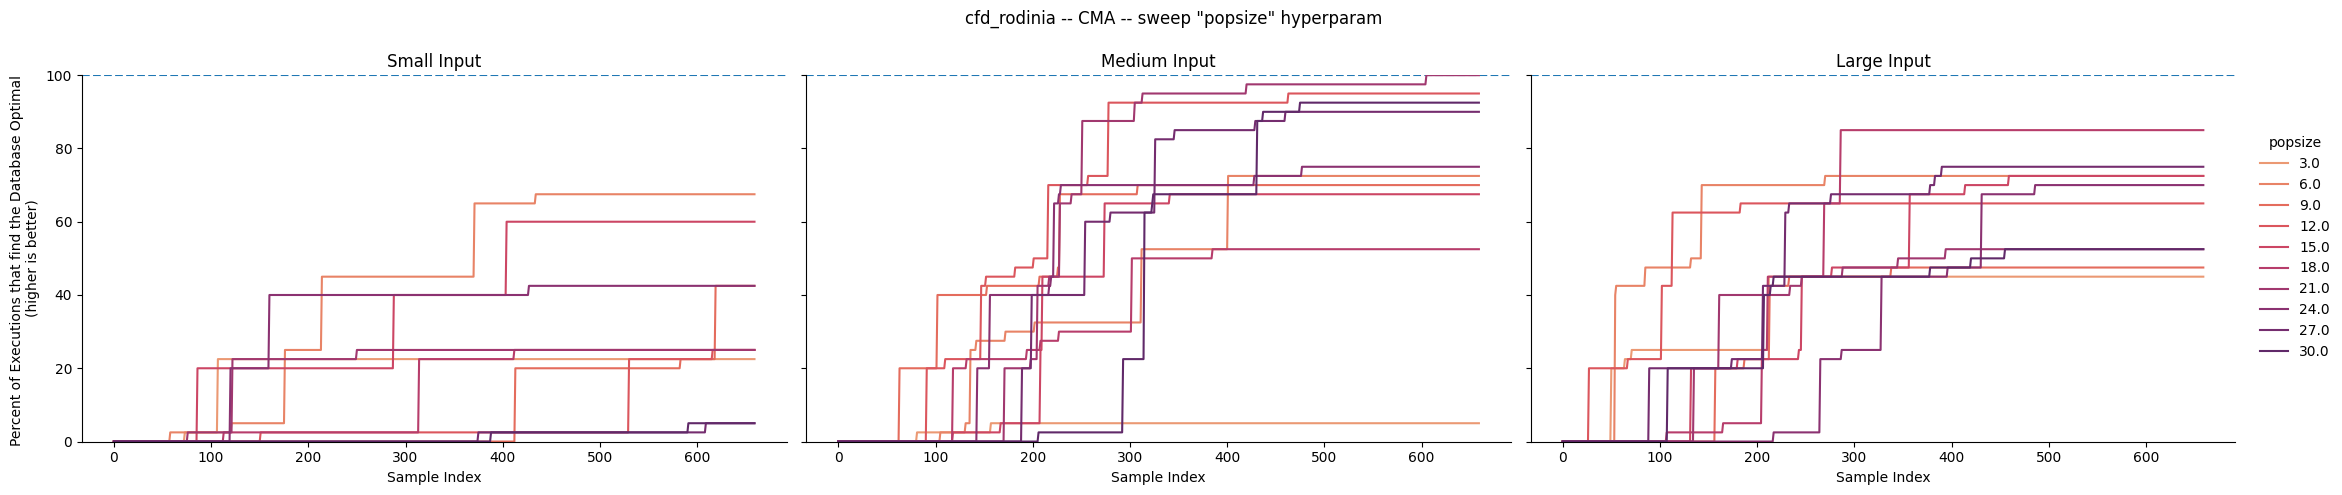

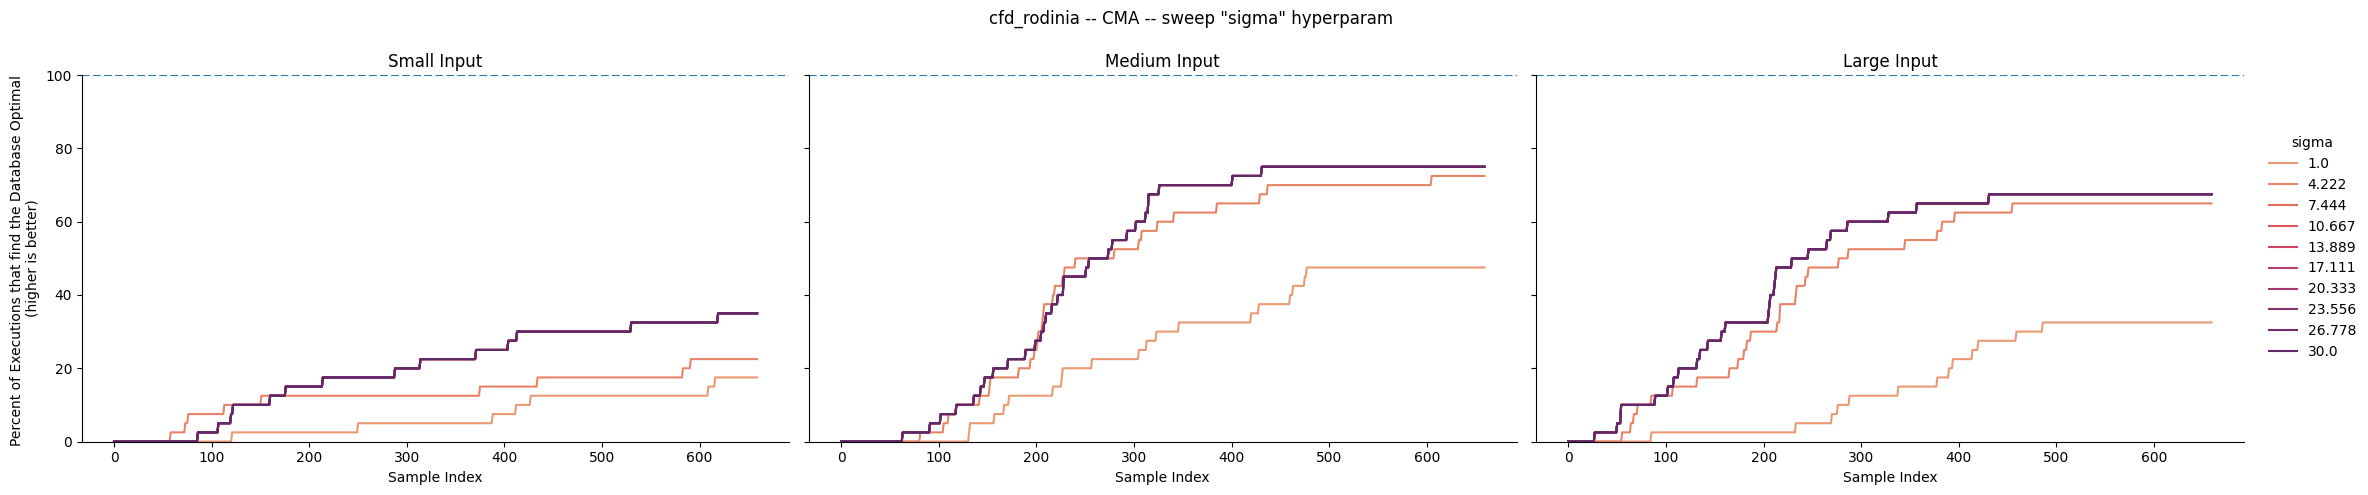

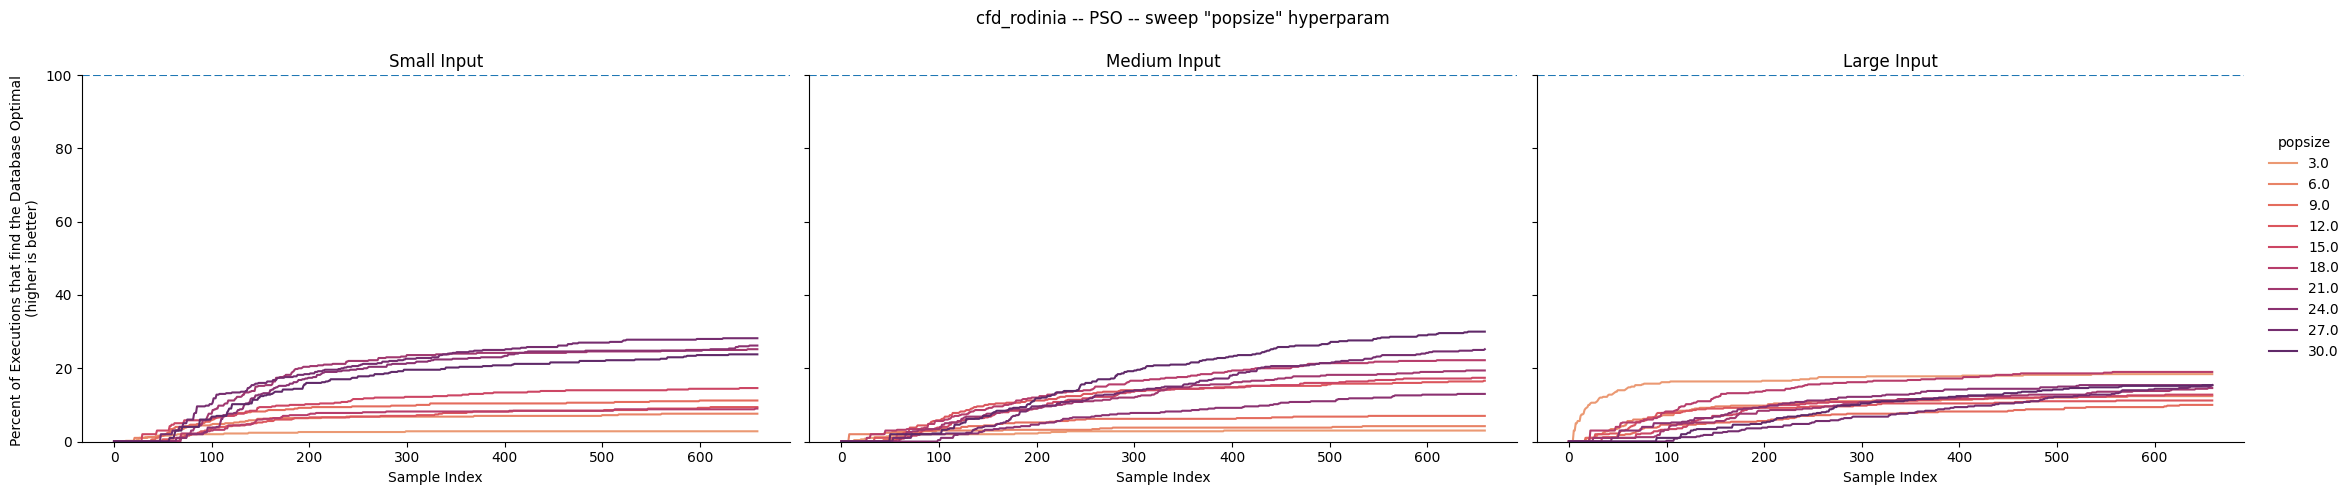

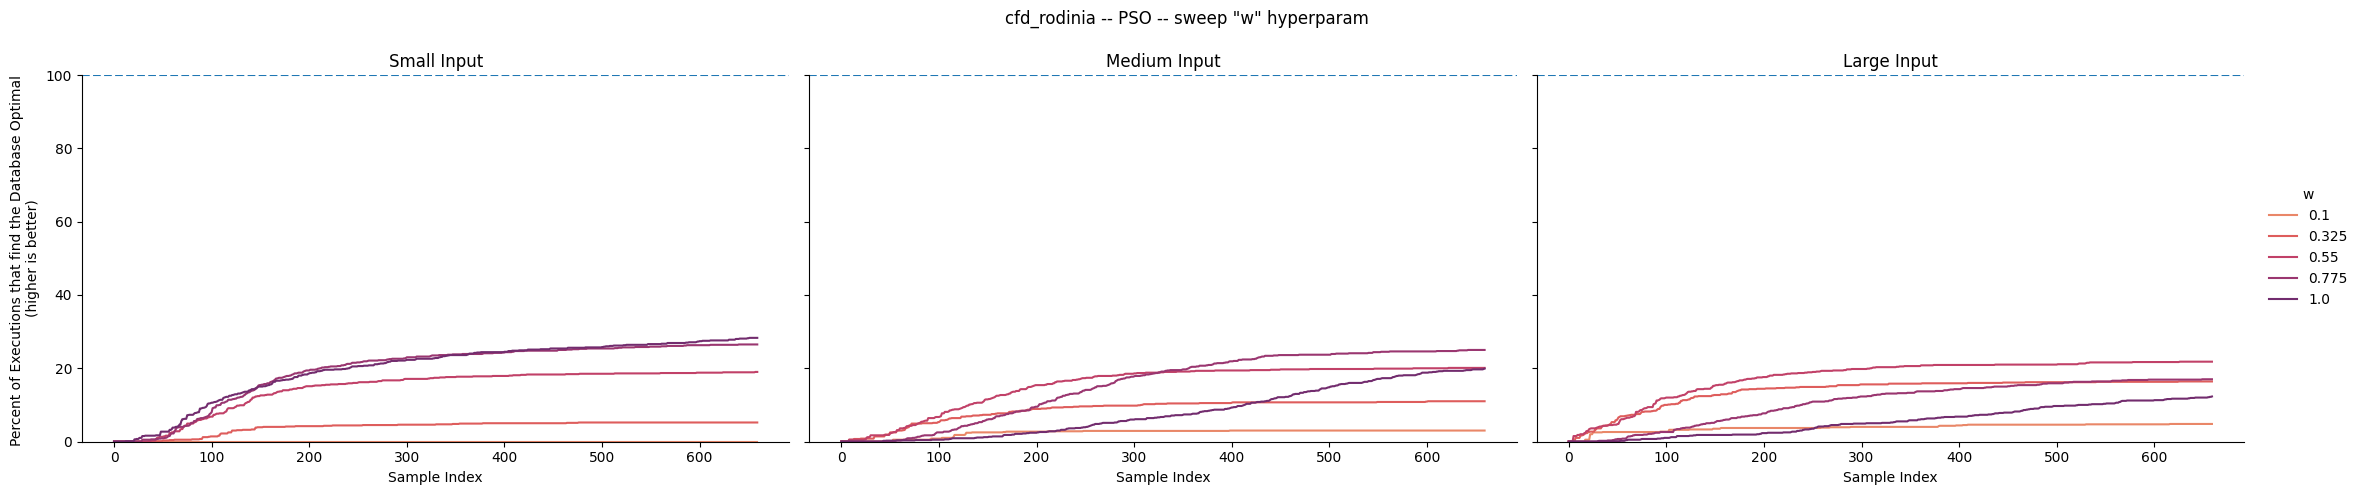

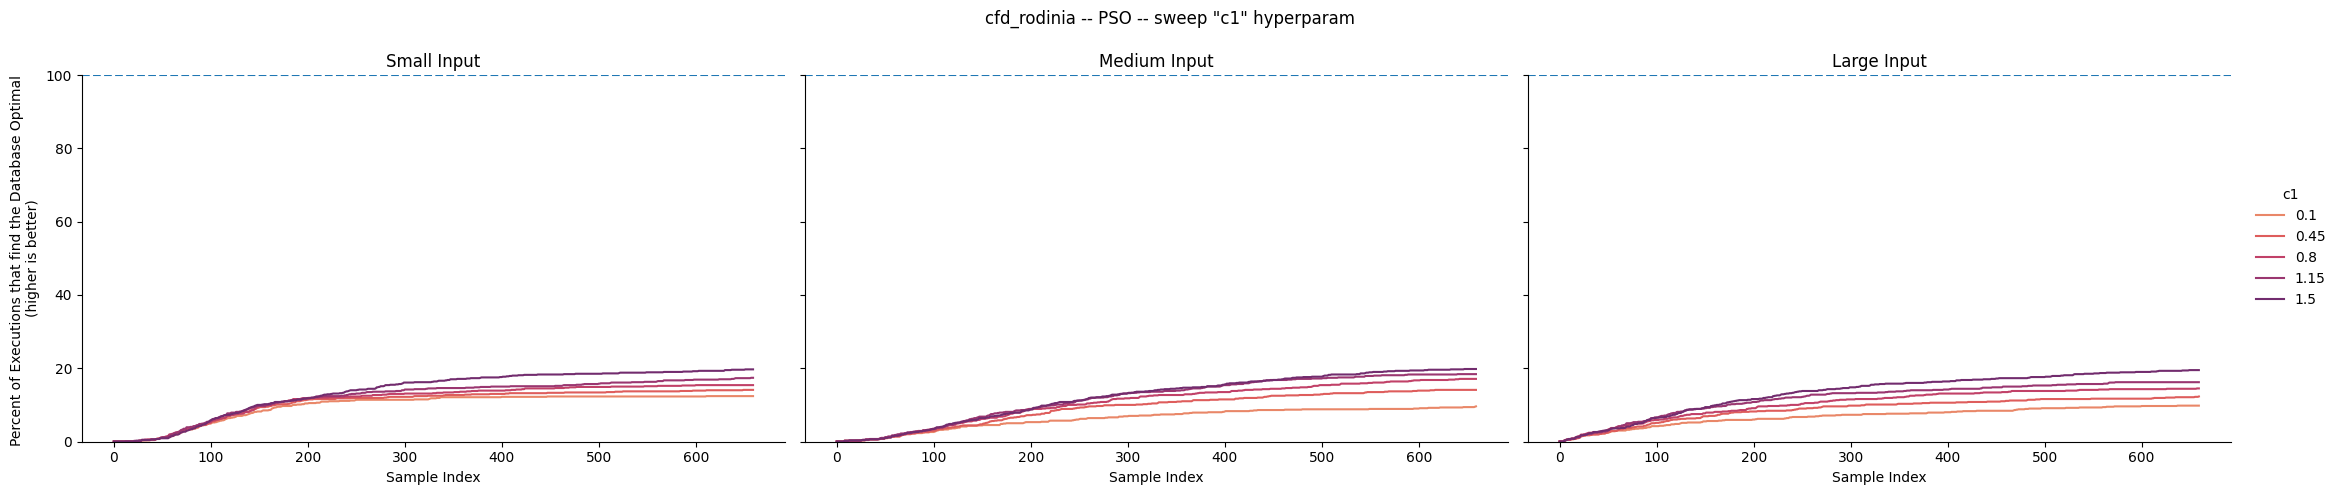

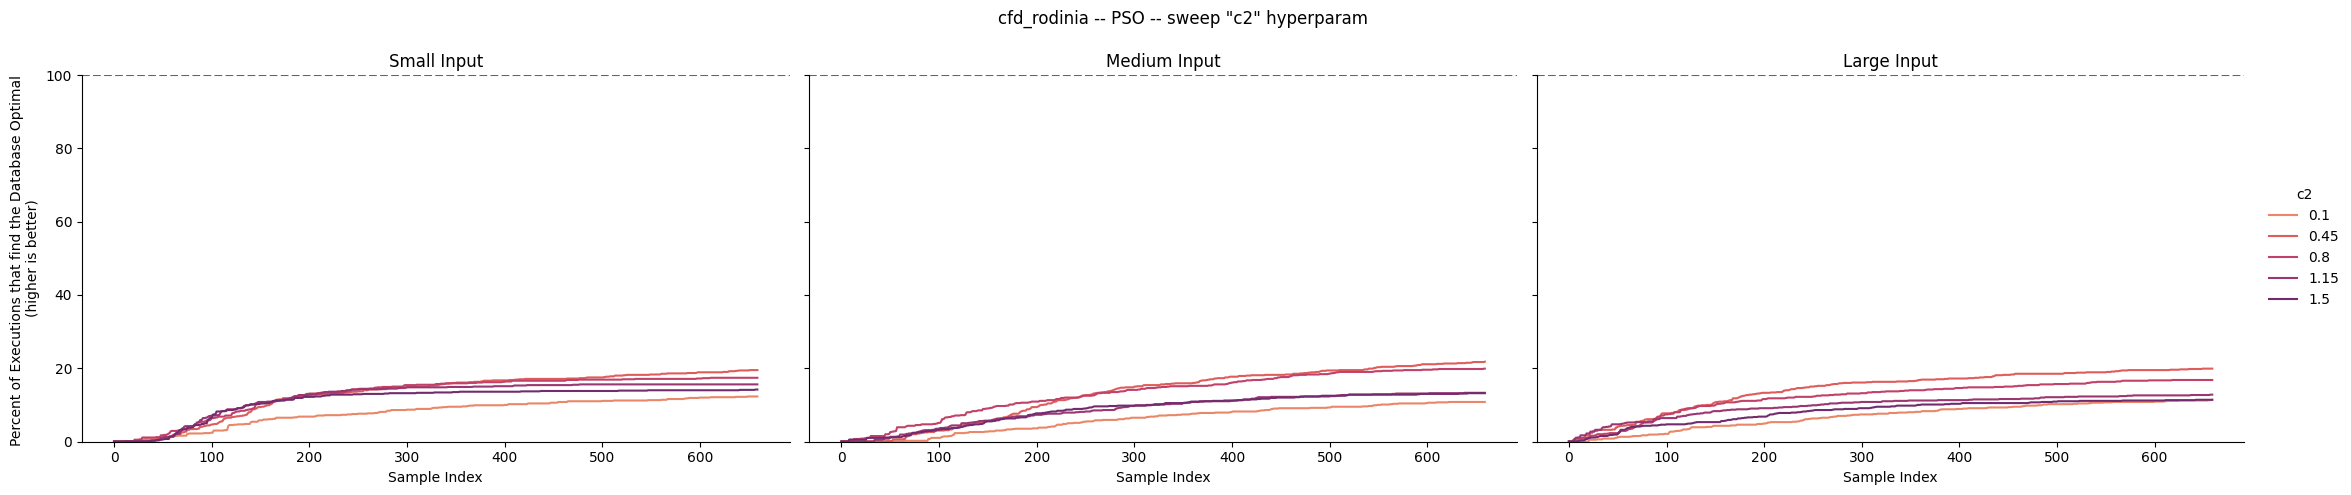

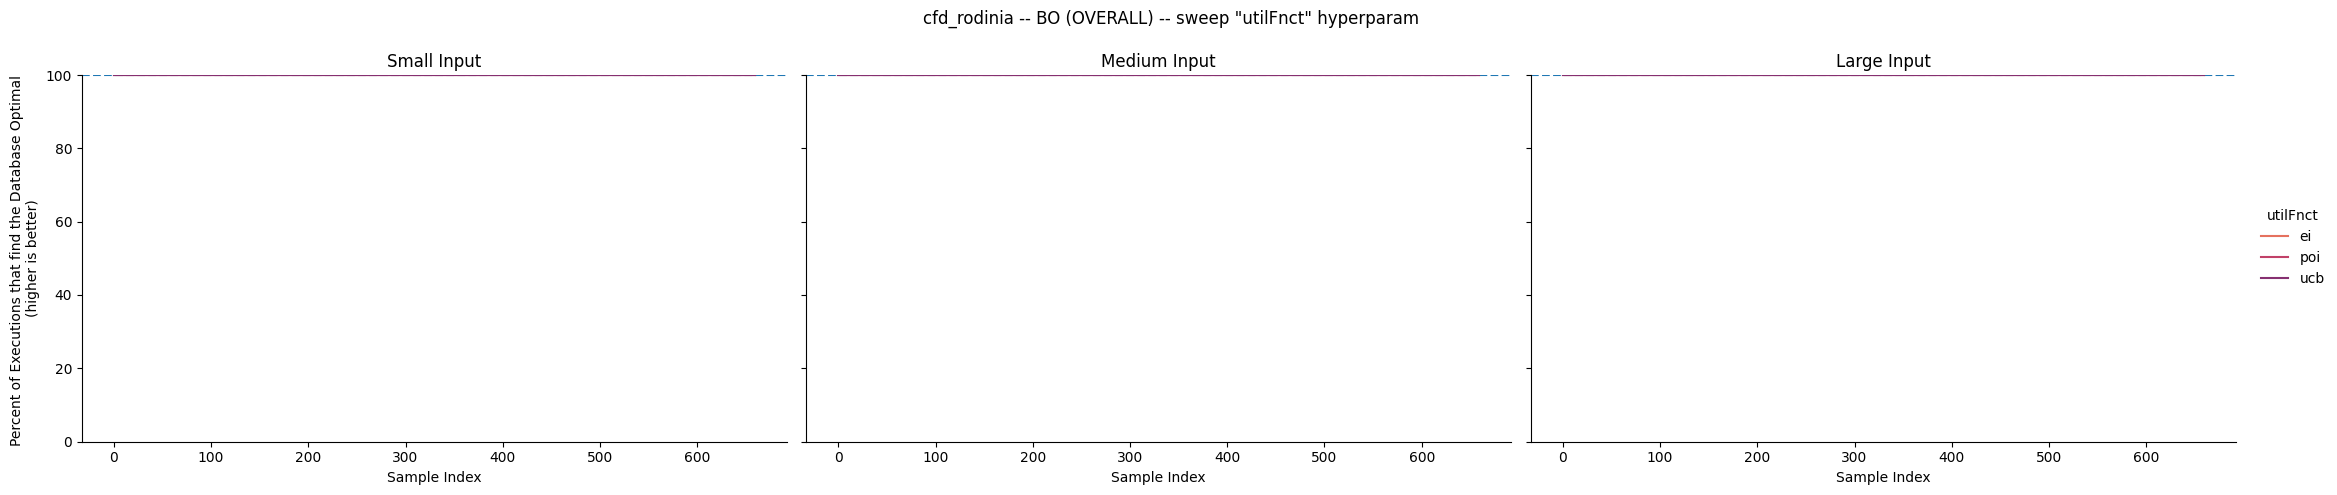

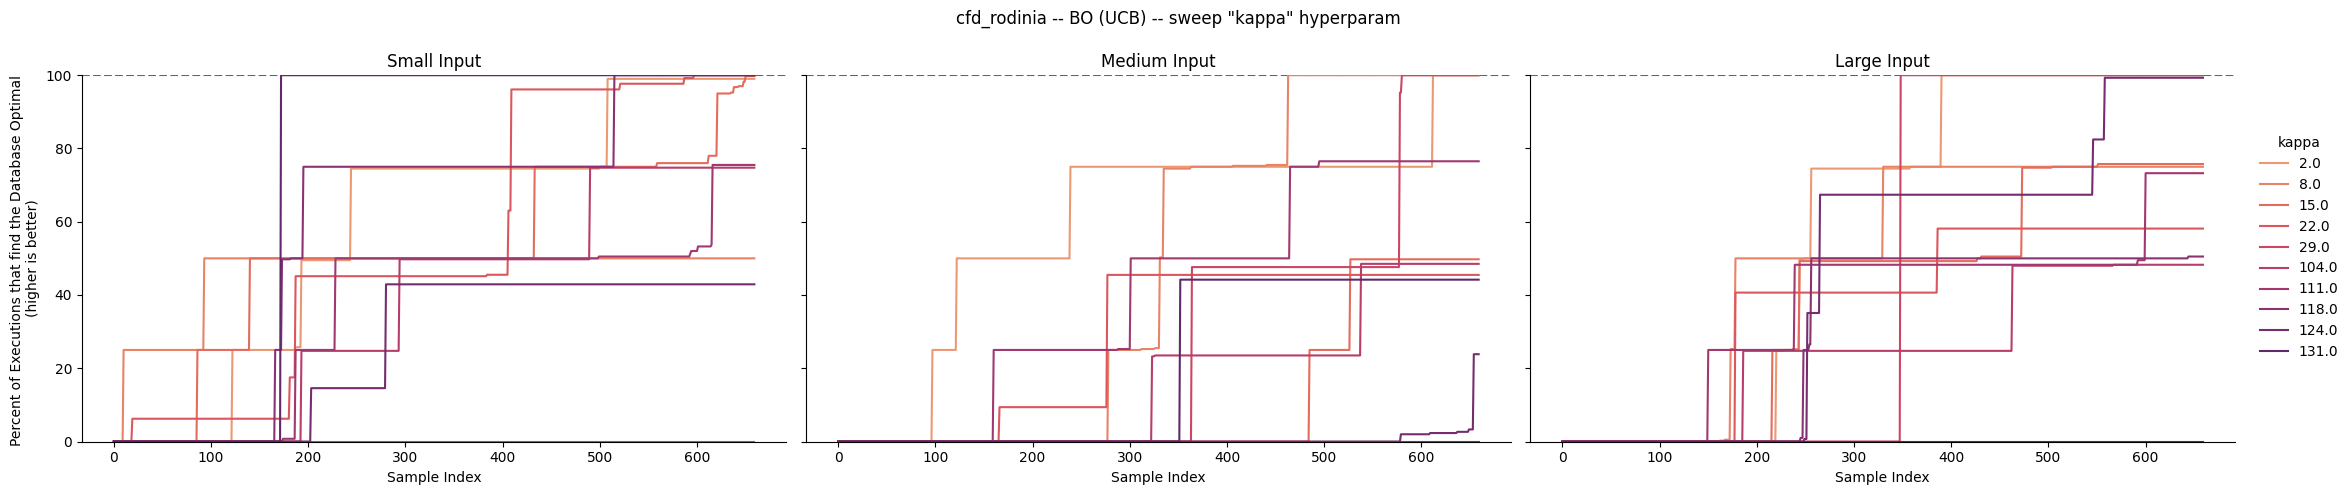

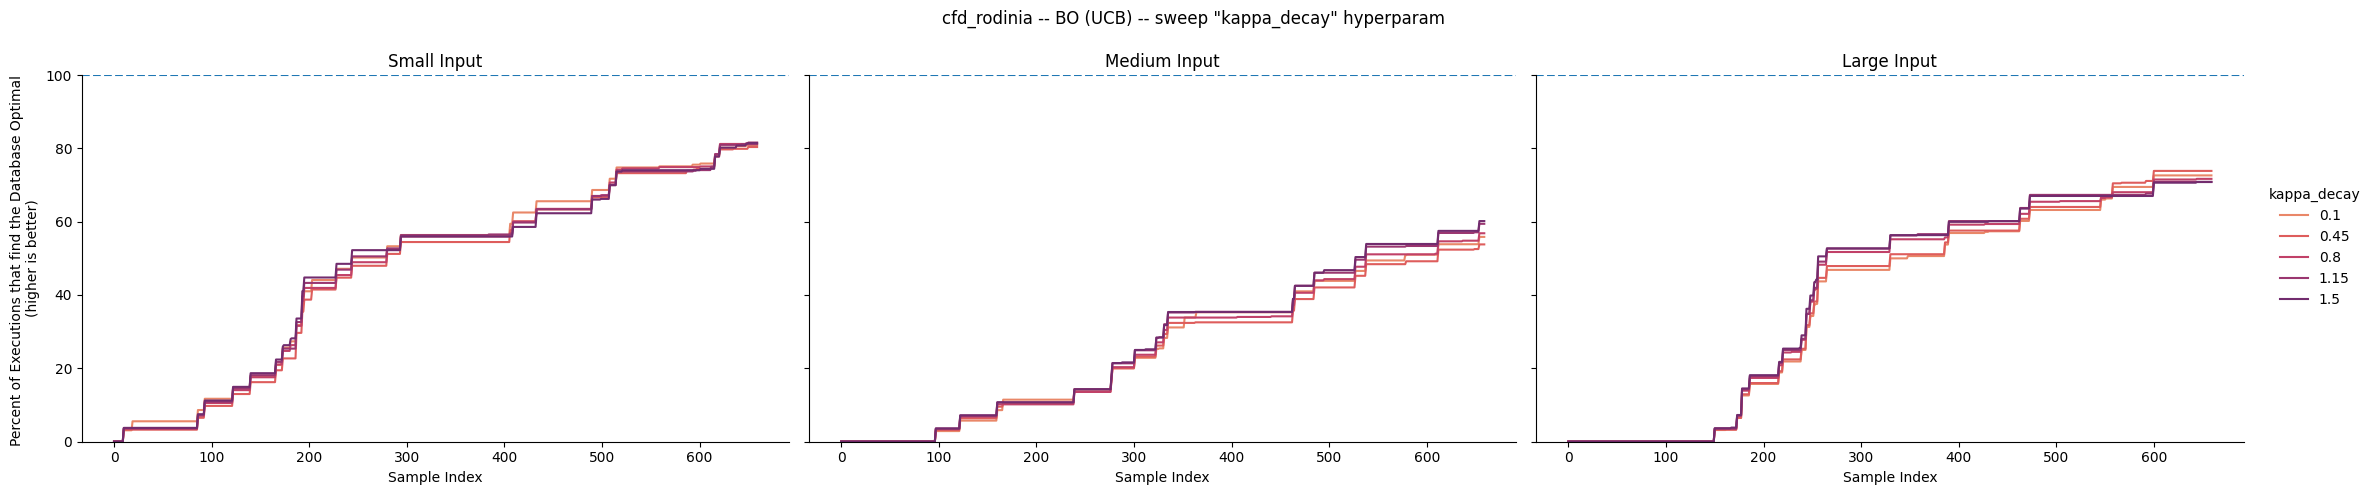

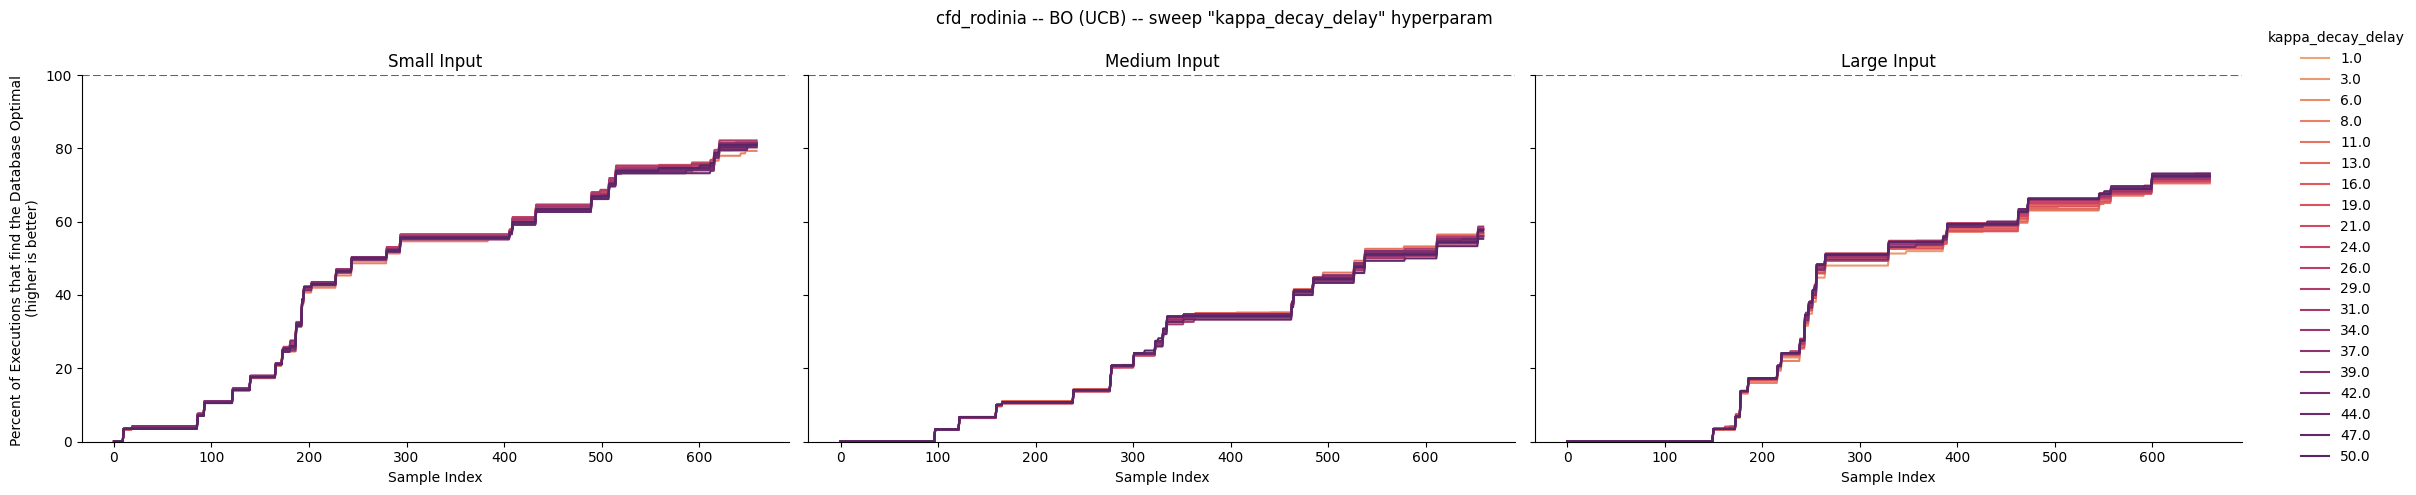

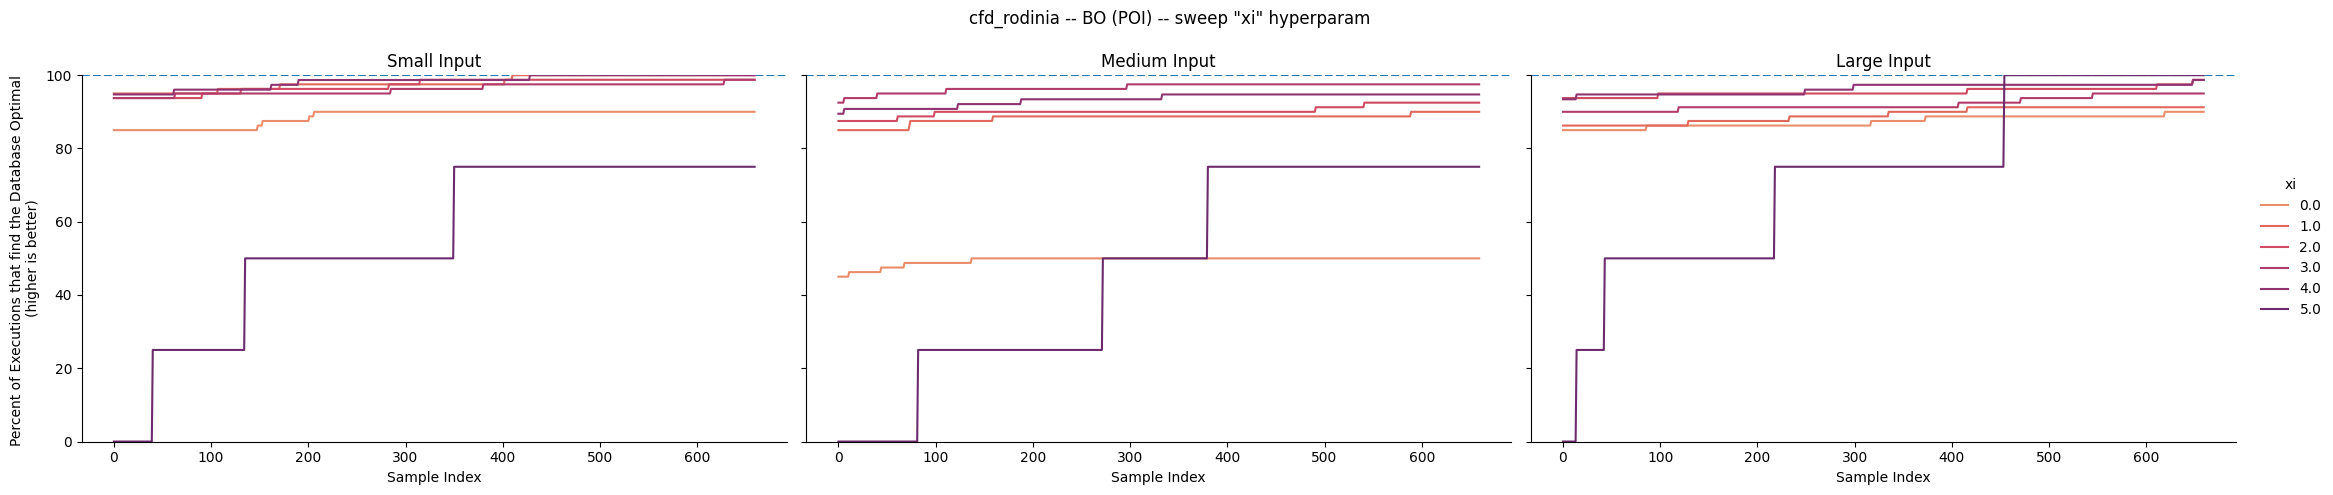

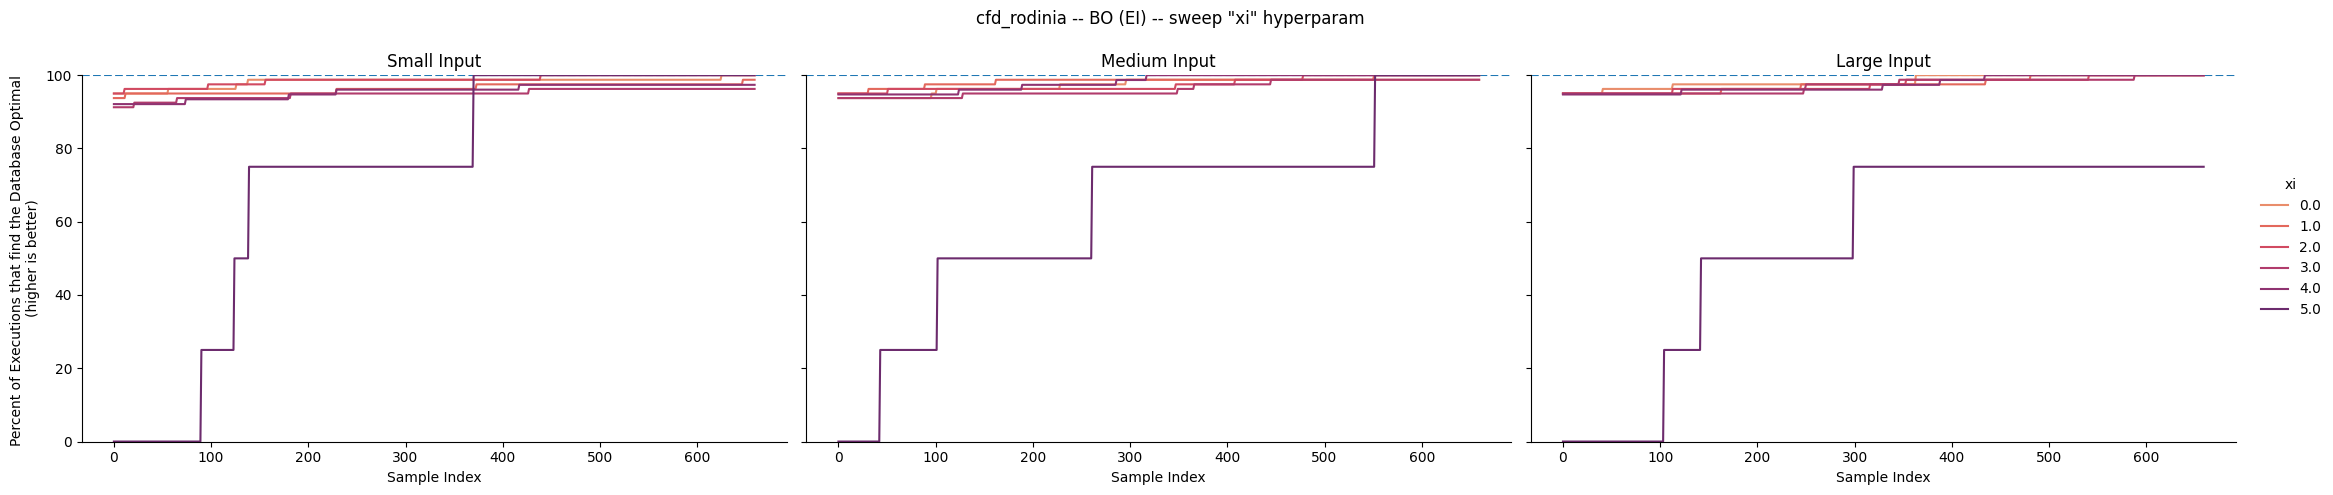

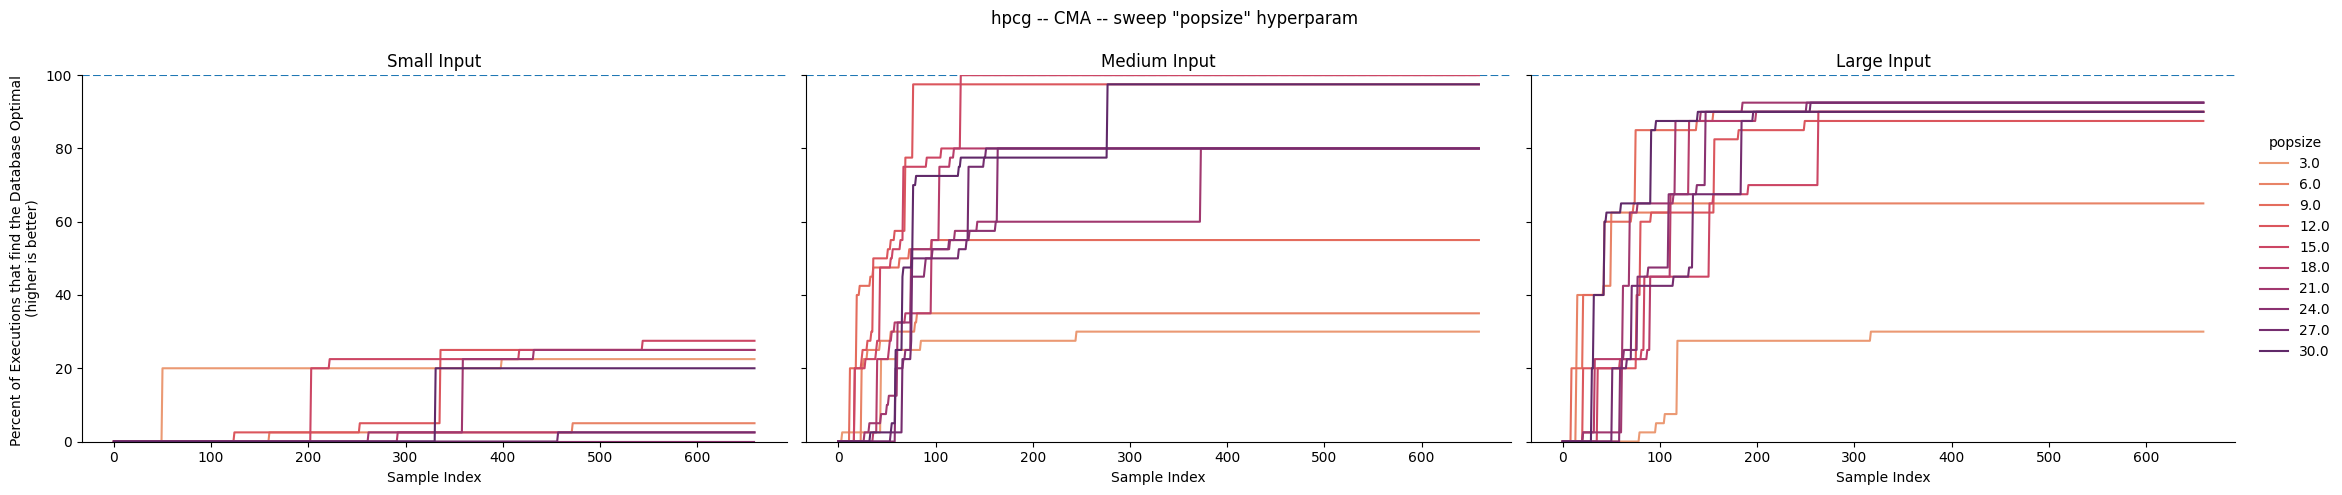

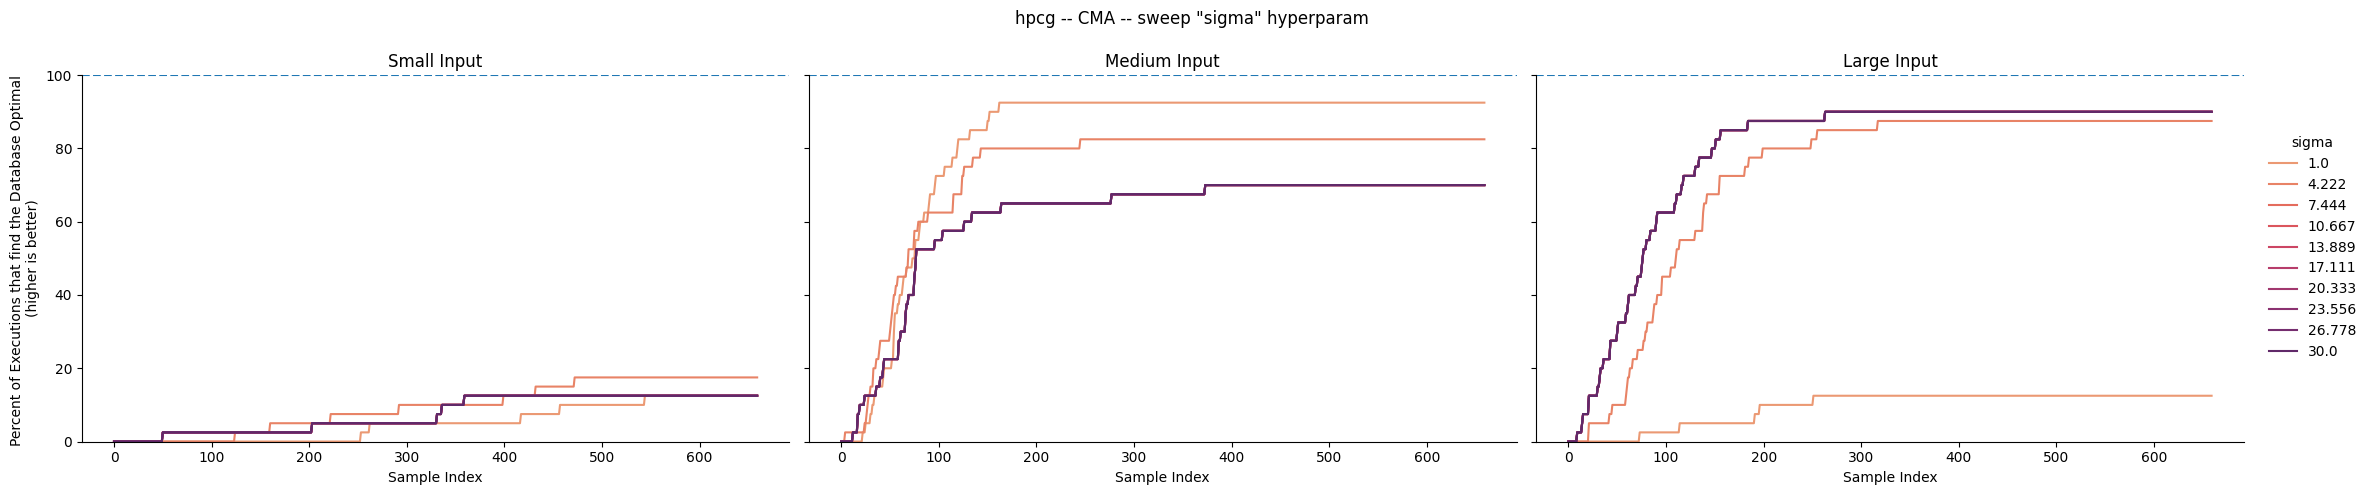

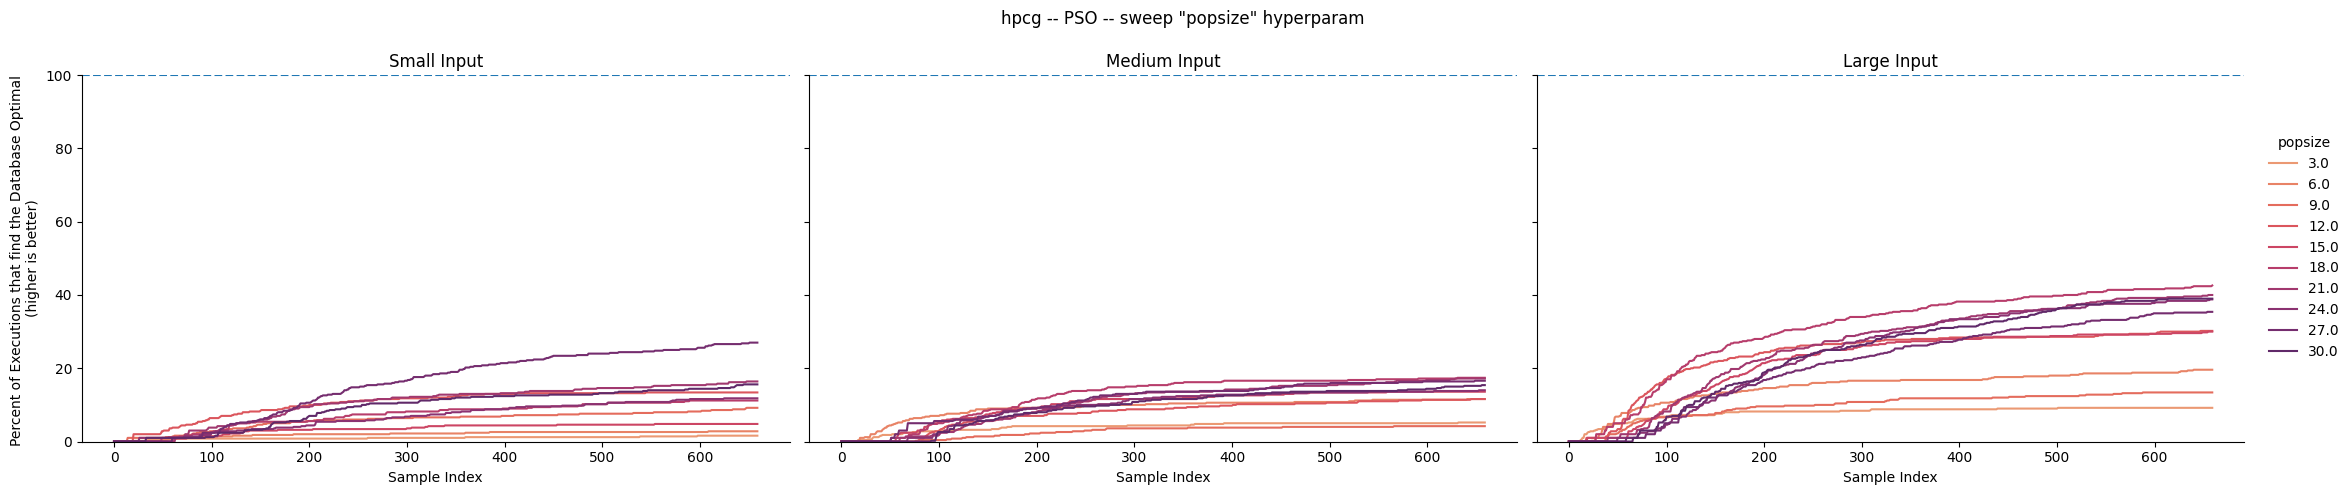

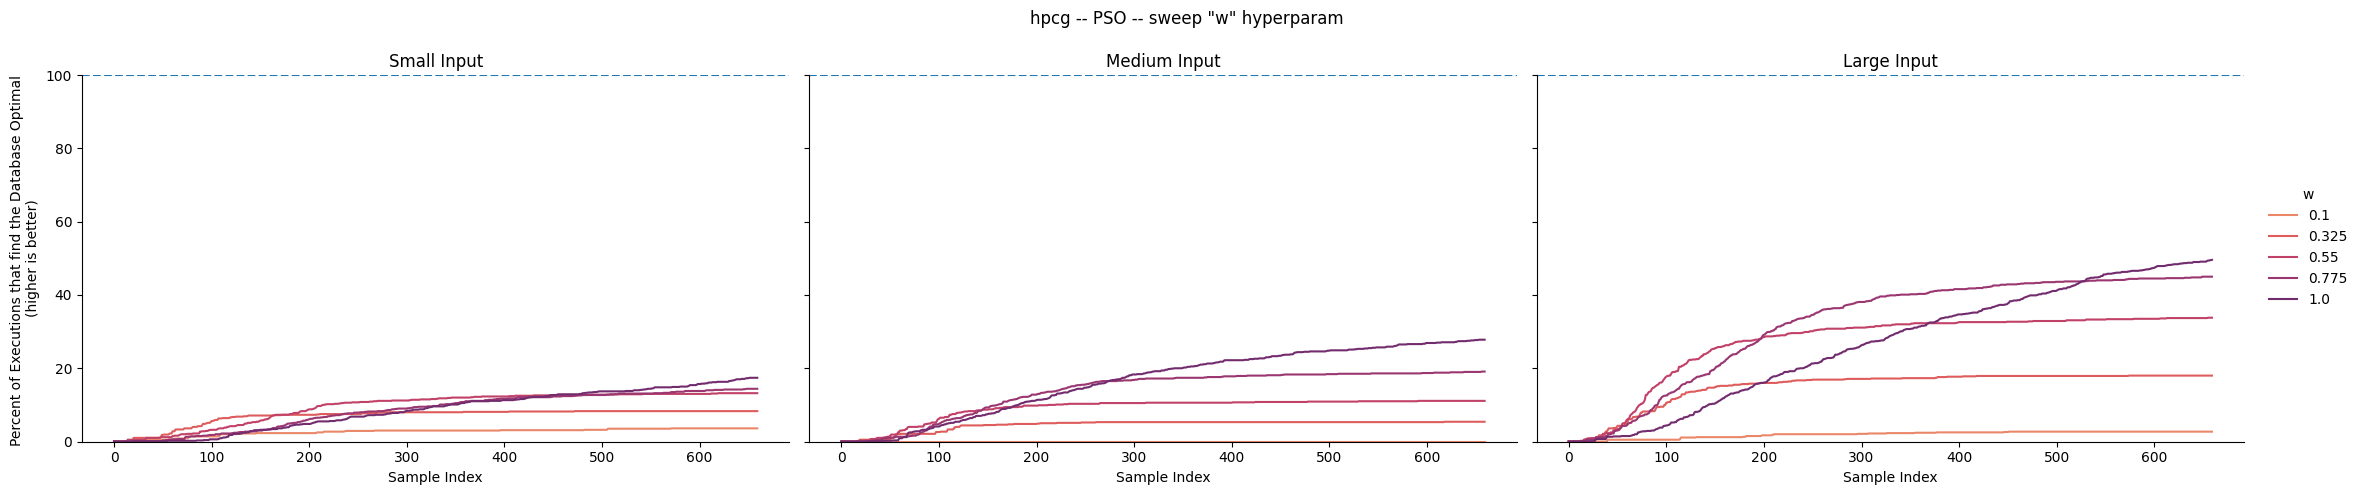

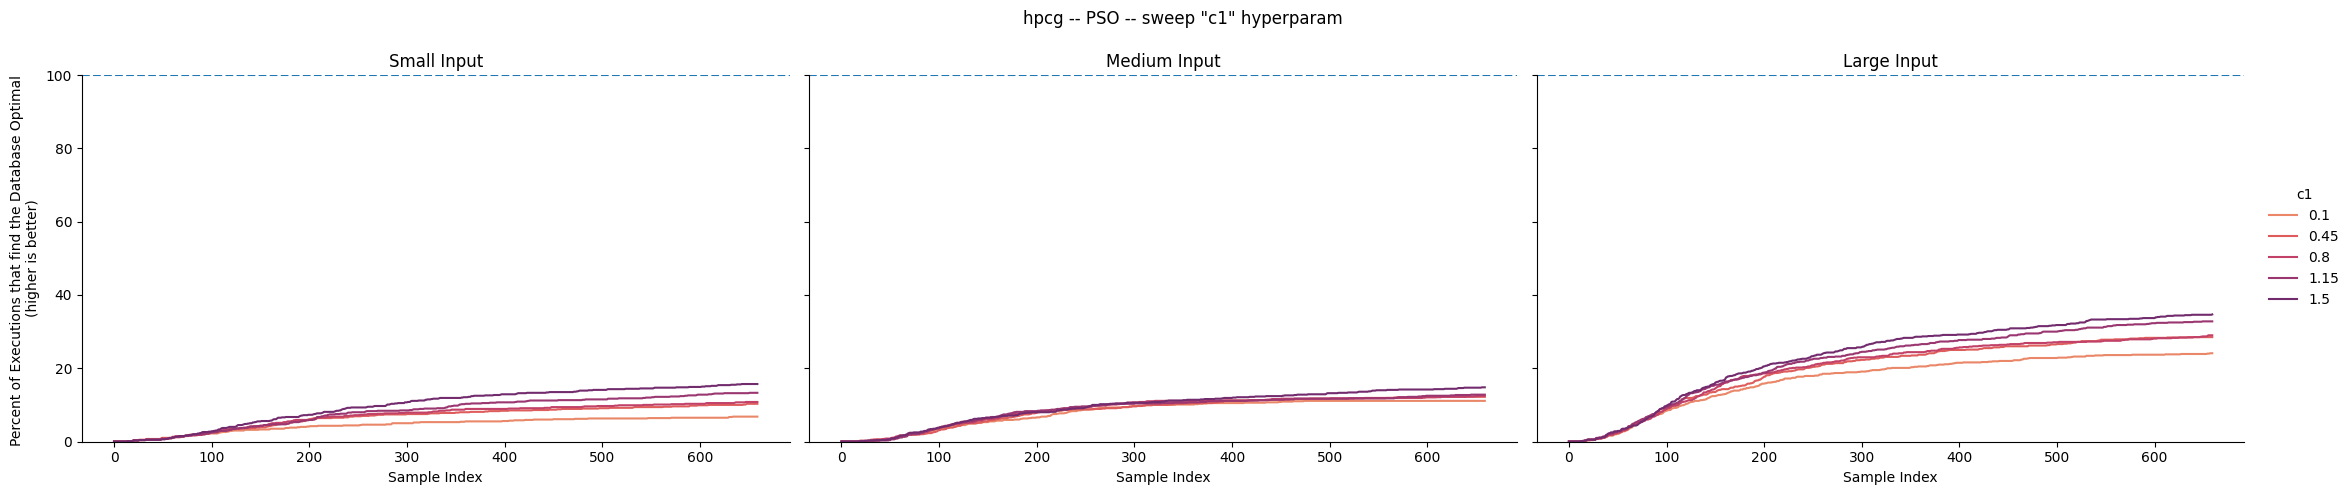

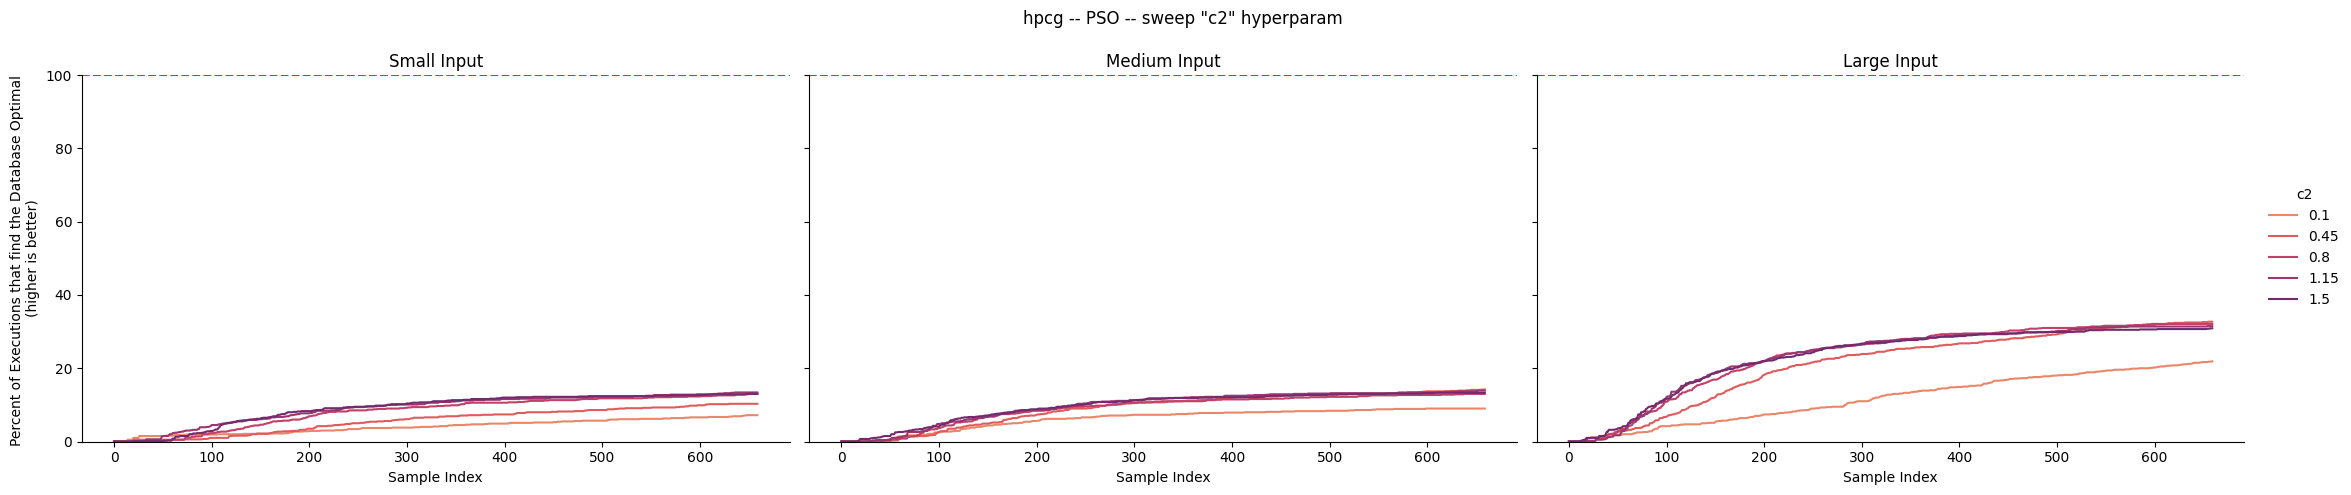

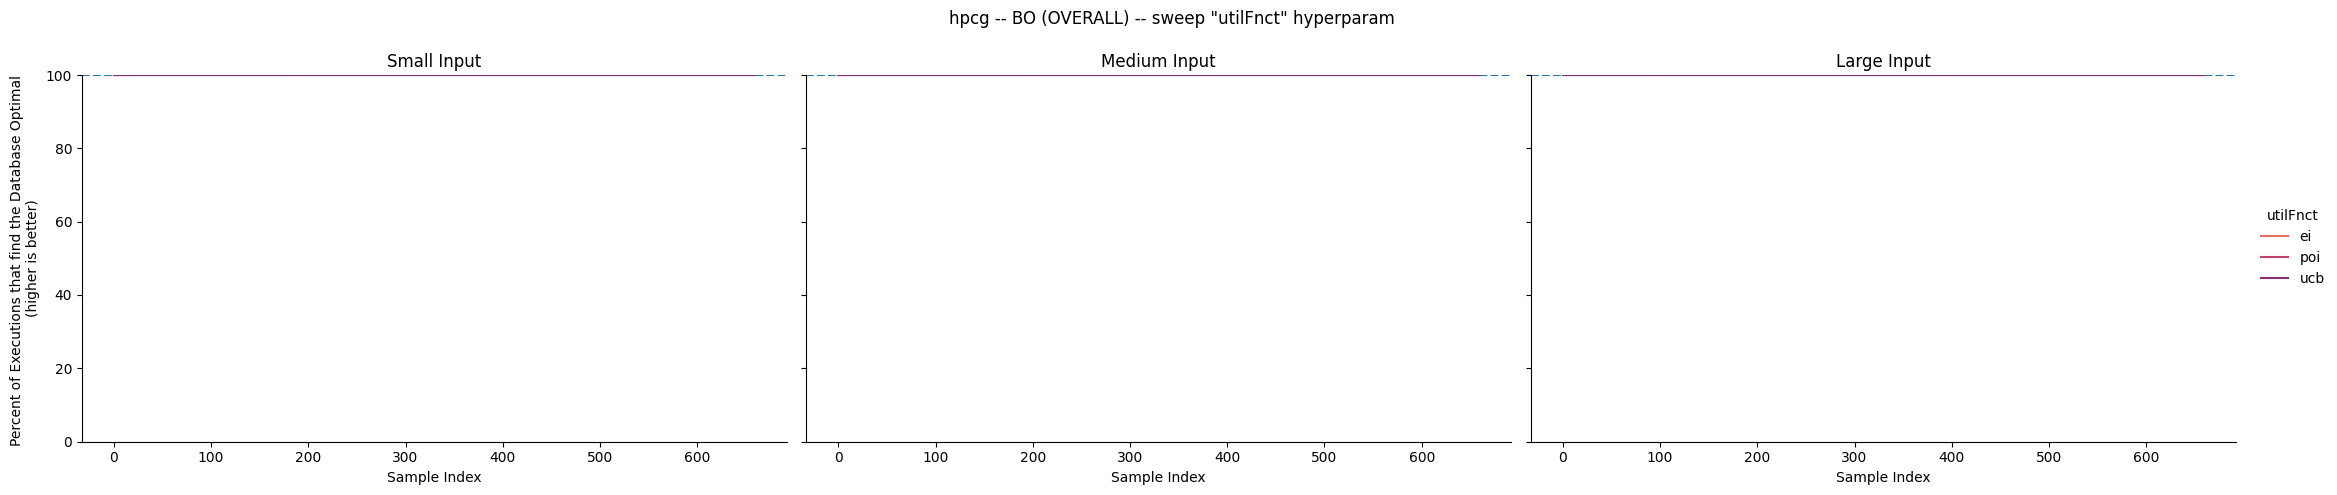

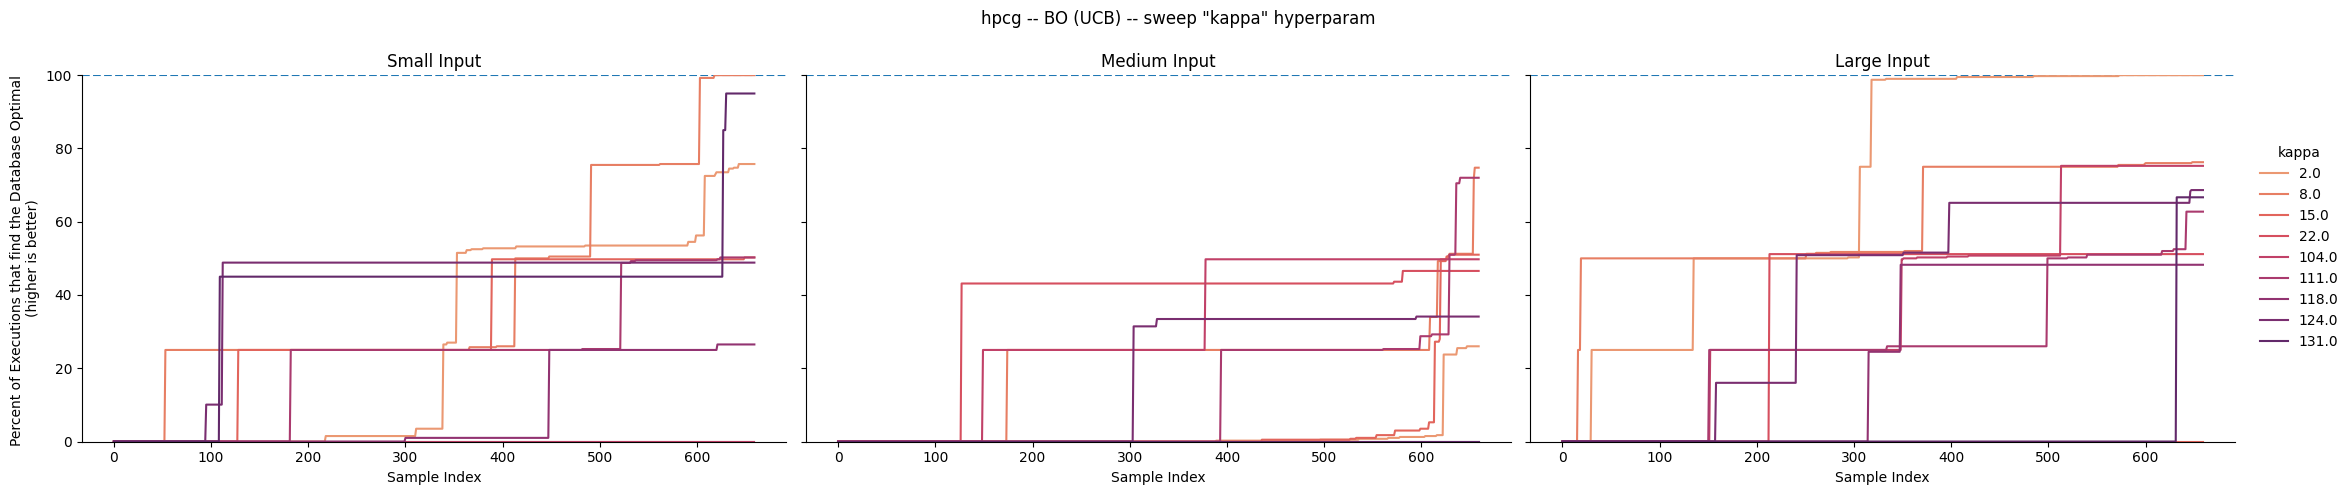

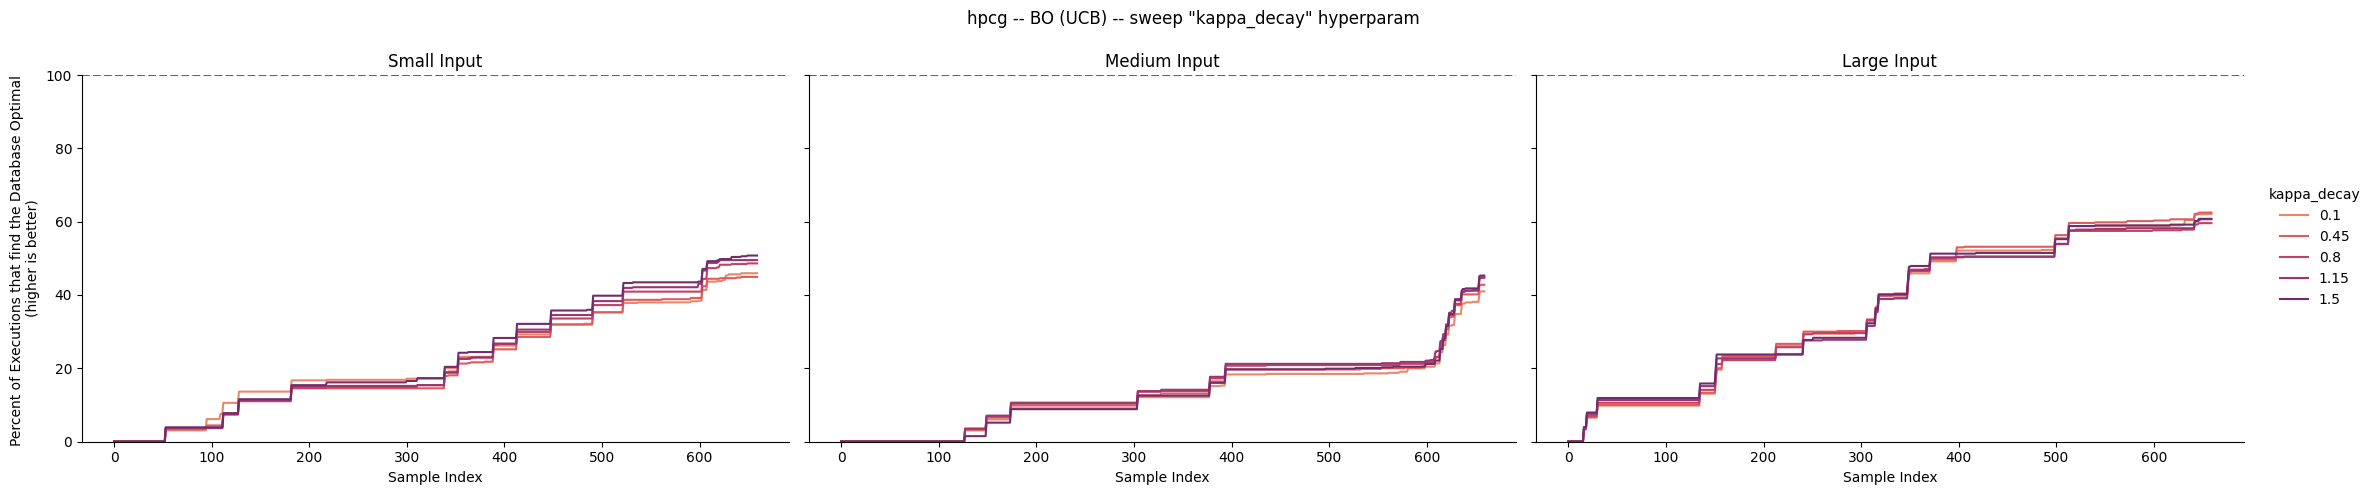

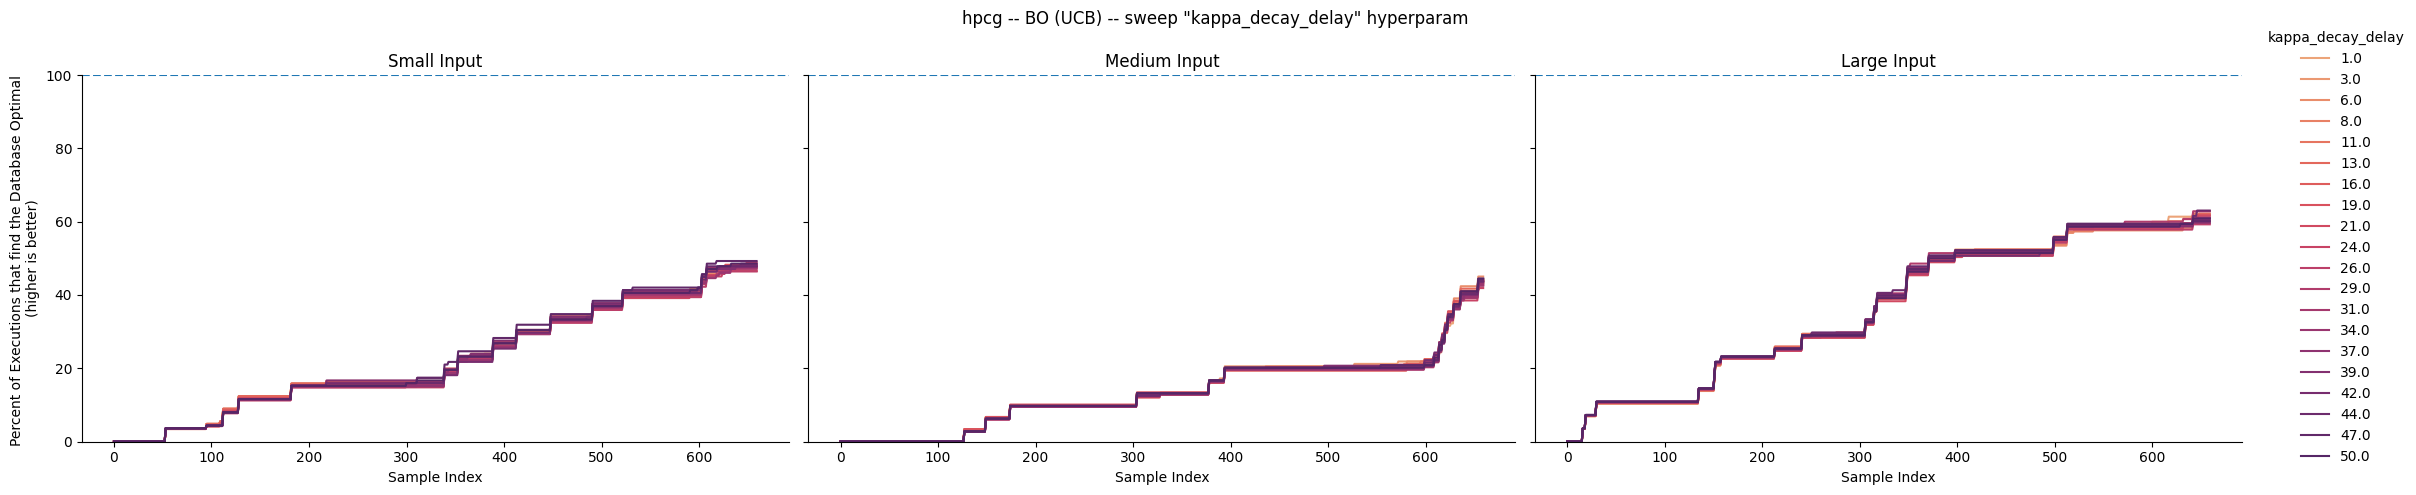

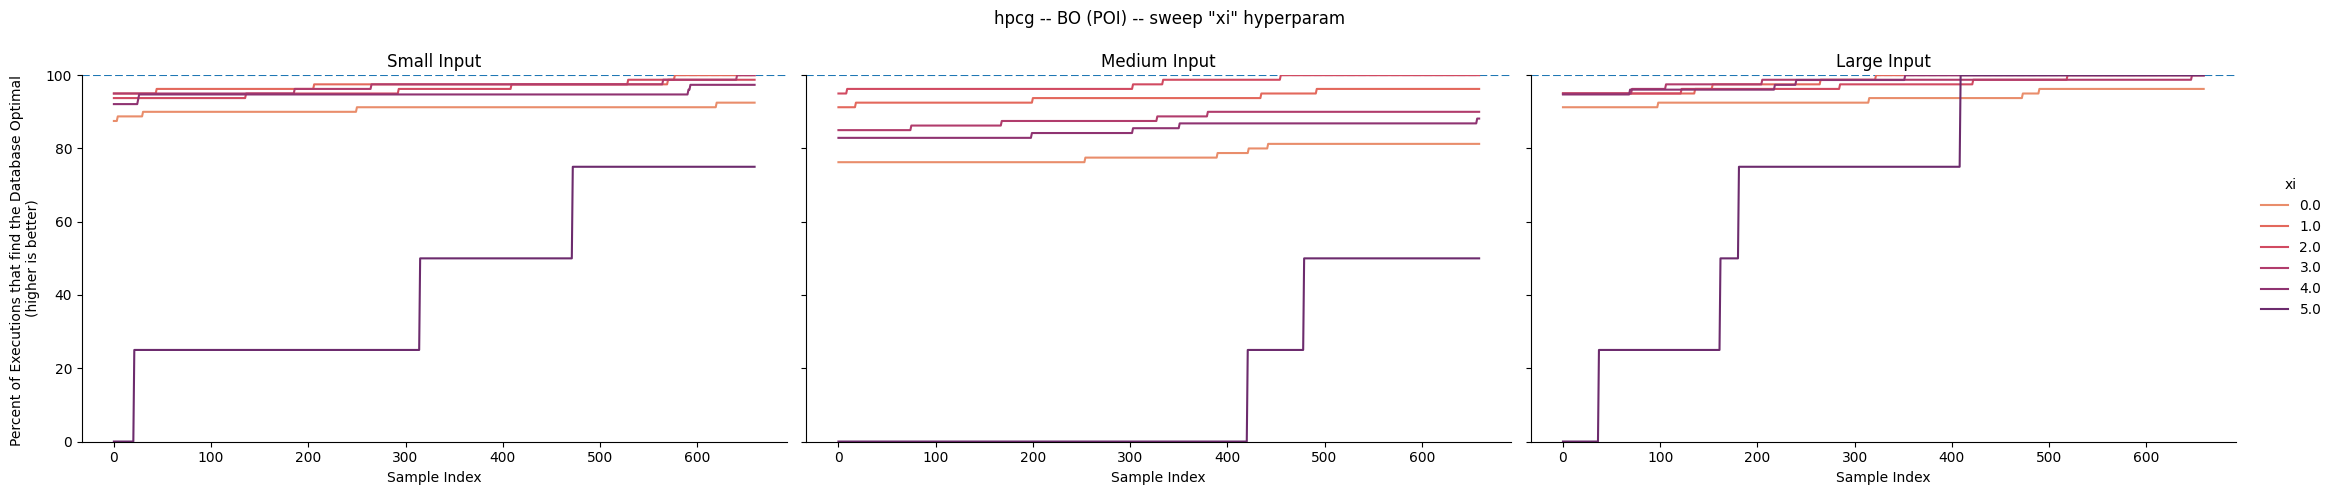

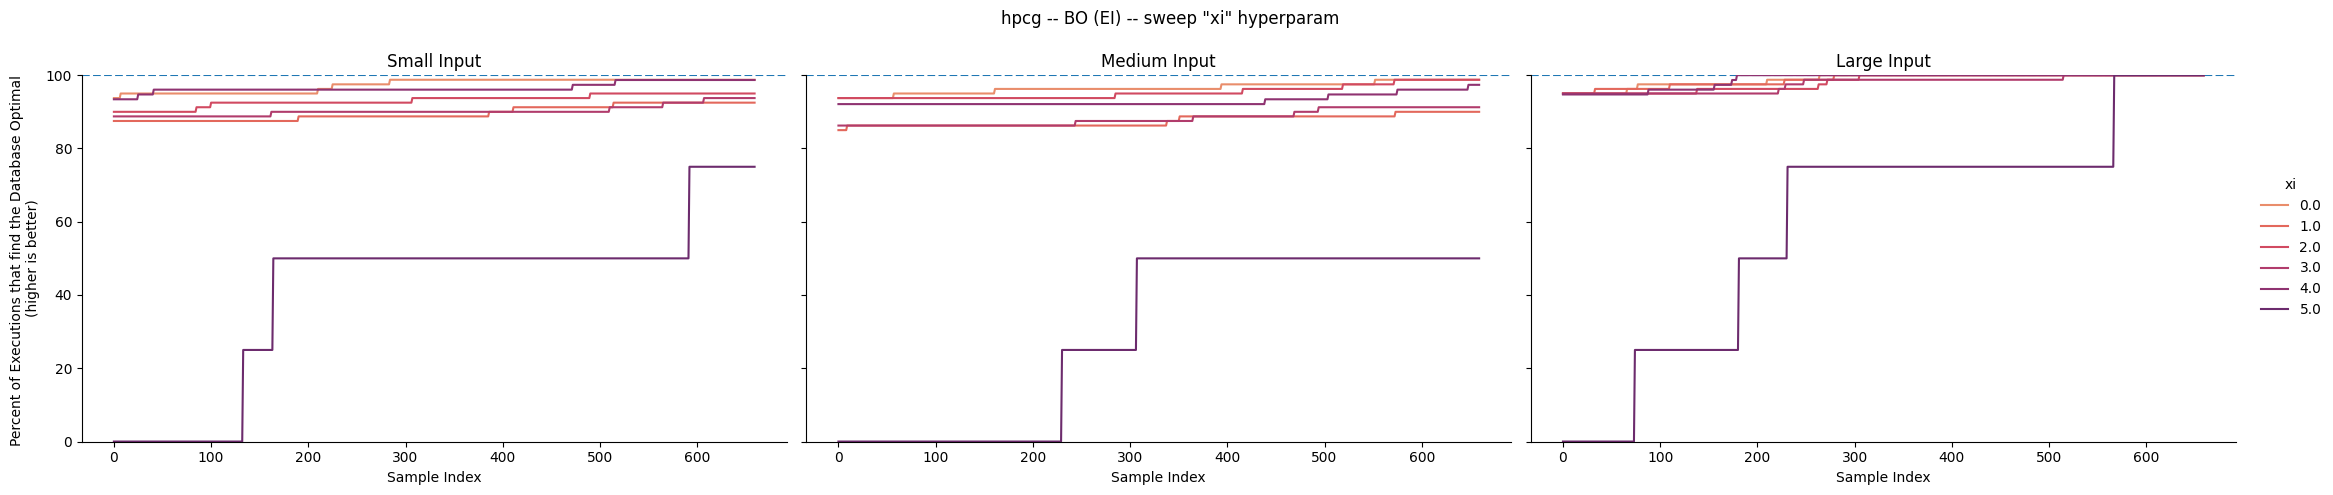

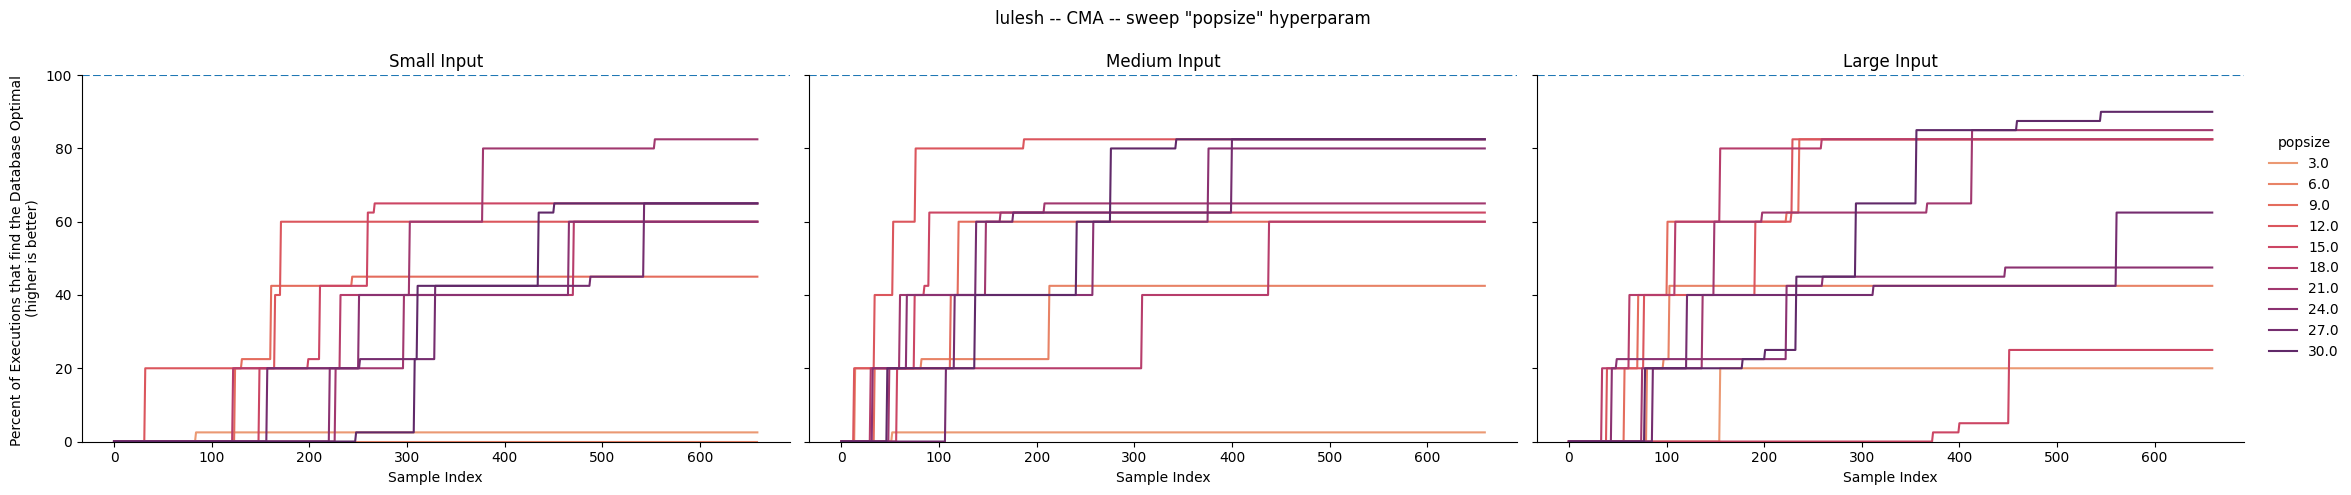

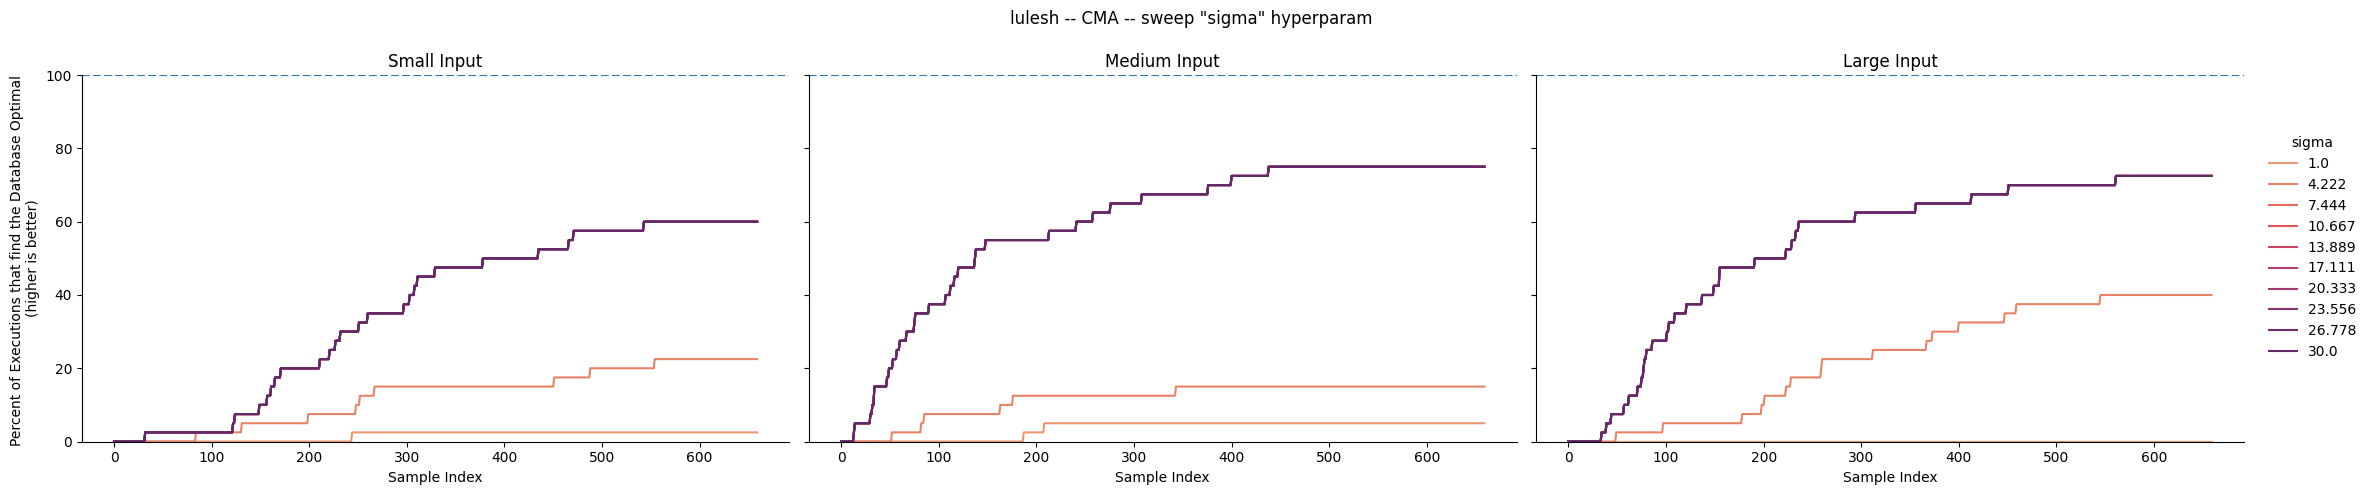

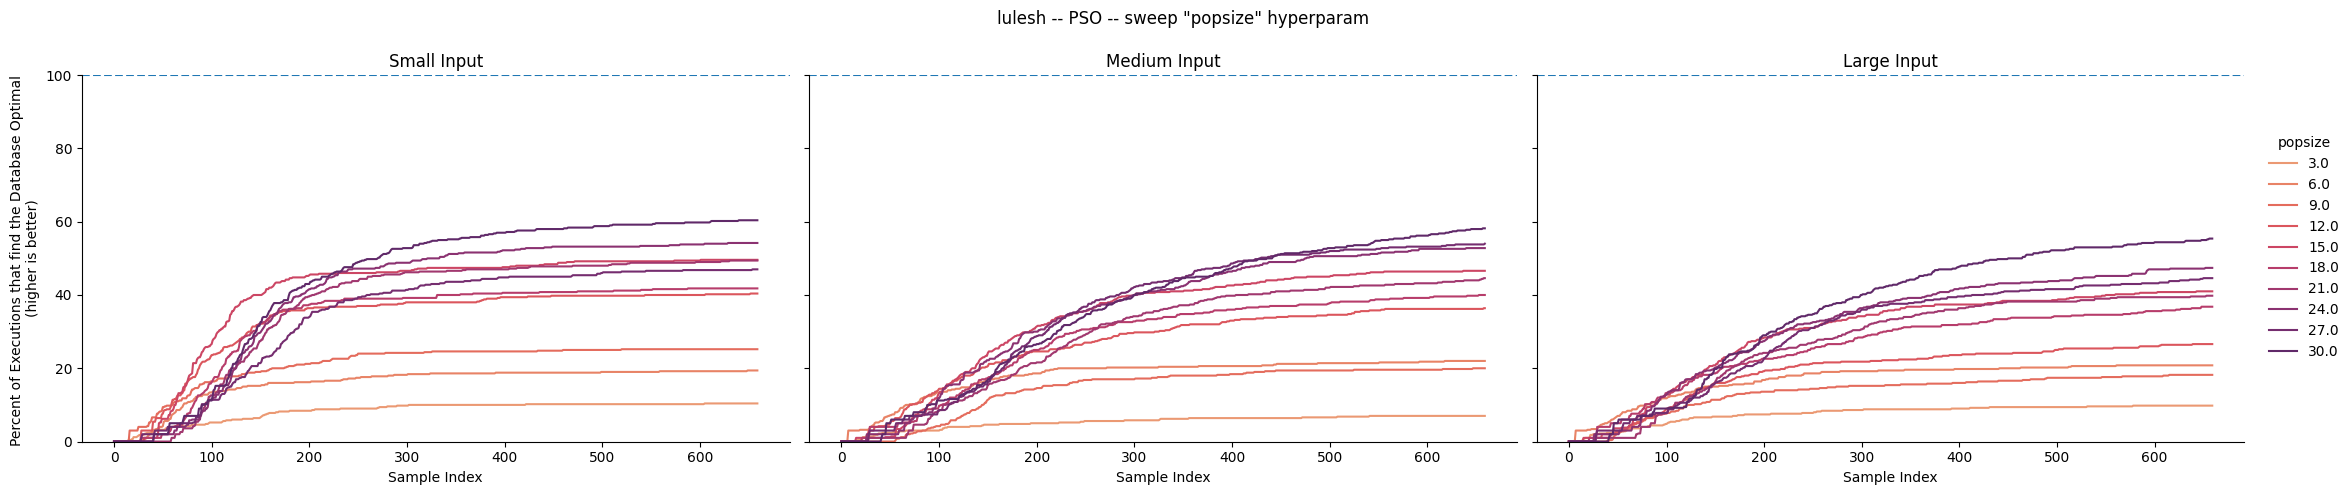

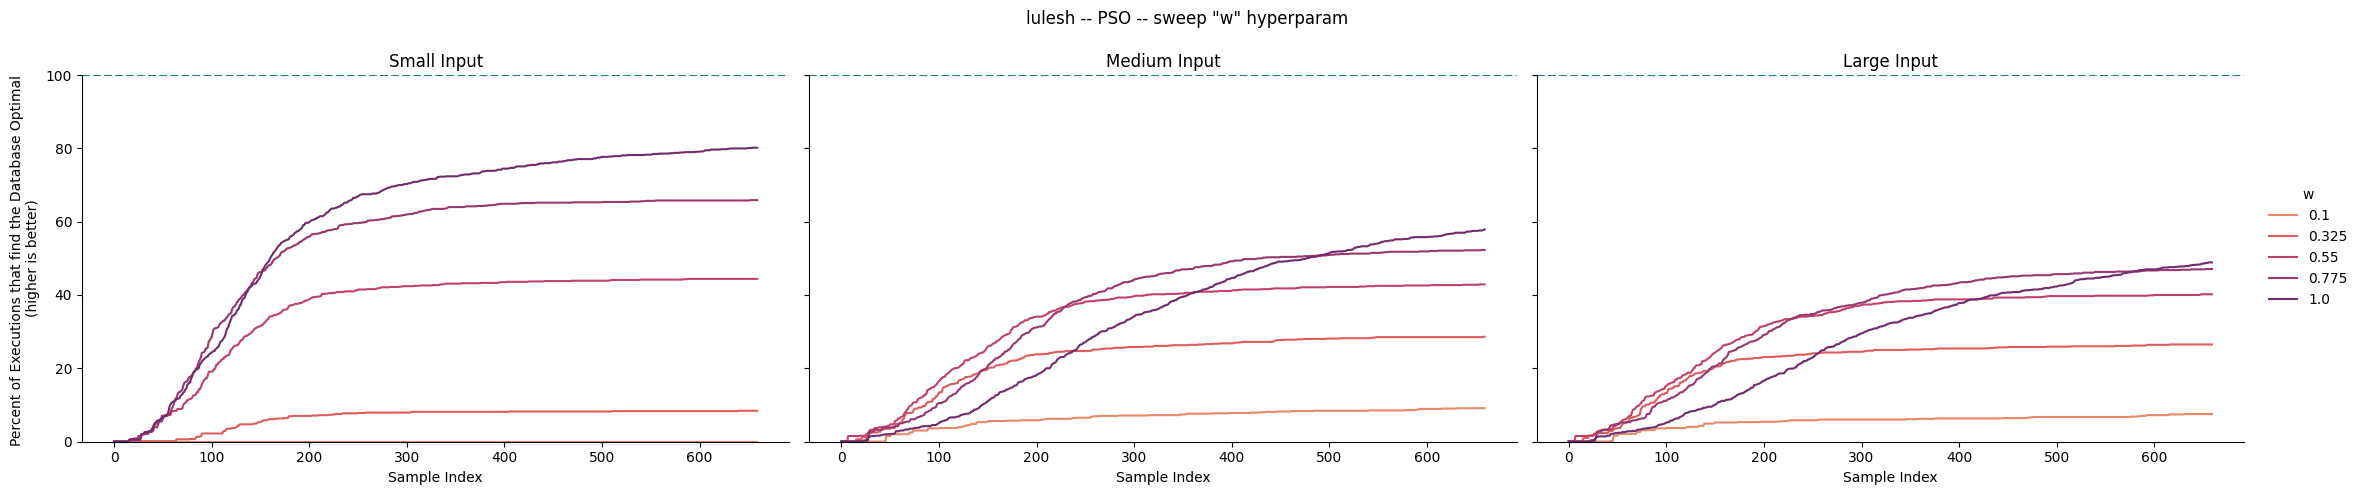

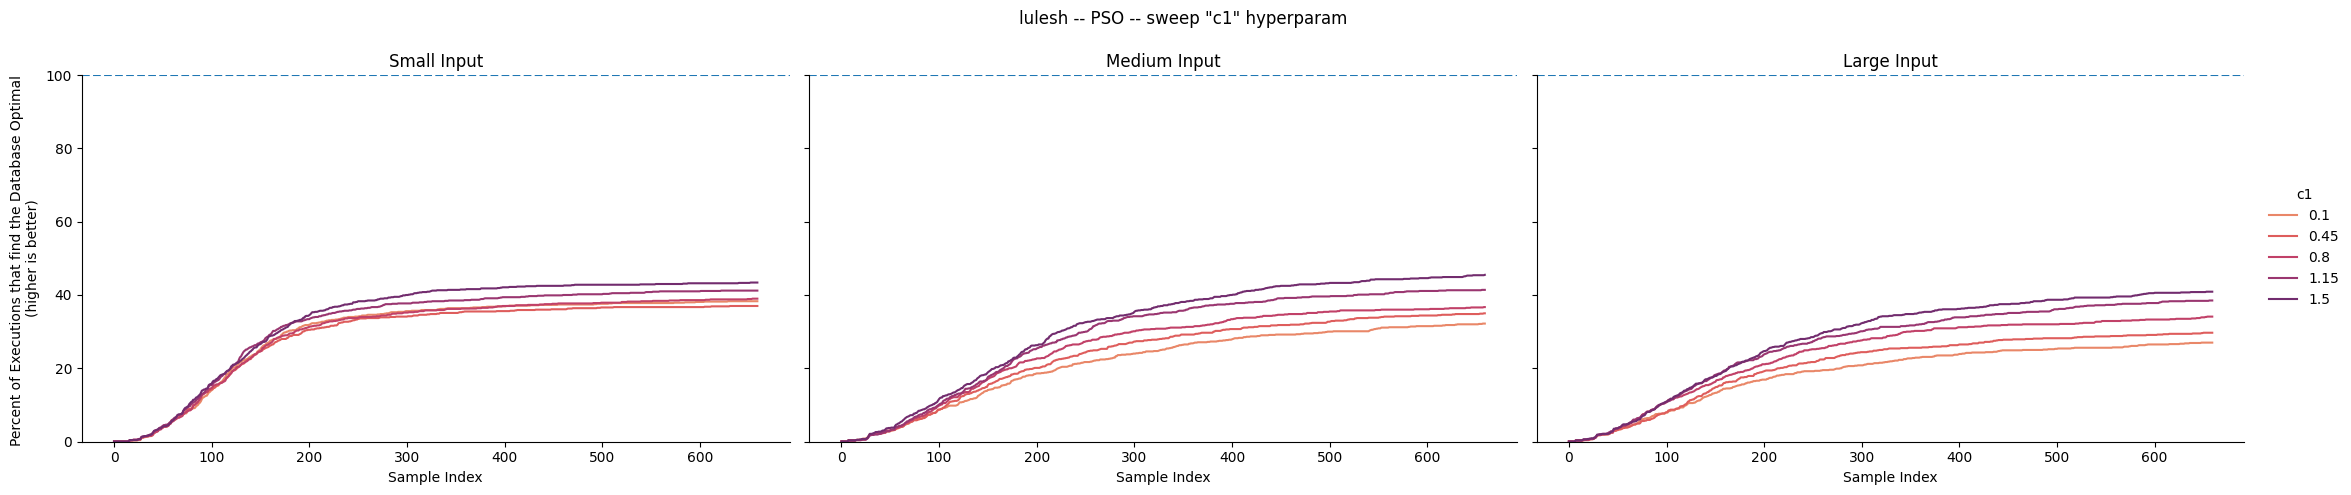

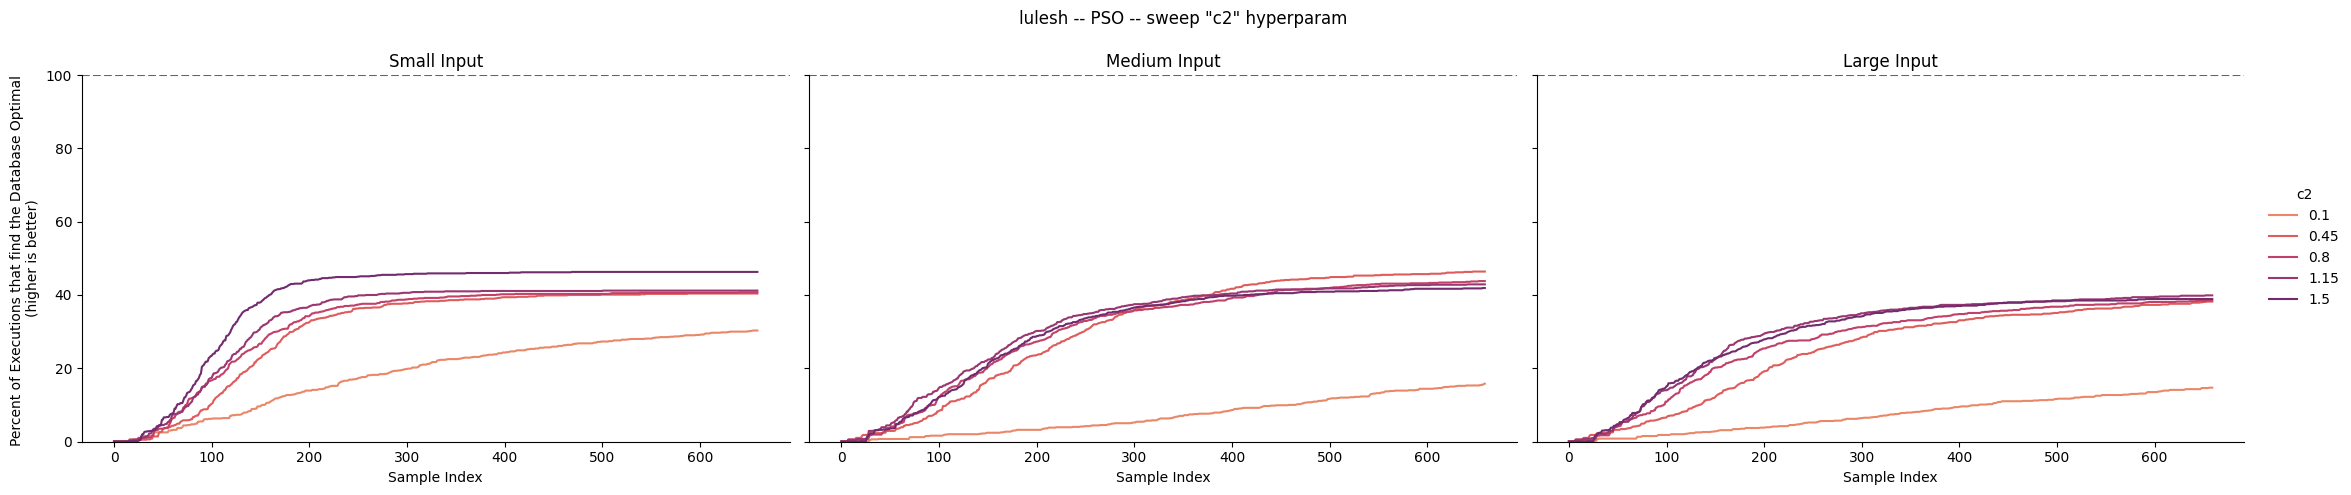

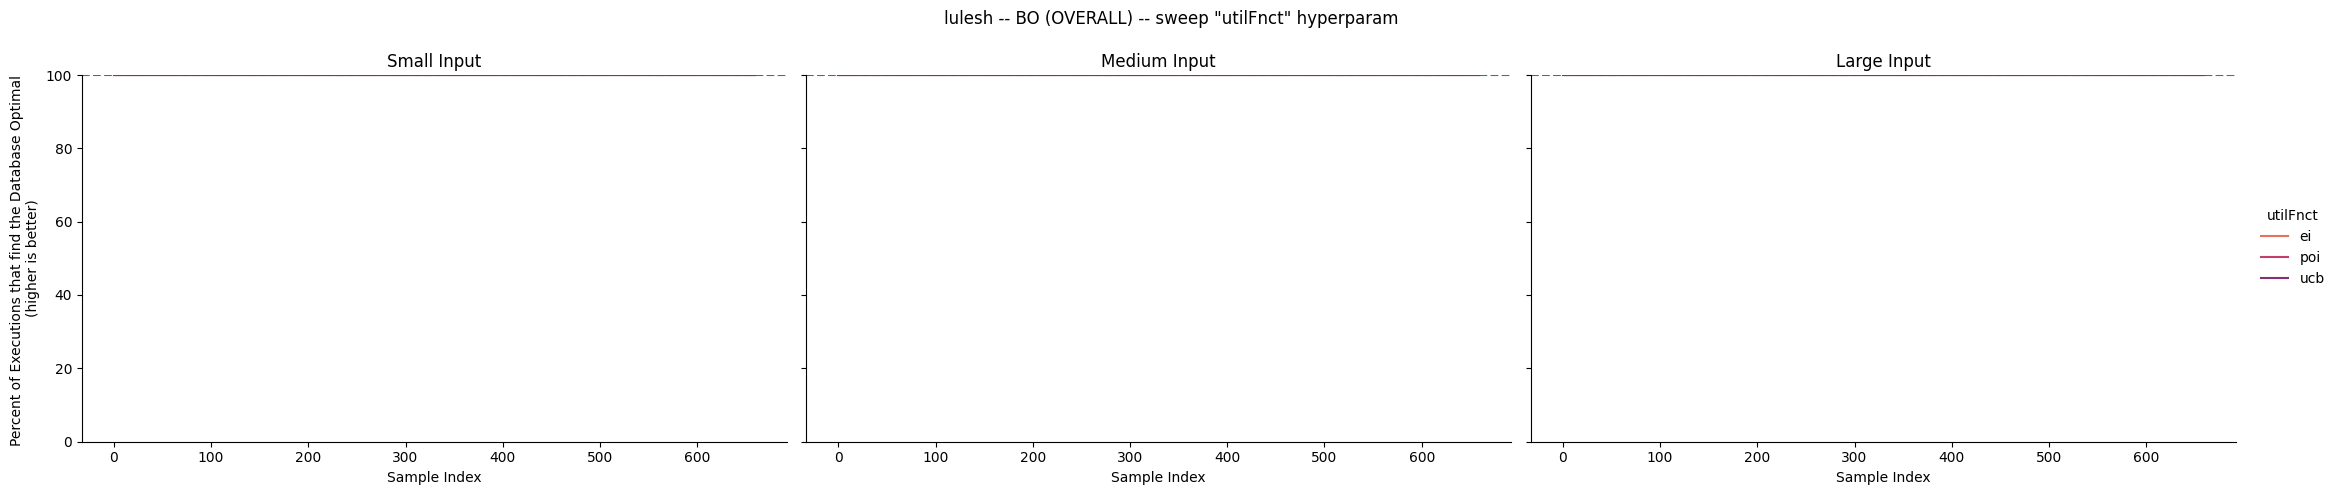

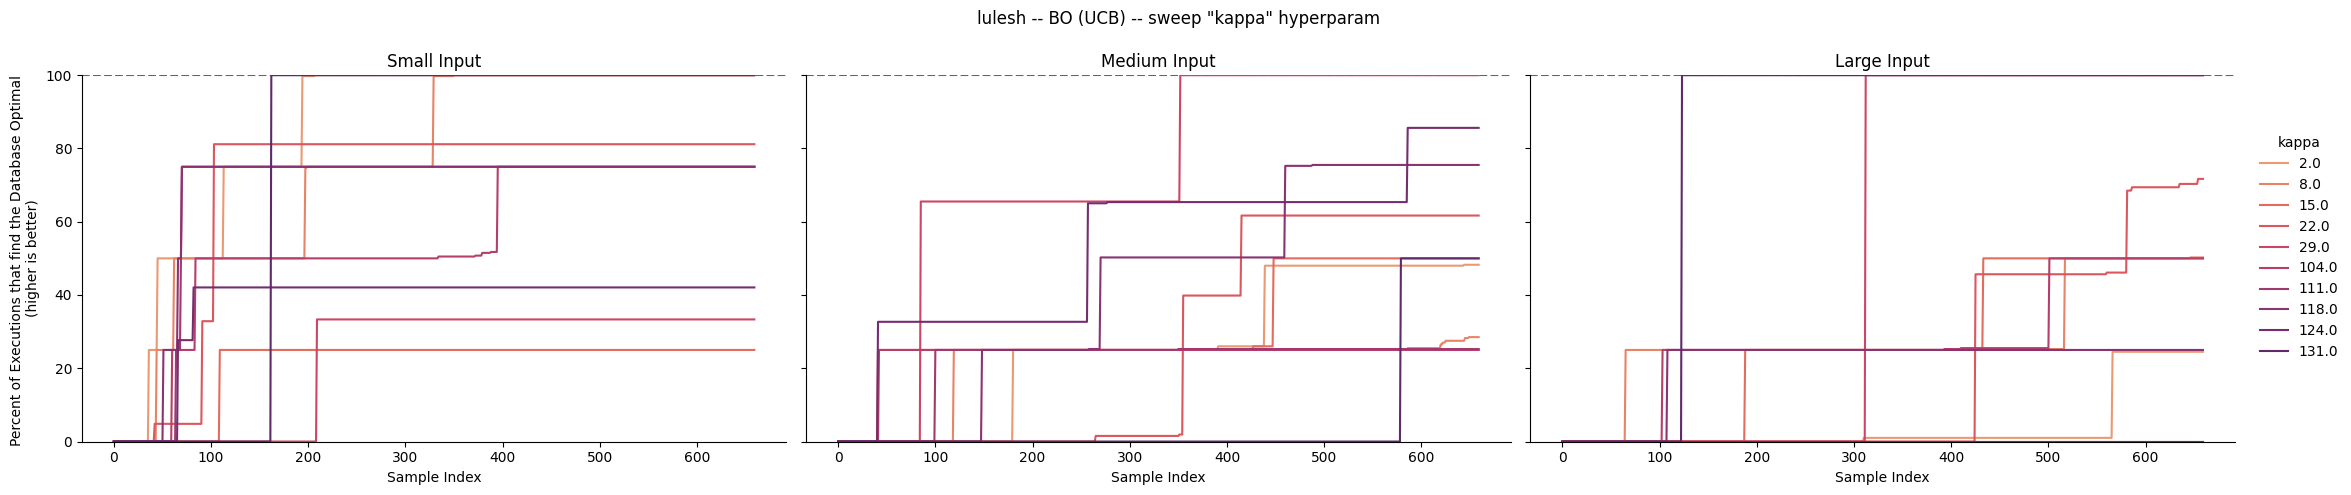

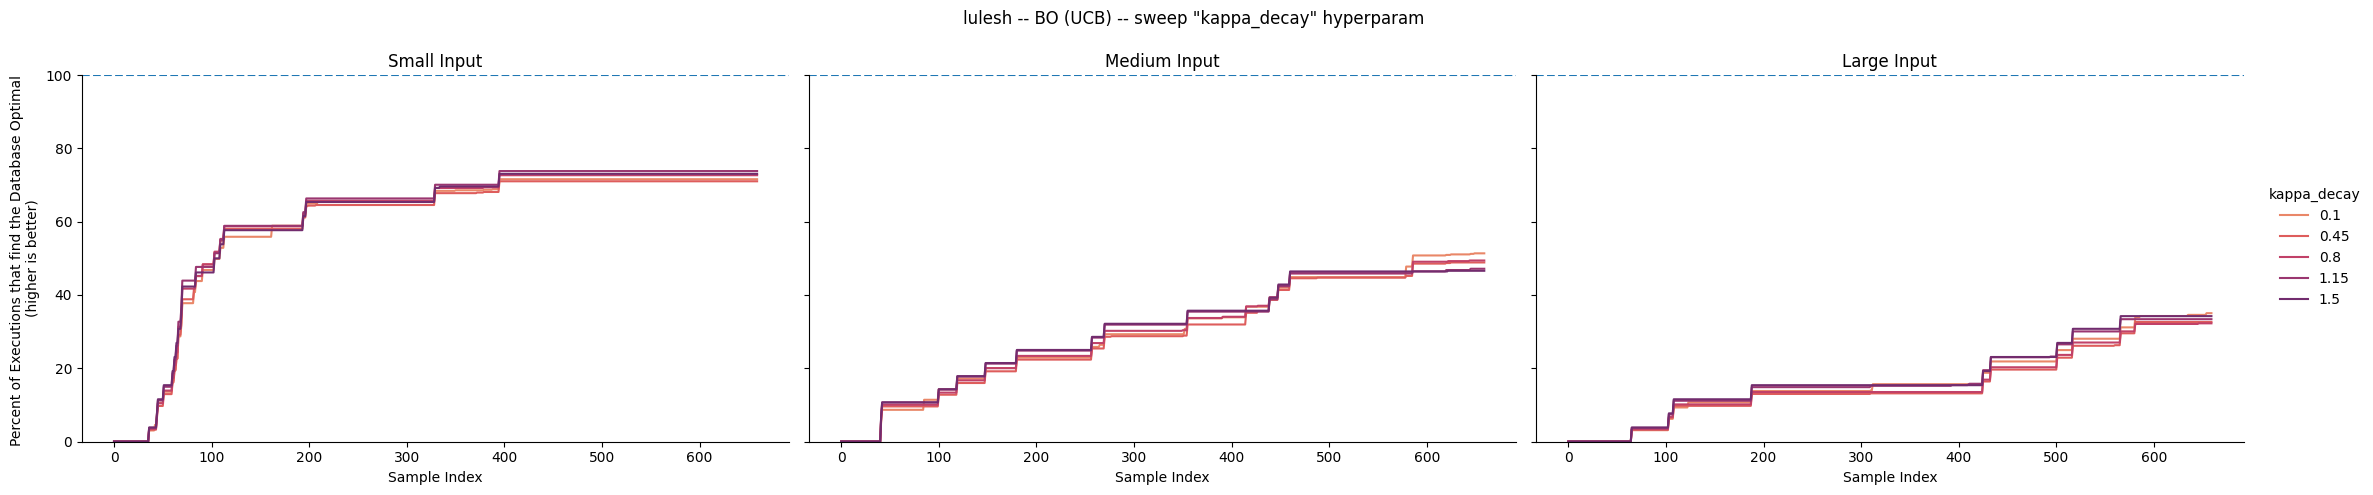

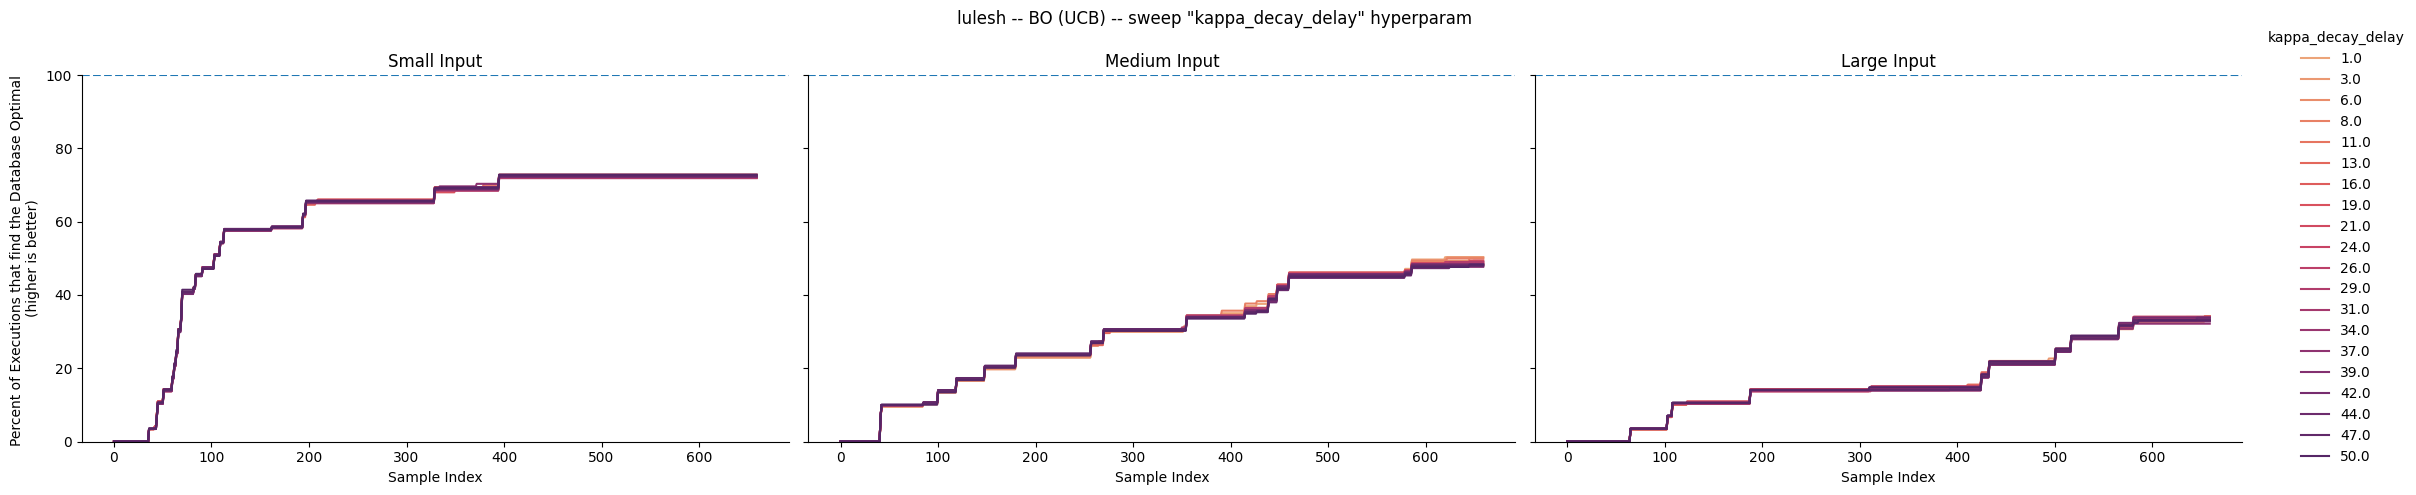

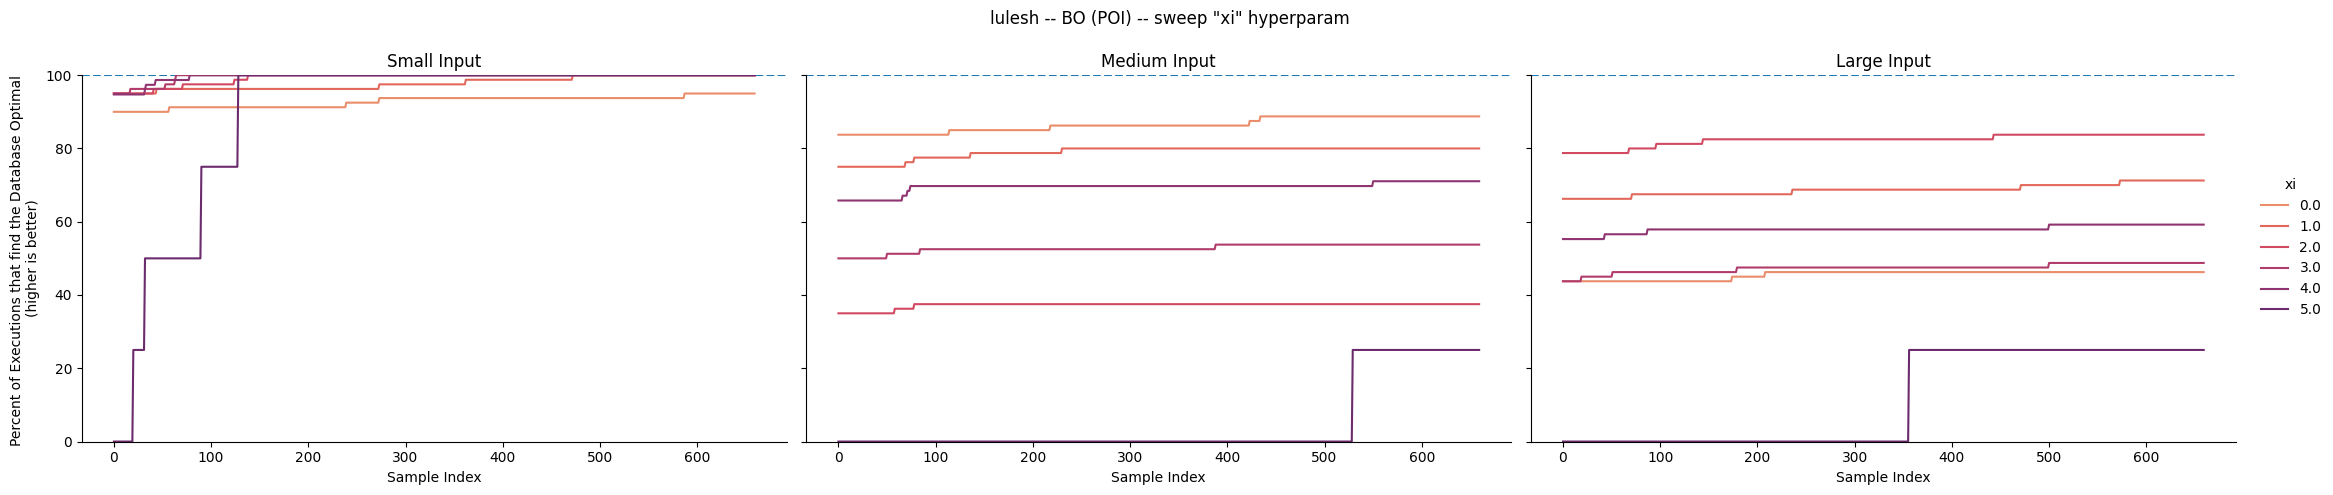

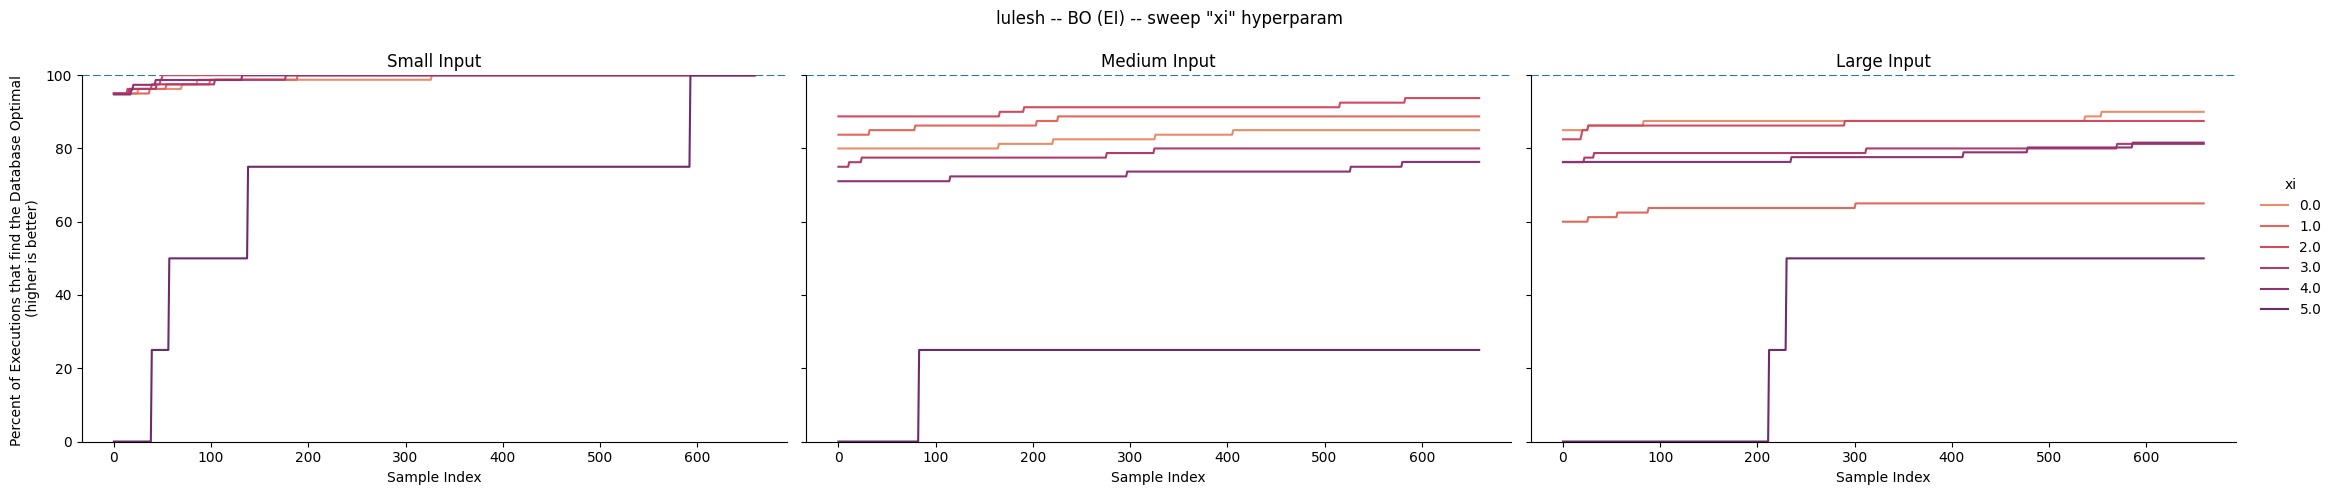

In [5]:
plotIndividualVariablesForAllCodes()